**Data Preprocessing**


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Keeping core ML imports for future phases
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Configuration for Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')

# --- CONFIGURATION & MAPPING (The single most important step) ---
# Define the column names the SCRIPT EXPECTS (Key) and the name in your RAW CSV (Value)
COL_MAP = {
    'Campaign_Objective': 'Campaign_Goal',      # Renames Campaign_Goal to Campaign_Objective
    'Budget_Allocation': 'Acquisition_Cost',    # Uses Acquisition_Cost as the budget proxy
    'Duration_Raw': 'Duration',                 # Renames the raw Duration column
    # Standard 1:1 mappings
    'Campaign_ID': 'Campaign_ID',
    'Channel_Used': 'Channel_Used',
    'Target_Audience': 'Target_Audience',
    'Location': 'Location',
    'Acquisition_Cost': 'Acquisition_Cost', # Keep this for currency cleaning
    'Conversion_Rate': 'Conversion_Rate',
    'Impressions': 'Impressions',
    'Clicks': 'Clicks',
    'ROI': 'ROI' # Added ROI back as it's a numeric feature
}

# --- Column Lists for Analysis ---
CATEGORICAL_COLS = ['Campaign_Objective', 'Channel_Used', 'Target_Audience', 'Location']
# Budget_Allocation and Acquisition_Cost point to the same raw data
NUMERICAL_COLS_BASE = ['Budget_Allocation', 'Impressions', 'Clicks', 'Acquisition_Cost', 'ROI']
TARGET_CR = 'Conversion_Rate'

print("--- 1. Data Loading and Initial Column Mapping ---")

# ==============================================================================
# PHASE 1: Data Loading and Initial Cleanup
# ==============================================================================
try:
    # Load data: Update this path if needed
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Web and social/Social_Media_Advertising.csv')
    df.columns = df.columns.str.strip() # Clean column headers of whitespace

    # 1. Apply robust column renaming
    df_renamed = pd.DataFrame()
    for script_name, raw_name in COL_MAP.items():
        if raw_name in df.columns:
            # If a raw column is mapped to multiple script names, we explicitly create the new column.
            if script_name != raw_name and raw_name in COL_MAP.values() and list(COL_MAP.values()).count(raw_name) > 1:
                 df_renamed[script_name] = df[raw_name]
            else:
                df_renamed[script_name] = df[raw_name]
        else:
            print(f"WARNING: Raw column '{raw_name}' not found for target '{script_name}'. Skipping.")

    df = df_renamed # Use the newly mapped DataFrame

    # Final check on essential columns
    required_checks = ['Campaign_Objective', 'Budget_Allocation', 'Impressions', 'Clicks']
    missing = [col for col in required_checks if col not in df.columns]

    if missing:
        raise ValueError(f"FATAL ERROR: Missing critical columns after mapping: {missing}. Please check COL_MAP.")

except Exception as e:
    print(f"FATAL ERROR during data preparation: {e}")
    raise

print(f"Data loaded and column mapping complete. Total rows: {len(df)}")

# ==============================================================================
# PHASE 2: Data Cleaning and Feature Engineering
# ==============================================================================

print("\n--- 2. Data Cleaning and Feature Engineering (Final Pass) ---")

# --- 2a. Cleaning and Type Conversion ---

# FIX: Add currency cleaning for Acquisition_Cost/Budget_Allocation
print("1. Cleaning Acquisition_Cost (removing currency symbols and commas)...")
cost_cols_to_clean = ['Acquisition_Cost', 'Budget_Allocation']
for col in cost_cols_to_clean:
    if col in df.columns:
        # Remove $, and any commas (,) before converting to numeric
        df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True)
        # Convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure other base numerical columns (Impressions, Clicks, ROI) are numeric
print("2. Ensuring Impressions, Clicks, and ROI are numeric...")
for col in ['Impressions', 'Clicks', 'ROI']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Clean Conversion_Rate: Convert '5.0%' or '0.05' to 0.05 (decimal)
print("3. Cleaning Conversion_Rate...")
df[TARGET_CR] = df[TARGET_CR].astype(str).str.replace(r'[^\d\.]+', '', regex=True)
df[TARGET_CR] = pd.to_numeric(df[TARGET_CR], errors='coerce')
df[TARGET_CR] = np.where(df[TARGET_CR] > 1.0, df[TARGET_CR] / 100, df[TARGET_CR])

# Clean Duration: Extract days (numeric)
print("4. Cleaning Duration...")
df['Duration_Days'] = df['Duration_Raw'].astype(str).str.extract(r'(\d+)')[0]
df['Duration_Days'] = pd.to_numeric(df['Duration_Days'], errors='coerce')
df.drop(columns=['Duration_Raw'], inplace=True, errors='ignore')


# --- 2b. Handling Missing Values and Infinites ---

print("5. Handling Missing Values (Imputation)...")

# Replace any results from division by zero (infinites) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputation
NUMERICAL_IMPUTE_COLS = [c for c in NUMERICAL_COLS_BASE + ['Duration_Days'] if c in df.columns]
NUMERICAL_IMPUTE_COLS = list(set(NUMERICAL_IMPUTE_COLS))

# 1. Numerical: Fill with median
for col in NUMERICAL_IMPUTE_COLS:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# 2. Categorical: Fill with mode
for col in CATEGORICAL_COLS:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

# 3. Drop rows where Conversion_Rate (the main target) is still missing
df.dropna(subset=[TARGET_CR], inplace=True)


# --- 2c. Feature Engineering (Derived Metrics) ---

print("6. Generating derived features (CTR, CPC, CPI)...")

epsilon = 1e-6

df['Click_Through_Rate'] = df['Clicks'] / (df['Impressions'] + epsilon)
# These derived cost metrics will now work correctly as Budget_Allocation is numeric
df['Cost_Per_Click'] = df['Budget_Allocation'] / (df['Clicks'] + epsilon)
df['Cost_Per_Impression'] = df['Budget_Allocation'] / (df['Impressions'] + epsilon)

# Update the numerical column list to include the new features
NUMERICAL_COLS_FINAL = NUMERICAL_IMPUTE_COLS + ['Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression']
# Remove duplicates and the Budget_Allocation proxy since Cost_Per_Click/Impression are better
NUMERICAL_COLS_FINAL = list(set([c for c in NUMERICAL_COLS_FINAL if c != 'Budget_Allocation']))


print(f"\nFinal cleaned and imputed dataset size: {len(df)}")
print("--- Phase 2 Complete ---")

# --- Final Validation Printout ---
print("\nFirst 5 Rows of Cleaned and Feature-Engineered Data:")
print(df.head())
print("\nFinal Numerical Features for Modeling:")
print(NUMERICAL_COLS_FINAL)

--- 1. Data Loading and Initial Column Mapping ---
Data loaded and column mapping complete. Total rows: 300000

--- 2. Data Cleaning and Feature Engineering (Final Pass) ---
1. Cleaning Acquisition_Cost (removing currency symbols and commas)...
2. Ensuring Impressions, Clicks, and ROI are numeric...
3. Cleaning Conversion_Rate...
4. Cleaning Duration...
5. Handling Missing Values (Imputation)...
6. Generating derived features (CTR, CPC, CPI)...

Final cleaned and imputed dataset size: 300000
--- Phase 2 Complete ---

First 5 Rows of Cleaned and Feature-Engineered Data:
  Campaign_Objective  Budget_Allocation  Campaign_ID Channel_Used  \
0     Product Launch              500.0       529013    Instagram   
1   Market Expansion              500.0       275352     Facebook   
2     Product Launch              500.0       692322    Instagram   
3     Increase Sales              500.0       675757    Pinterest   
4   Market Expansion              500.0       535900    Pinterest   

  Target_

**EDA With some new updates**

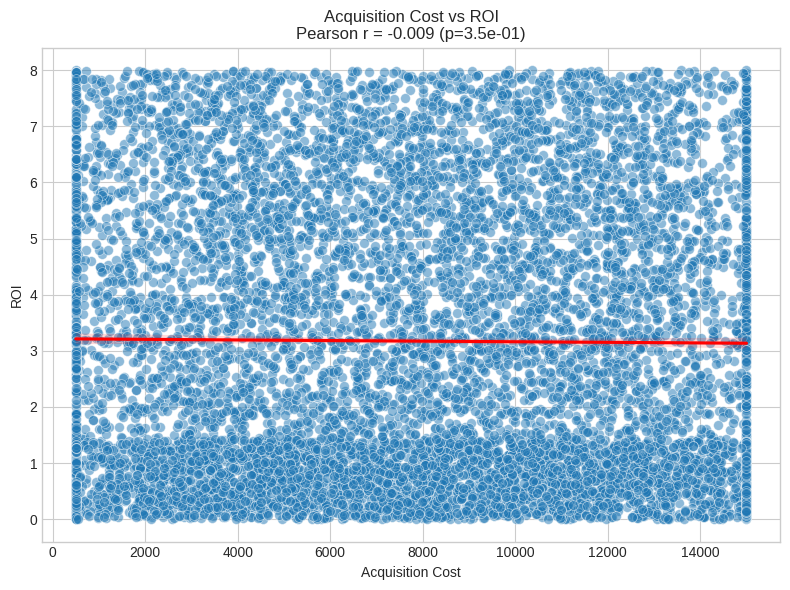

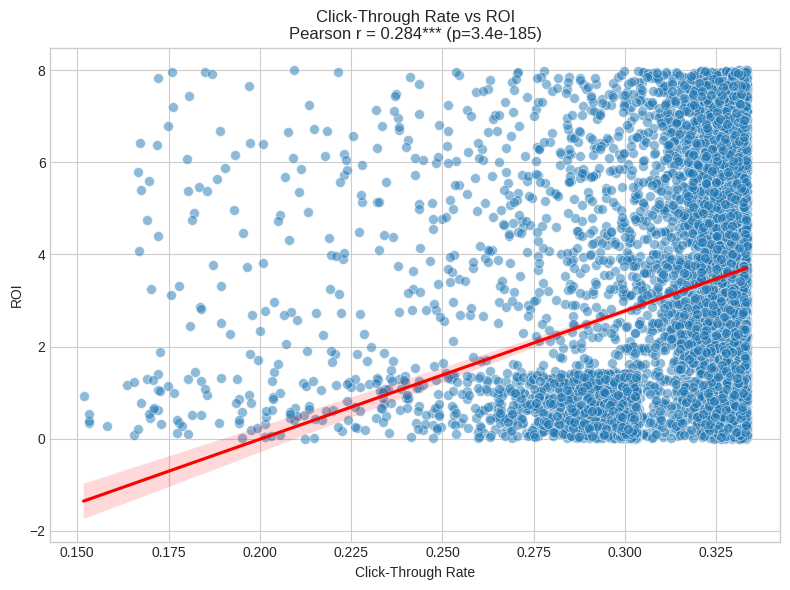

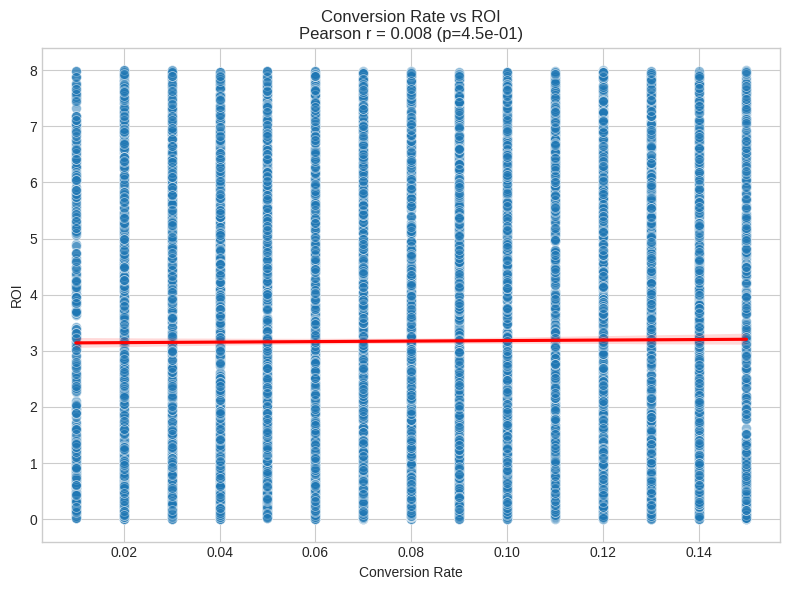

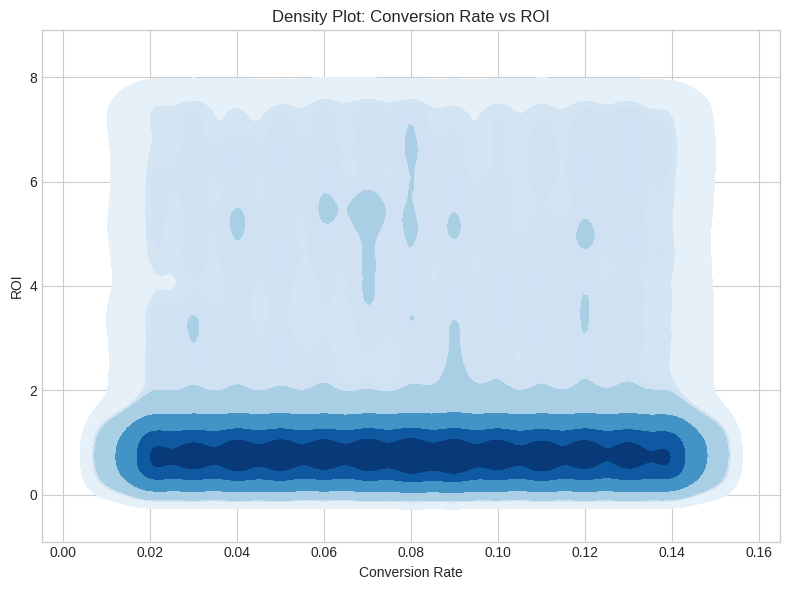

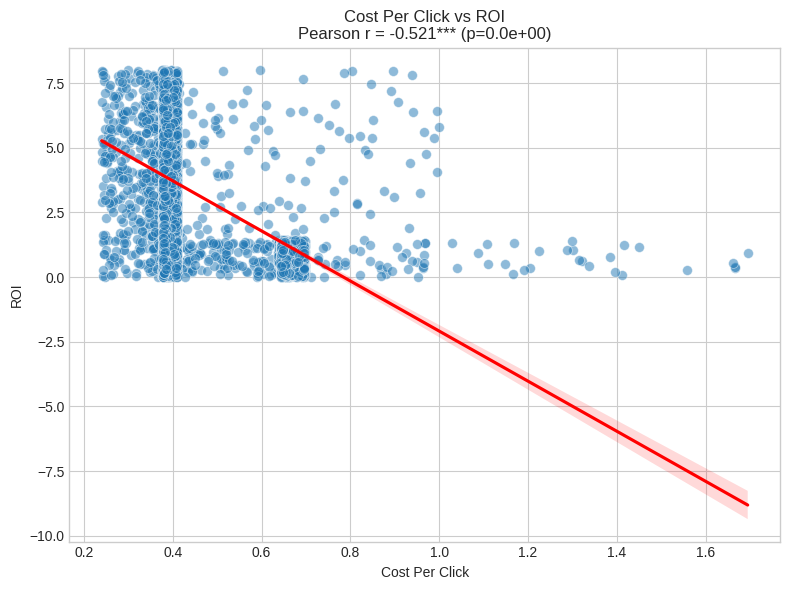

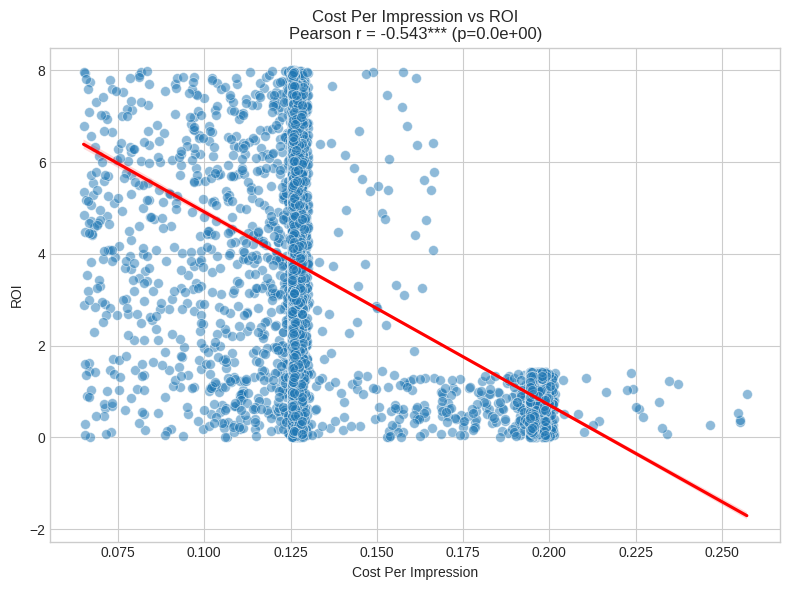

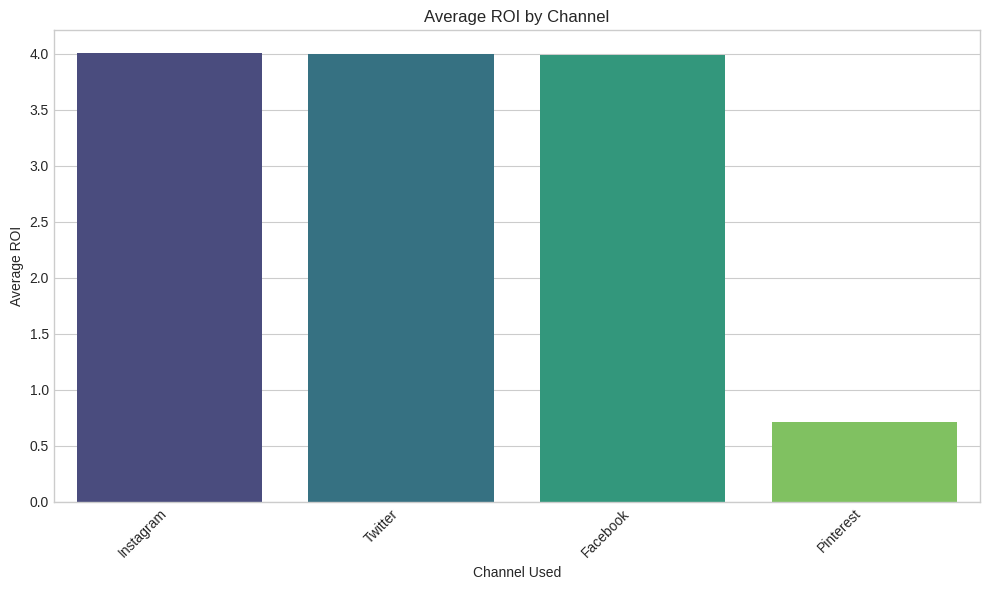

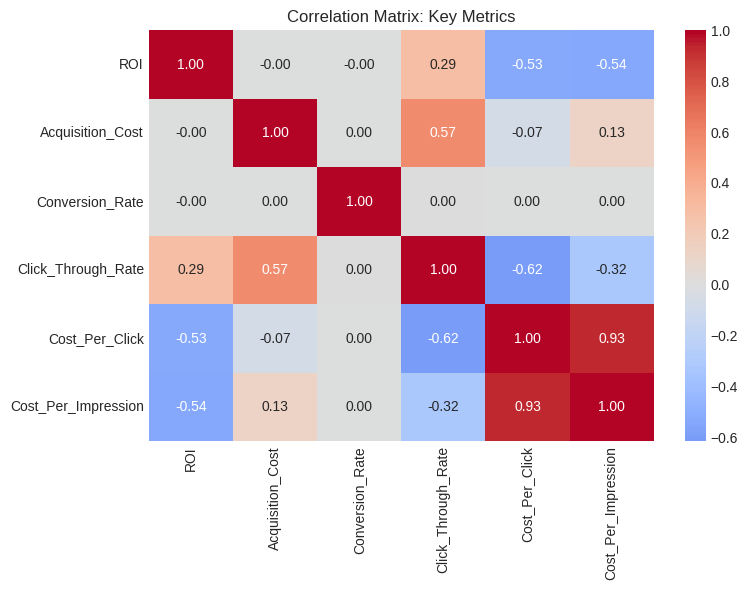


--- Pearson Correlations with ROI ---
Acquisition_Cost    : r = -0.002  p = 3.6e-01 
Conversion_Rate     : r = -0.000  p = 8.9e-01 
Click_Through_Rate  : r =  0.293  p = 0.0e+00 ***
Cost_Per_Click      : r = -0.528  p = 0.0e+00 ***
Cost_Per_Impression : r = -0.539  p = 0.0e+00 ***

--- Target_Audience Performance ---
| Target_Audience   |     ROI |   Acquisition_Cost |   Conversion_Rate |   Click_Through_Rate |
|:------------------|--------:|-------------------:|------------------:|---------------------:|
| All Ages          | 3.21113 |            7742.67 |         0.080197  |             0.314226 |
| Men 18-24         | 3.19524 |            7771.03 |         0.0802423 |             0.314345 |
| Women 45-60       | 3.18588 |            7738.2  |         0.0796518 |             0.314064 |
| Women 35-44       | 3.178   |            7780.6  |         0.0801783 |             0.314172 |
| Women 25-34       | 3.17688 |            7721.11 |         0.0799277 |             0.314126 |
| Men 45

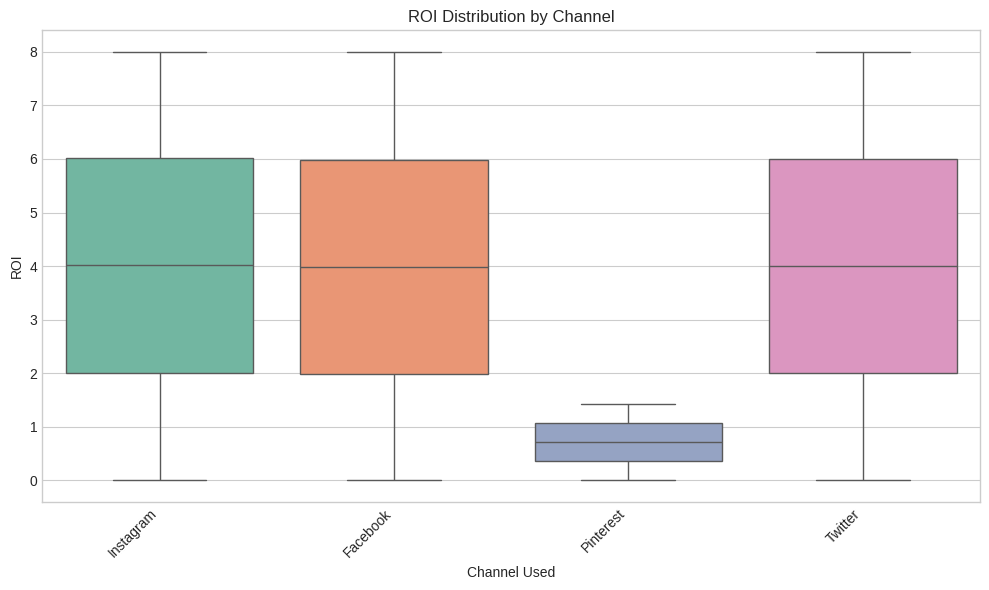


--- Advanced EDA Complete ---


In [ ]:
# --- PHASE 3: ADVANCED EXPLORATORY DATA ANALYSIS (EDA) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Helper for annotated scatterplots with trend line and correlation
def scatter_with_trend(df, x, y, title, xlabel, ylabel, hue=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x, y=y, hue=hue, alpha=0.5, s=50)
    # Trend line
    sns.regplot(data=df, x=x, y=y, scatter=False, color='red', line_kws={'label':"Trend"})
    # Correlation
    r, p = pearsonr(df[x], df[y])
    plt.title(f"{title}\nPearson r = {r:.3f}{'***' if p<0.001 else ''} (p={p:.1e})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Sample for scatterplots if dataset is large
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df

# 1. Acquisition Cost vs ROI
scatter_with_trend(
    df_sample, 'Acquisition_Cost', 'ROI',
    'Acquisition Cost vs ROI',
    'Acquisition Cost', 'ROI'
)

# 2. Click-Through Rate vs ROI
scatter_with_trend(
    df_sample, 'Click_Through_Rate', 'ROI',
    'Click-Through Rate vs ROI',
    'Click-Through Rate', 'ROI'
)

# 3. Conversion Rate vs ROI (scatter and density)
scatter_with_trend(
    df_sample, 'Conversion_Rate', 'ROI',
    'Conversion Rate vs ROI',
    'Conversion Rate', 'ROI'
)
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='Conversion_Rate', y='ROI', cmap="Blues", fill=True, thresh=0.05)
plt.title('Density Plot: Conversion Rate vs ROI')
plt.xlabel('Conversion Rate')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()

# 4. Cost Efficiency: Cost_Per_Click vs ROI
scatter_with_trend(
    df_sample, 'Cost_Per_Click', 'ROI',
    'Cost Per Click vs ROI',
    'Cost Per Click', 'ROI'
)
# Cost_Per_Impression vs ROI
scatter_with_trend(
    df_sample, 'Cost_Per_Impression', 'ROI',
    'Cost Per Impression vs ROI',
    'Cost Per Impression', 'ROI'
)

# 5. Multi-dimensional Platform Performance
platform_perf = df.groupby('Channel_Used').agg(
    ROI_Mean=('ROI', 'mean'),
    ROI_Median=('ROI', 'median'),
    ROI_Std=('ROI', 'std'),
    AC_Mean=('Acquisition_Cost', 'mean'),
    Conv_Rate=('Conversion_Rate', 'mean'),
    CTR=('Click_Through_Rate', 'mean'),
    CPC=('Cost_Per_Click', 'mean')
).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=platform_perf.sort_values('ROI_Mean', ascending=False),
            x='Channel_Used', y='ROI_Mean', palette='viridis')
plt.title('Average ROI by Channel')
plt.ylabel('Average ROI')
plt.xlabel('Channel Used')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Correlation Matrix & Heatmap
num_cols = [
    'ROI', 'Acquisition_Cost', 'Conversion_Rate', 'Click_Through_Rate',
    'Cost_Per_Click', 'Cost_Per_Impression'
]
corr = df[num_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Key Metrics')
plt.tight_layout()
plt.show()

# 7. Statistical Significance Table
print("\n--- Pearson Correlations with ROI ---")
for col in num_cols:
    if col != 'ROI':
        r, p = pearsonr(df[col], df['ROI'])
        print(f"{col:20s}: r = {r:6.3f}  p = {p:.1e} {'***' if p<0.001 else ''}")

# 8. Audience Segment and Device Type Performance
for group_col in ['Target_Audience', 'Device_Type']:
    if group_col in df.columns:
        seg_perf = df.groupby(group_col).agg(
            ROI=('ROI', 'mean'),
            Acquisition_Cost=('Acquisition_Cost', 'mean'),
            Conversion_Rate=('Conversion_Rate', 'mean'),
            Click_Through_Rate=('Click_Through_Rate', 'mean')
        ).sort_values('ROI', ascending=False)
        print(f"\n--- {group_col} Performance ---")
        print(seg_perf.to_markdown())

# 9. ROI Distribution by Channel
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Channel_Used', y='ROI', palette='Set2')
plt.title('ROI Distribution by Channel')
plt.xlabel('Channel Used')
plt.ylabel('ROI')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Advanced EDA Complete ---")


**EDA-Part2**

--- PHASE 3: ENHANCED EXPLORATORY DATA ANALYSIS (EDA) ---


--- 1. Best Performing Channels (by Average Conversion Rate) ---
|    | Channel_Used   |   Avg_Conversion_Rate |   Median_Conversion_Rate |   count |
|---:|:---------------|----------------------:|-------------------------:|--------:|
|  3 | Twitter        |             0.0803633 |                     0.08 |   74653 |
|  2 | Pinterest      |             0.0800422 |                     0.08 |   75082 |
|  0 | Facebook       |             0.07987   |                     0.08 |   75164 |
|  1 | Instagram      |             0.0797643 |                     0.08 |   75101 |


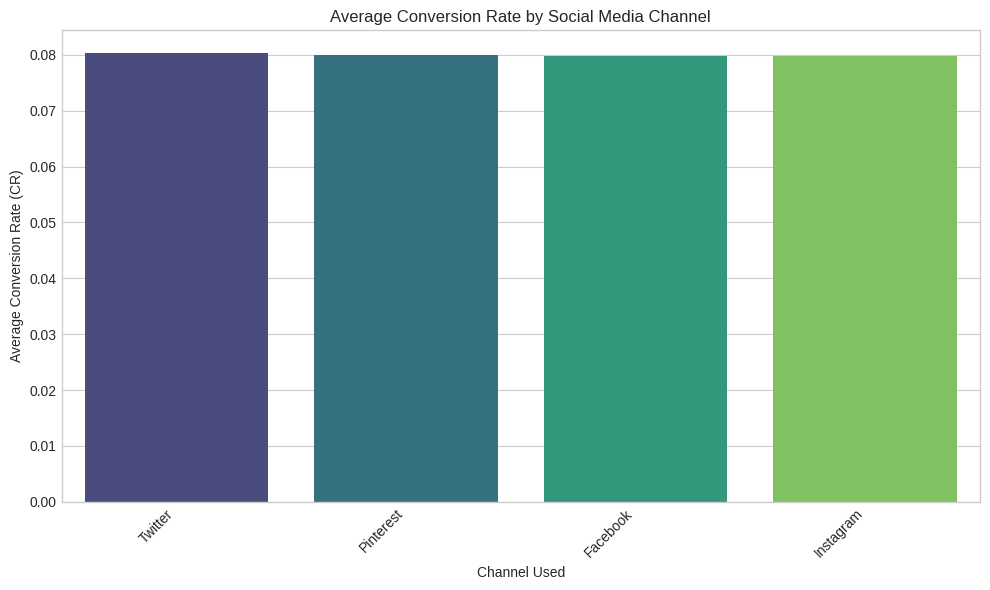


--- 2. Best Performing Target Audiences (by Average Conversion Rate) ---
|    | Target_Audience   |   Avg_Conversion_Rate |   Median_Conversion_Rate |   count |
|---:|:------------------|----------------------:|-------------------------:|--------:|
|  4 | Men 45-60         |             0.0802589 |                     0.08 |   33491 |
|  1 | Men 18-24         |             0.0802423 |                     0.08 |   33181 |
|  0 | All Ages          |             0.080197  |                     0.08 |   33447 |
|  7 | Women 35-44       |             0.0801783 |                     0.08 |   33142 |
|  5 | Women 18-24       |             0.0799687 |                     0.08 |   33593 |


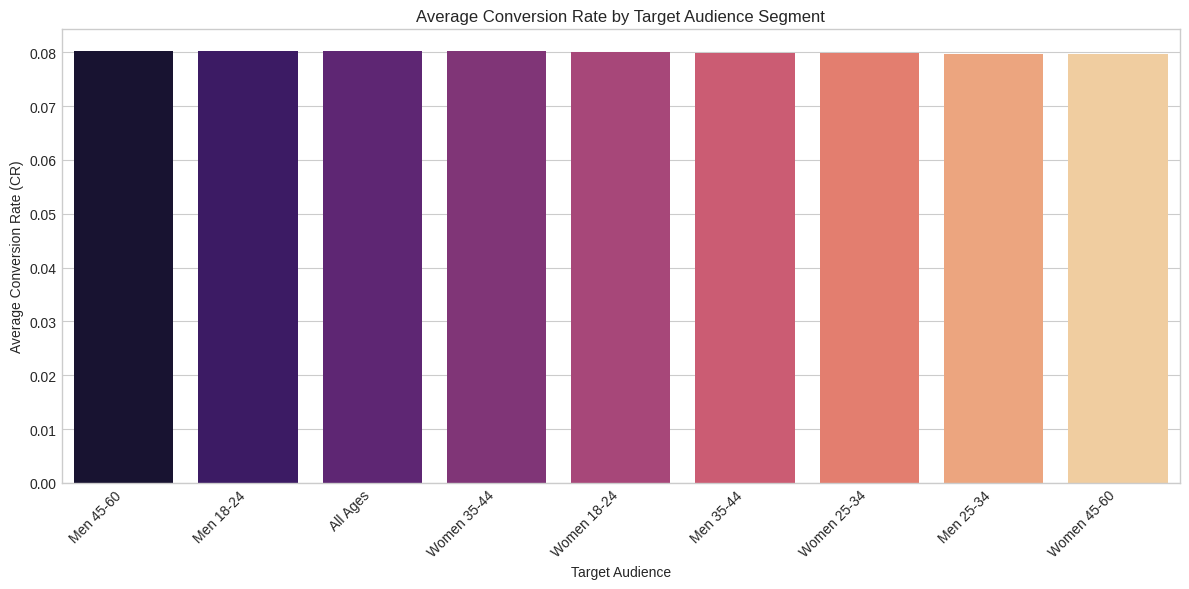

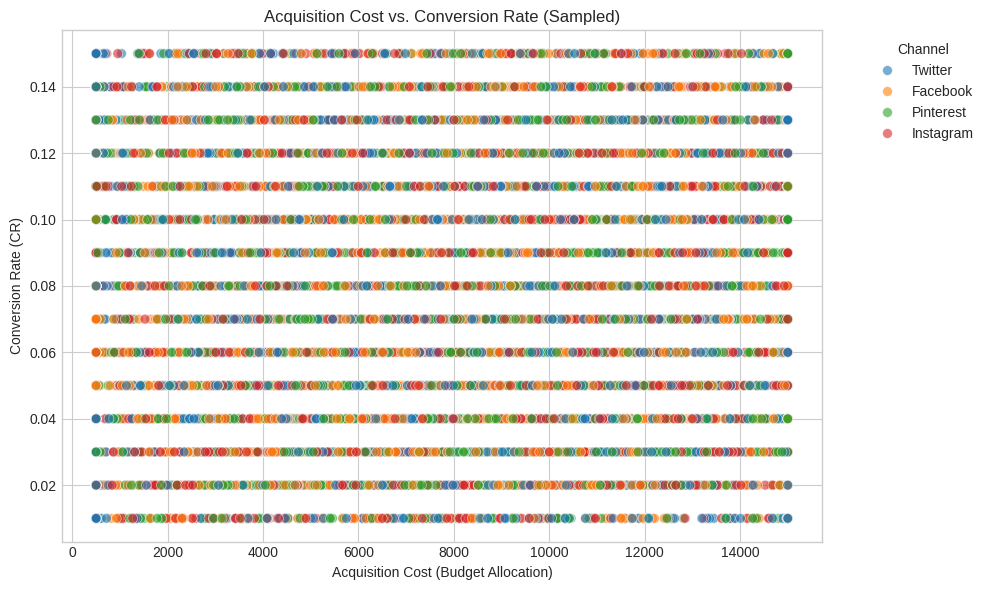

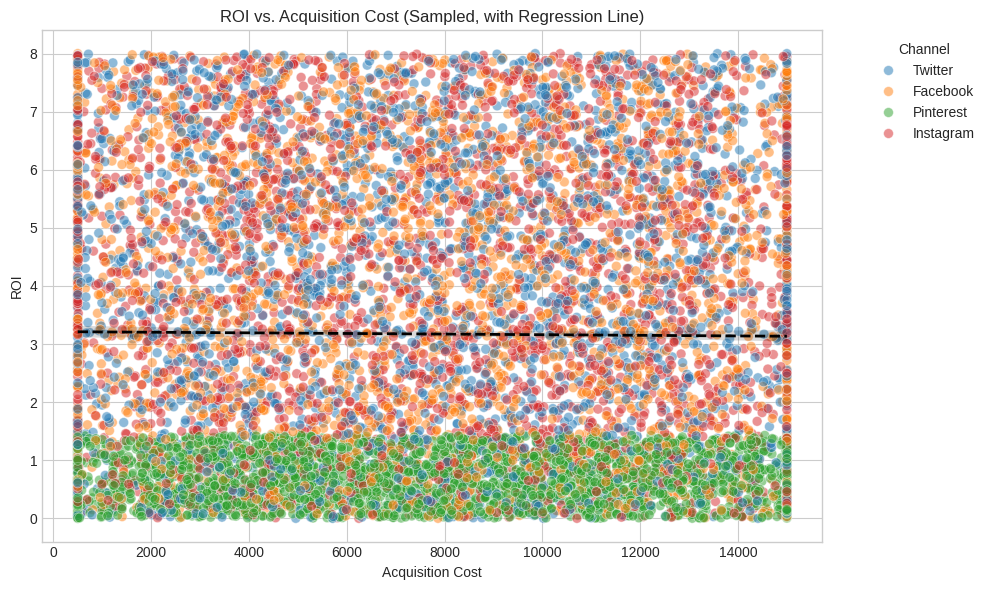

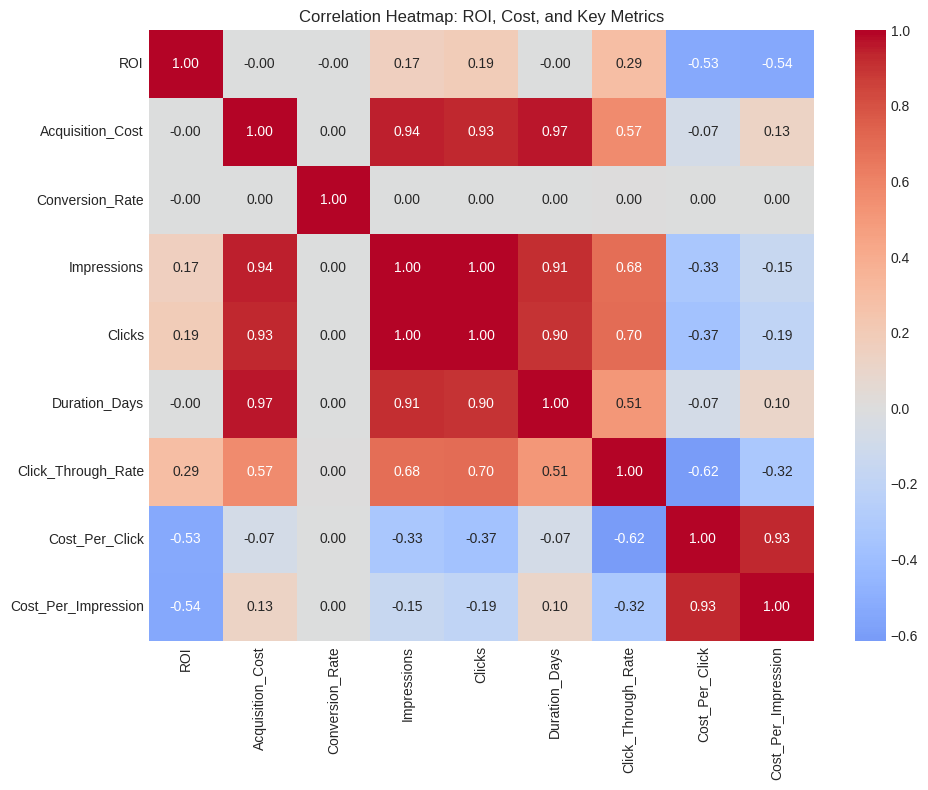

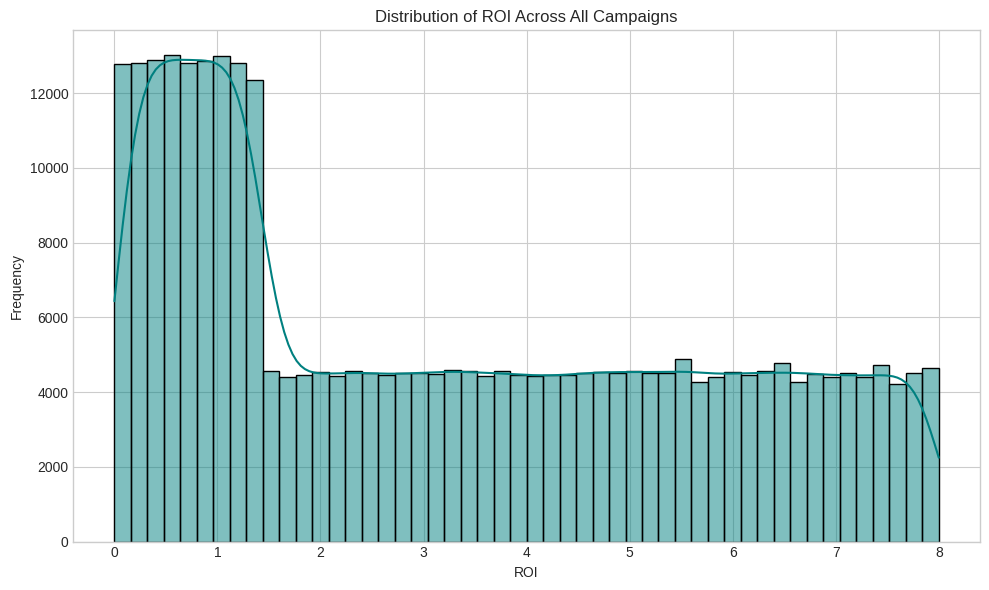

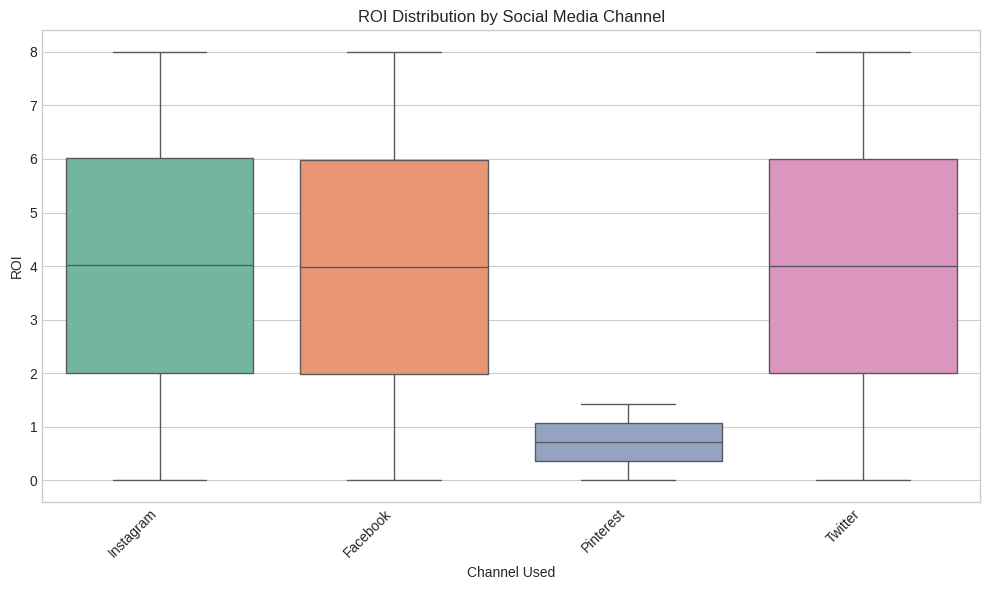

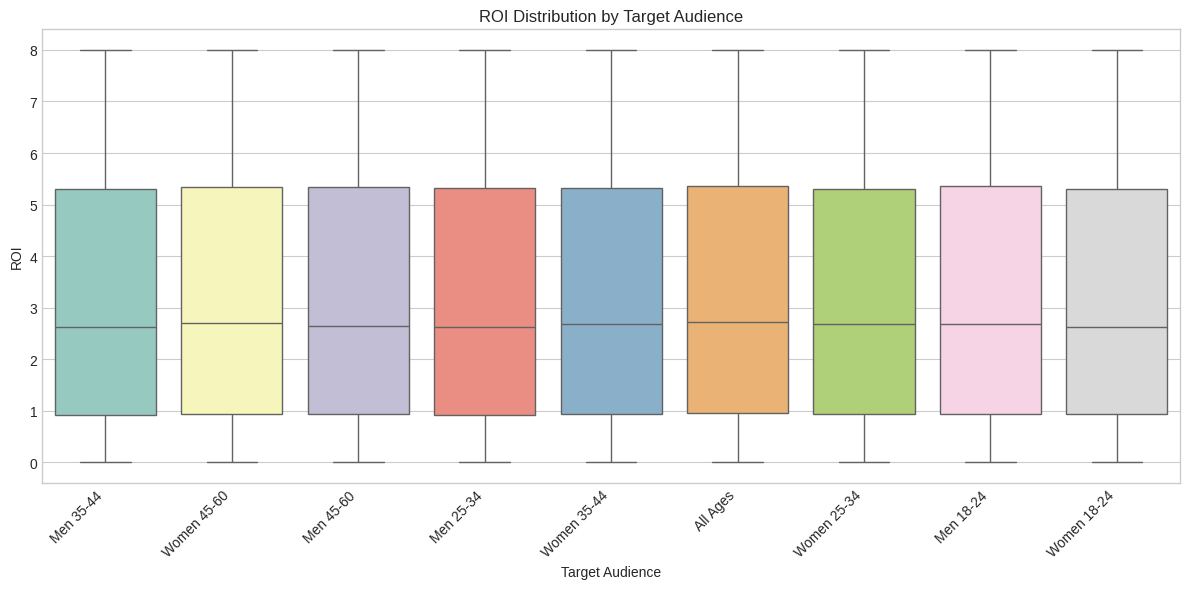

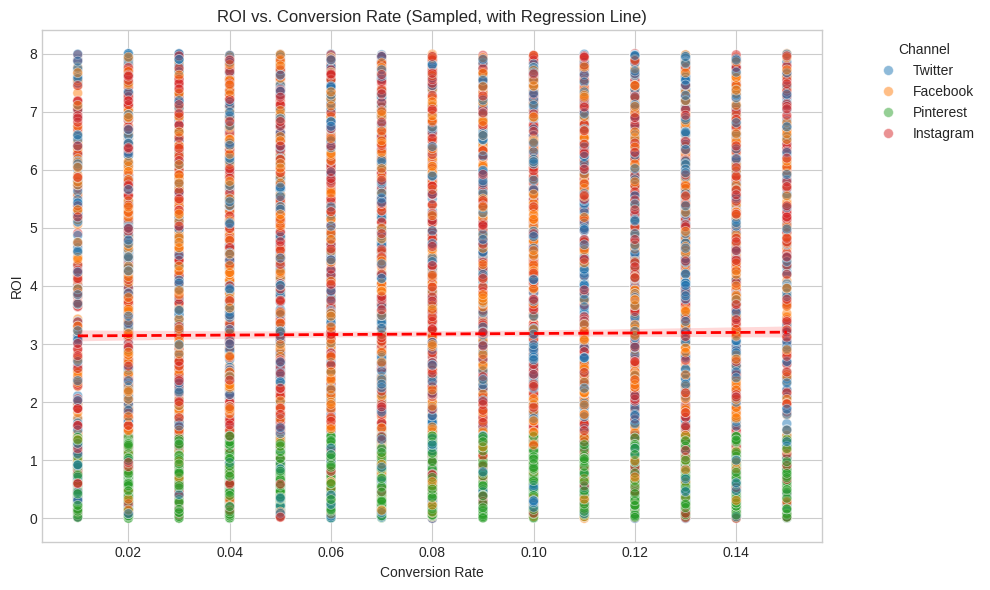

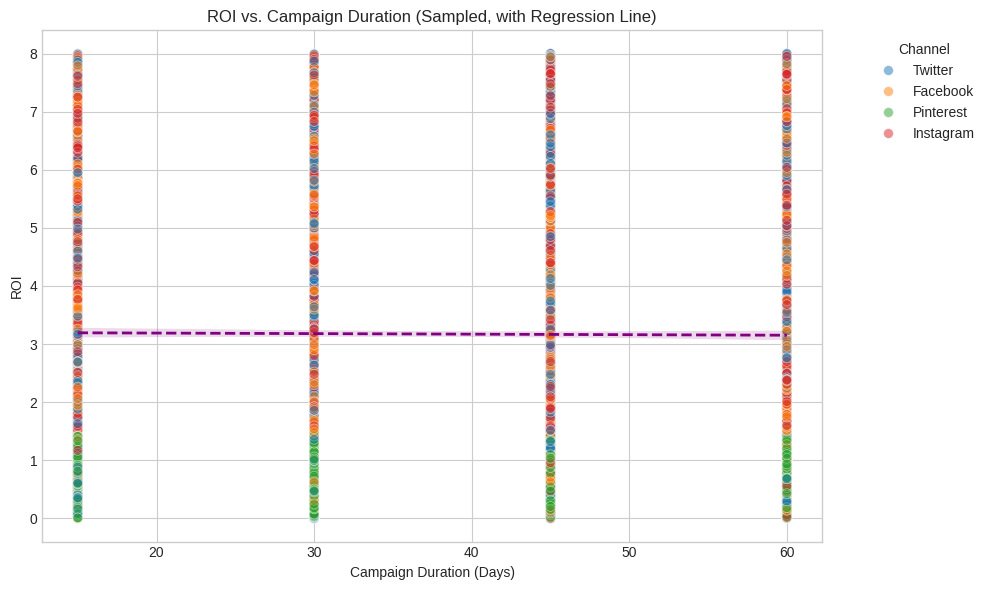


--- Best ROI Performance by Channel ---
|    | Channel_Used   |   Avg_ROI |   Median_ROI |   ROI_Std |   count |   Positive_ROI_Rate |
|---:|:---------------|----------:|-------------:|----------:|--------:|--------------------:|
|  1 | Instagram      |  4.00879  |     4.02     |  2.31136  |   75101 |            0.999401 |
|  3 | Twitter        |  4.00224  |     4        |  2.30567  |   74653 |            0.999303 |
|  0 | Facebook       |  3.98693  |     3.98     |  2.30612  |   75164 |            0.999335 |
|  2 | Pinterest      |  0.716431 |     0.716777 |  0.412227 |   75082 |            0.999494 |

--- Best ROI Performance by Target Audience ---
|    | Target_Audience   |   Avg_ROI |   Median_ROI |   ROI_Std |   count |   Positive_ROI_Rate |
|---:|:------------------|----------:|-------------:|----------:|--------:|--------------------:|
|  0 | All Ages          |   3.21113 |         2.73 |   2.46406 |   33447 |            0.999701 |
|  1 | Men 18-24         |   3.19524 |        

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

# Helper function to print a quick summary of the analysis
def print_analysis_summary(title, df_results, value_col):
    print(f"\n--- {title} ---")
    print(df_results.sort_values(by=value_col, ascending=False).head(5).to_markdown(index=True))

print("================================================================================")
print("--- PHASE 3: ENHANCED EXPLORATORY DATA ANALYSIS (EDA) ---")
print("================================================================================\n")

# --- Q1: Channel Performance vs. Conversion Rate ---
channel_performance = df.groupby('Channel_Used')['Conversion_Rate'].agg(['mean', 'median', 'count']).reset_index()
channel_performance.rename(columns={'mean': 'Avg_Conversion_Rate', 'median': 'Median_Conversion_Rate'}, inplace=True)
print_analysis_summary("1. Best Performing Channels (by Average Conversion Rate)", channel_performance, 'Avg_Conversion_Rate')

plt.figure(figsize=(10, 6))
sns.barplot(
    data=channel_performance.sort_values('Avg_Conversion_Rate', ascending=False),
    x='Channel_Used',
    y='Avg_Conversion_Rate',
    palette='viridis'
)
plt.title('Average Conversion Rate by Social Media Channel')
plt.ylabel('Average Conversion Rate (CR)')
plt.xlabel('Channel Used')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Q2: Target Audience Performance vs. Conversion Rate ---
audience_performance = df.groupby('Target_Audience')['Conversion_Rate'].agg(['mean', 'median', 'count']).reset_index()
audience_performance.rename(columns={'mean': 'Avg_Conversion_Rate', 'median': 'Median_Conversion_Rate'}, inplace=True)
print_analysis_summary("2. Best Performing Target Audiences (by Average Conversion Rate)", audience_performance, 'Avg_Conversion_Rate')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=audience_performance.sort_values('Avg_Conversion_Rate', ascending=False),
    x='Target_Audience',
    y='Avg_Conversion_Rate',
    palette='magma'
)
plt.title('Average Conversion Rate by Target Audience Segment')
plt.ylabel('Average Conversion Rate (CR)')
plt.xlabel('Target Audience')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Q3: Acquisition Cost vs. Conversion Rate (Scatter Plot) ---
plt.figure(figsize=(10, 6))
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df
sns.scatterplot(
    data=df_sample,
    x='Acquisition_Cost',
    y='Conversion_Rate',
    hue='Channel_Used',
    alpha=0.6,
    s=50
)
plt.title('Acquisition Cost vs. Conversion Rate (Sampled)')
plt.xlabel('Acquisition Cost (Budget Allocation)')
plt.ylabel('Conversion Rate (CR)')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =========================
# NEW ROI-FOCUSED ANALYSIS
# =========================

# --- Q4: ROI vs. Acquisition Cost (Scatter + Regression) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample,
    x='Acquisition_Cost',
    y='ROI',
    hue='Channel_Used',
    alpha=0.5,
    s=50
)
sns.regplot(
    data=df_sample,
    x='Acquisition_Cost',
    y='ROI',
    scatter=False,
    color='black',
    line_kws={'lw':2, 'ls':'--'}
)
plt.title('ROI vs. Acquisition Cost (Sampled, with Regression Line)')
plt.xlabel('Acquisition Cost')
plt.ylabel('ROI')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Q5: Correlation Heatmap (Numerical Features) ---
numerical_cols = ['ROI', 'Acquisition_Cost', 'Conversion_Rate', 'Impressions', 'Clicks', 'Duration_Days',
                  'Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression']
corr = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap: ROI, Cost, and Key Metrics')
plt.tight_layout()
plt.show()

# --- Q6: Distribution of ROI ---
plt.figure(figsize=(10, 6))
sns.histplot(df['ROI'], bins=50, kde=True, color='teal')
plt.title('Distribution of ROI Across All Campaigns')
plt.xlabel('ROI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Q7: ROI by Channel (Boxplot) ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Channel_Used',
    y='ROI',
    palette='Set2'
)
plt.title('ROI Distribution by Social Media Channel')
plt.xlabel('Channel Used')
plt.ylabel('ROI')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Q8: ROI by Target Audience (Boxplot) ---
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Target_Audience',
    y='ROI',
    palette='Set3'
)
plt.title('ROI Distribution by Target Audience')
plt.xlabel('Target Audience')
plt.ylabel('ROI')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Q9: ROI vs. Conversion Rate (Scatter + Regression) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample,
    x='Conversion_Rate',
    y='ROI',
    hue='Channel_Used',
    alpha=0.5,
    s=50
)
sns.regplot(
    data=df_sample,
    x='Conversion_Rate',
    y='ROI',
    scatter=False,
    color='red',
    line_kws={'lw':2, 'ls':'--'}
)
plt.title('ROI vs. Conversion Rate (Sampled, with Regression Line)')
plt.xlabel('Conversion Rate')
plt.ylabel('ROI')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Q10: ROI vs. Duration (Scatter + Regression) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample,
    x='Duration_Days',
    y='ROI',
    hue='Channel_Used',
    alpha=0.5,
    s=50
)
sns.regplot(
    data=df_sample,
    x='Duration_Days',
    y='ROI',
    scatter=False,
    color='purple',
    line_kws={'lw':2, 'ls':'--'}
)
plt.title('ROI vs. Campaign Duration (Sampled, with Regression Line)')
plt.xlabel('Campaign Duration (Days)')
plt.ylabel('ROI')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Q11: ROI Performance Summary Tables ---
roi_channel = df.groupby('Channel_Used').agg(
    Avg_ROI=('ROI', 'mean'),
    Median_ROI=('ROI', 'median'),
    ROI_Std=('ROI', 'std'),
    count=('ROI', 'count'),
    Positive_ROI_Rate=('ROI', lambda x: (x > 0).mean())
).reset_index()
print_analysis_summary("Best ROI Performance by Channel", roi_channel, 'Avg_ROI')

roi_audience = df.groupby('Target_Audience').agg(
    Avg_ROI=('ROI', 'mean'),
    Median_ROI=('ROI', 'median'),
    ROI_Std=('ROI', 'std'),
    count=('ROI', 'count'),
    Positive_ROI_Rate=('ROI', lambda x: (x > 0).mean())
).reset_index()
print_analysis_summary("Best ROI Performance by Target Audience", roi_audience, 'Avg_ROI')

print("\n--- EDA Complete ---")


**Q1,Q2,Q3 Old version**

Dataset loaded successfully.

--- Initial Data Overview ---
Dataset Shape: (300000, 16)

Missing Values Before Cleaning:
Campaign_ID         0
Target_Audience     0
Campaign_Goal       0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
Company             0
dtype: int64

Acquisition_Cost column cleaned and converted to float.
Conversion_Rate column cleaned and normalized to decimal (0.0 - 1.0).

--- OUTLIER MITIGATION VISUALIZATION (Before vs. After 99th Percentile Cap) ---


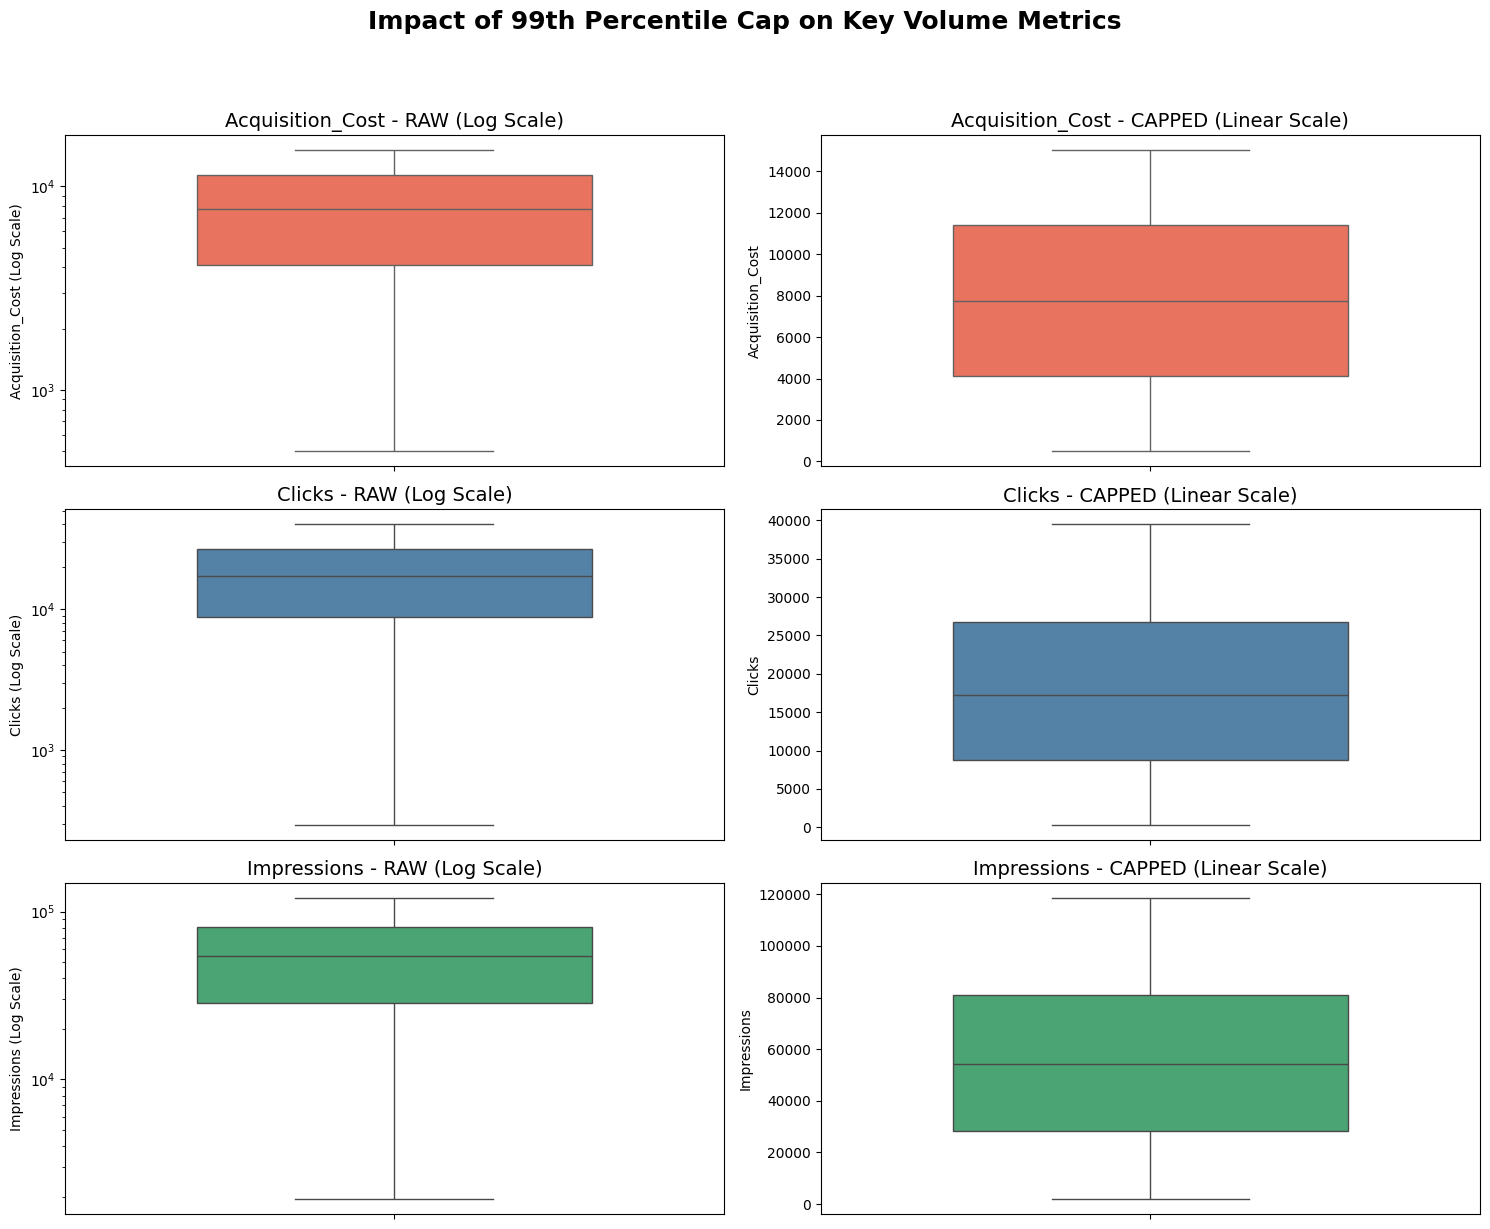

Box plots generated. Log scale is used for RAW data to demonstrate the highly skewed nature, and linear scale for CAPPED data to show the effect of truncation.
Outliers capped in Acquisition_Cost, Clicks, and Impressions using 99th Percentile Cap.
Derived Duration_Days, Gender, Age_Group, Engagement_Score, and CR_per_AC features.
Removed NaNs in core metrics and categorical segments. Remaining rows: 300000
Phase 1 Complete: Data is cleaned, outliers are capped on raw metrics, and core features are engineered.

--- PHASE 2: DESCRIPTIVE ANALYSIS ---
--- Q1: Highest ROI Channel Strategy ---

Top 10 Highest ROI Campaign Strategies (Using Mean ROI):
Channel_Used    Campaign_Goal      ROI Mode_Segment
     Twitter   Product Launch 4.041108      Fashion
   Instagram   Product Launch 4.017029       Health
     Twitter   Increase Sales 4.008688         Food
   Instagram  Brand Awareness 4.007770         Food
   Instagram   Increase Sales 4.006465      Fashion
   Instagram Market Expansion 4.003

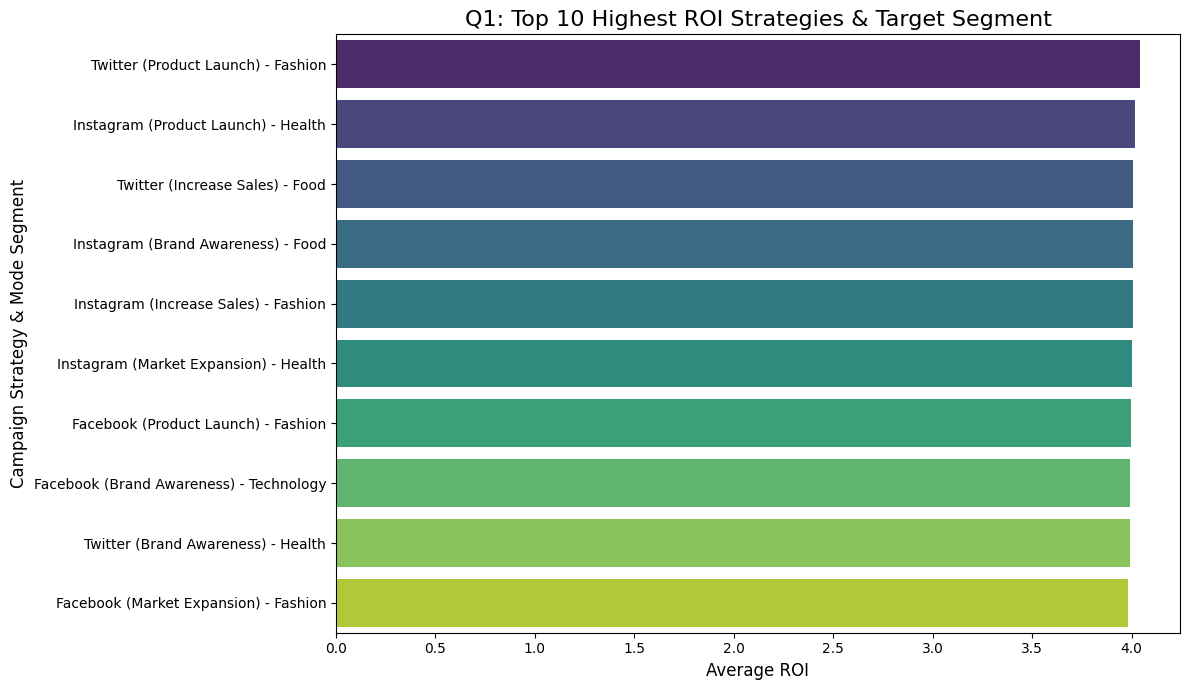


--------------------------------------------------------------------------------
--- Q3: Audience Budget Sensitivity (Conversion Rate by Budget) ---

--- Q3 Numerical Summary (Simplified Cost Buckets) ---

Q3 Numerical Summary: Average Conversion Rate at 3 Equal Cost Buckets on Twitter
Cost_Level      Low Cost Medium Cost High Cost
Target_Audience                               
All Ages           7.96%       8.11%     7.98%
Men 18-24          8.15%       8.05%     8.04%
Men 45-60          8.12%       8.18%     8.11%
Women 18-24        8.12%        8.0%     7.94%


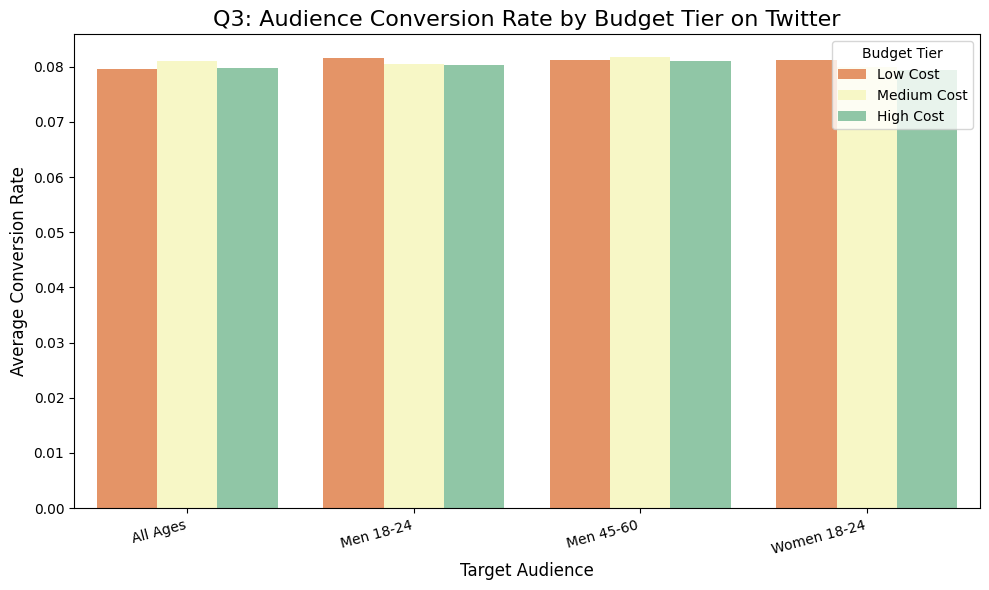


Phase 2 Complete: Q1 and Q3 insights generated.

--- PHASE 3: UNSUPERVISED ANALYSIS ---
--- Q2: K-Means Clustering for Elite Campaign Blueprint ---


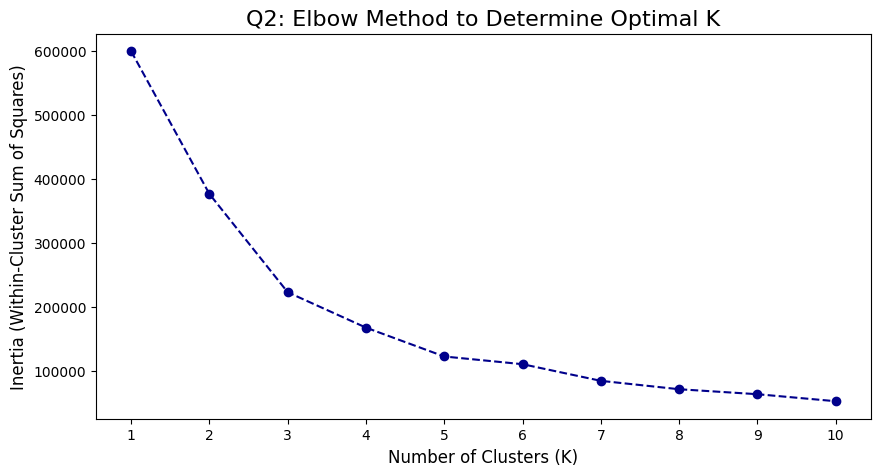


Optimal K selected: 3 (Typically the 'Elbow' point in the graph).

Cluster Performance Averages:
         Conversion_Rate  Engagement_Score
Cluster                                   
0               0.042168          0.319066
1               0.112762          0.319167
2               0.079428          0.246114

Identified Elite Campaign Cluster ID: 1 (Highest Conversion Rate)

--- Elite Campaign Blueprint (Most Frequent Characteristics) ---
Channel_Used                Twitter
Campaign_Goal       Brand Awareness
Target_Audience         Women 18-24
Customer_Segment               Home
Location                Los Angeles
Language                    Spanish
Duration_Days                  60.0
Gender                          Men
Age_Group                     18-24


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


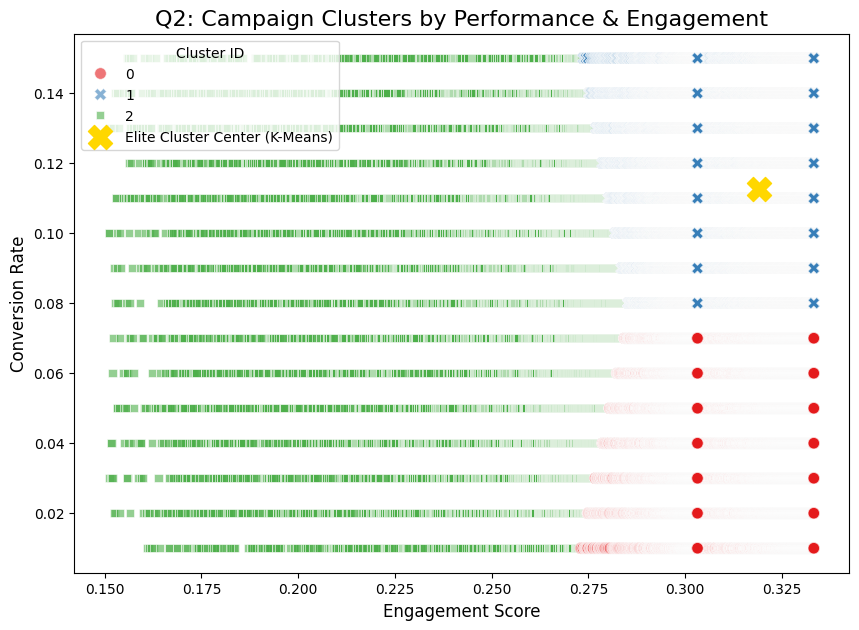


Phase 3 Complete: K-Means Clustering finalized.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import time
import warnings

# Configuration for Matplotlib
# Note: Temporarily disabling the seaborn style so the log scale is more effective
# plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuration for Pandas
pd.options.mode.chained_assignment = None

# --- 1. Load Data ---
# Load the dataset using the path specified by the user
try:
    # NOTE: If running outside of the Colab environment where this path is valid,
    # the user must update this line to their local file path.
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Web and social/Social_Media_Advertising.csv')
    df.columns = df.columns.str.strip() # Clean column headers of whitespace
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Social_Media_Advertising.csv not found.")
    print("Please ensure the file is uploaded and the path is correct.")
    exit()

# --- 1b. Initial Data Overview (EDA Checks) ---
print("\n--- Initial Data Overview ---")
print(f"Dataset Shape: {df.shape}")
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())


# --- 2. Initial Cleaning and Type Conversion ---

# Clean Acquisition_Cost: Remove '$' and ',' and convert to float
df['Acquisition_Cost'] = df['Acquisition_Cost'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
# Fill zero/negative costs with a small positive value before plotting raw data
df['Acquisition_Cost'] = np.where(df['Acquisition_Cost'] <= 0, 1.0, df['Acquisition_Cost'])
print("\nAcquisition_Cost column cleaned and converted to float.")

# Clean and Normalize Conversion_Rate from string percentage to decimal float
df['Conversion_Rate'] = df['Conversion_Rate'].astype(str).str.replace(r'[^\d\.]+', '', regex=True)
df['Conversion_Rate'] = pd.to_numeric(df['Conversion_Rate'], errors='coerce')
# Normalize rates greater than 1.0 (assuming they were given as percentage integers)
df['Conversion_Rate'] = np.where(df['Conversion_Rate'] > 1.0, df['Conversion_Rate'] / 100, df['Conversion_Rate'])
print("Conversion_Rate column cleaned and normalized to decimal (0.0 - 1.0).")


# --- NEW: Outlier Mitigation Visualization (Before vs. After Capping) ---
outlier_cols = ['Acquisition_Cost', 'Clicks', 'Impressions']
# Define distinct colors for each metric's boxplot
colors = ['#FF6347', '#4682B4', '#3CB371'] # Tomato, SteelBlue, MediumSeaGreen

# Create a copy of the dataframe state BEFORE capping for side-by-side comparison
df_before_cap = df.copy()

print("\n" + "="*80)
print("--- OUTLIER MITIGATION VISUALIZATION (Before vs. After 99th Percentile Cap) ---")

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Impact of 99th Percentile Cap on Key Volume Metrics', fontsize=18, fontweight='bold', y=1.02)

for i, col in enumerate(outlier_cols):
    # --- BEFORE Capping (Raw Data) ---
    # Use logarithmic scale to better show the distribution body due to extreme skew
    sns.boxplot(y=df_before_cap[col].dropna(), ax=axes[i, 0], color=colors[i], width=0.6, fliersize=5)
    axes[i, 0].set_title(f'{col} - RAW (Log Scale)', fontsize=14)
    # Applying log scale is the key change to visualize highly skewed data
    axes[i, 0].set_yscale('log')
    axes[i, 0].set_ylabel(f'{col} (Log Scale)')
    axes[i, 0].tick_params(axis='y', labelsize=10)


    # --- AFTER Capping ---
    # Temporarily apply the cap on a copy just for this visualization.
    df_temp_plot = df_before_cap.copy()
    upper_bound = df_temp_plot[col].quantile(0.99)
    df_temp_plot[col] = df_temp_plot[col].clip(lower=0, upper=upper_bound)

    # Use linear scale for capped data, as the cap has compressed the high end
    sns.boxplot(y=df_temp_plot[col].dropna(), ax=axes[i, 1], color=colors[i], width=0.6, fliersize=3)
    axes[i, 1].set_title(f'{col} - CAPPED (Linear Scale)', fontsize=14)
    axes[i, 1].set_ylabel(col)
    axes[i, 1].tick_params(axis='y', labelsize=10)


plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

print("Box plots generated. Log scale is used for RAW data to demonstrate the highly skewed nature, and linear scale for CAPPED data to show the effect of truncation.")
print("="*80)
# --- End Outlier Visualization ---


# --- 3. Outlier Handling (99th Percentile Cap Method) ---
def cap_outliers_percentile(series, upper_percentile=0.99):
    # Ensure minimum is 0, since cost/clicks can't be negative
    lower_bound = 0
    # Use 99th percentile for the upper bound to preserve variance
    upper_bound = series.quantile(upper_percentile)
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply capping to the raw, large-scale financial/volume metrics (This is the actual modification to df)
for col in ['Acquisition_Cost', 'Clicks', 'Impressions']:
    if col in df.columns:
        df[col] = cap_outliers_percentile(df[col], upper_percentile=0.99)
print("Outliers capped in Acquisition_Cost, Clicks, and Impressions using 99th Percentile Cap.")


# --- 4. Feature Engineering (RE-CALCULATED AFTER CAPPING INPUTS) ---
epsilon = 1e-6 # Small number to prevent division by zero in ratios

# Ensure core columns are present before engineering (important after capping/cleaning)
df['Clicks'] = df['Clicks'].fillna(df['Clicks'].median())
df['Impressions'] = df['Impressions'].fillna(df['Impressions'].median())
df['Acquisition_Cost'] = df['Acquisition_Cost'].fillna(df['Acquisition_Cost'].median()) # Also fill cost

# Extract numeric duration (e.g., '15 Days' → 15)
df['Duration_Days'] = df['Duration'].str.extract(r'(\d+)').astype(float)
df['Duration_Days'].fillna(df['Duration_Days'].median(), inplace=True)

# Split Target_Audience into Gender and Age_Group
df[['Gender', 'Age_Group']] = df['Target_Audience'].str.extract(r'(Men|Women)\s+([\d\-]+)')
df['Gender'].fillna('Unknown', inplace=True)
df['Age_Group'].fillna('Unknown', inplace=True)

# Calculate Engagement Score (Clicks/Impressions)
df['Engagement_Score'] = df['Clicks'] / (df['Impressions'] + epsilon)

# Create the Cost-Effectiveness Ratio (CR_per_AC) (Kept for completeness but will not be used in Q1)
df['CR_per_AC'] = df['Conversion_Rate'] / (df['Acquisition_Cost'] + epsilon)

print("Derived Duration_Days, Gender, Age_Group, Engagement_Score, and CR_per_AC features.")


# --- 5. Missing Value Handling (Drop NaNs in Core Metrics) ---
df.dropna(subset=['Conversion_Rate', 'Acquisition_Cost', 'Clicks', 'Impressions', 'Campaign_Goal', 'Channel_Used', 'ROI'], inplace=True)
print(f"Removed NaNs in core metrics and categorical segments. Remaining rows: {len(df)}")
print("Phase 1 Complete: Data is cleaned, outliers are capped on raw metrics, and core features are engineered.")


# ------------------------------------------------------------------------------
# PHASE 2: DESCRIPTIVE ANALYSIS (Q1 & Q3)
# ------------------------------------------------------------------------------

# --- Q1: Cost-Effective Channel Strategy (NOW BASED ON ROI) ---
print("\n" + "="*80)
print("--- PHASE 2: DESCRIPTIVE ANALYSIS ---")
print("--- Q1: Highest ROI Channel Strategy ---")

# 1. Group by the interaction of Channel_Used and Campaign_Goal, using ROI as the metric
q1_analysis = df.groupby(['Channel_Used', 'Campaign_Goal'])['ROI'].mean().reset_index()

# 2. Sort to find the top combinations
q1_analysis = q1_analysis.sort_values(by='ROI', ascending=False)
top_10_strategies = q1_analysis.head(10).copy()

# 3. Enhance: Get the most frequent Customer_Segment (mode) for each top strategy
segment_mode = df.groupby(['Channel_Used', 'Campaign_Goal'])['Customer_Segment'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
).reset_index()
segment_mode.rename(columns={'Customer_Segment': 'Mode_Segment'}, inplace=True)

# Merge the top 10 strategies with their corresponding mode segment
top_10_strategies = top_10_strategies.merge(segment_mode, on=['Channel_Used', 'Campaign_Goal'], how='left')

print("\nTop 10 Highest ROI Campaign Strategies (Using Mean ROI):")
print(top_10_strategies.to_string(index=False))

# Identify the top channel for use in Q3 (Use the channel from the highest ROI strategy)
if not top_10_strategies.empty:
    top_channel = top_10_strategies['Channel_Used'].iloc[0]
    print(f"\nIdentified Top Channel for Q3 analysis: {top_channel}")
else:
    top_channel = df['Channel_Used'].mode()[0] # Fallback to most frequent channel
    print(f"\nNo strategies found, falling back to most frequent channel for Q3: {top_channel}")

# --- Q1 Visualization ---
plt.figure(figsize=(12, 7))
top_10_strategies['Strategy_and_Segment'] = (
    top_10_strategies['Channel_Used'] + ' (' +
    top_10_strategies['Campaign_Goal'] + ') - ' +
    top_10_strategies['Mode_Segment']
)
# Use ROI for visualization now
sns.barplot(x='ROI', y='Strategy_and_Segment', data=top_10_strategies, palette='viridis', hue='Strategy_and_Segment', legend=False)
plt.title('Q1: Top 10 Highest ROI Strategies & Target Segment', fontsize=16)
plt.xlabel('Average ROI', fontsize=12)
plt.ylabel('Campaign Strategy & Mode Segment', fontsize=12)
plt.tight_layout()
plt.show()

# --- Q3: Audience Budget Sensitivity ---
print("\n" + "-"*80)
print("--- Q3: Audience Budget Sensitivity (Conversion Rate by Budget) ---")

# Filter the data for the top channel to focus the analysis
df_q3 = df[df['Channel_Used'] == top_channel]

# Define the top audience groups for clearer visualization
top_audiences = df_q3['Target_Audience'].value_counts().nlargest(4).index
df_q3_viz = df_q3[df_q3['Target_Audience'].isin(top_audiences)].copy()

# --- Q3 Numerical Analysis (Simplified) ---
print("\n--- Q3 Numerical Summary (Simplified Cost Buckets) ---")

# 1. Define Cost Buckets (dividing the range into 3 equal parts)
# Check if there is enough data variance to create buckets
if df_q3_viz['Acquisition_Cost'].nunique() > 1:
    df_q3_viz.loc[:, 'Cost_Level'] = pd.cut(
        df_q3_viz['Acquisition_Cost'],
        bins=3,
        labels=['Low Cost', 'Medium Cost', 'High Cost'],
        include_lowest=True
    )

    # 2. Group and calculate average Conversion Rate
    q3_simple_summary = df_q3_viz.groupby(['Target_Audience', 'Cost_Level'], observed=False)['Conversion_Rate'].mean().reset_index()

    # 3. Pivot the table for clear comparison
    q3_numerical_summary_pivot = q3_simple_summary.pivot(index='Target_Audience', columns='Cost_Level', values='Conversion_Rate')
    cost_order = ['Low Cost', 'Medium Cost', 'High Cost']
    existing_cols = [col for col in cost_order if col in q3_numerical_summary_pivot.columns]
    q3_numerical_summary_pivot = q3_numerical_summary_pivot[existing_cols]

    # Format the results to percentage strings
    q3_numerical_summary_formatted = q3_numerical_summary_pivot.apply(lambda x: (x * 100).round(2).astype(str) + '%')

    print(f"\nQ3 Numerical Summary: Average Conversion Rate at 3 Equal Cost Buckets on {top_channel}")
    print(q3_numerical_summary_formatted.to_string())

    # --- Q3 Visualization ---
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Target_Audience',
        y='Conversion_Rate',
        hue='Cost_Level',
        data=q3_simple_summary,
        palette='Spectral',
        hue_order=cost_order
    )
    plt.title(f'Q3: Audience Conversion Rate by Budget Tier on {top_channel}', fontsize=16)
    plt.xlabel('Target Audience', fontsize=12)
    plt.ylabel('Average Conversion Rate', fontsize=12)
    plt.legend(title='Budget Tier', loc='upper right')
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print(f"Skipping Q3 analysis: Not enough variance in Acquisition_Cost on channel {top_channel} to create meaningful cost buckets.")

print(f"\nPhase 2 Complete: Q1 and Q3 insights generated.")


# ------------------------------------------------------------------------------
# PHASE 3: UNSUPERVISED ANALYSIS (Q2)
# ------------------------------------------------------------------------------

# --- Q2: Elite Campaign Blueprint using K-Means Clustering ---
print("\n" + "="*80)
print("--- PHASE 3: UNSUPERVISED ANALYSIS ---")
print("--- Q2: K-Means Clustering for Elite Campaign Blueprint ---")

# 1. Feature Selection: Focus on the two primary performance metrics
X_cluster = df[['Conversion_Rate', 'Engagement_Score']].copy()

# 2. Standardization (Scaling)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 3. Determine Optimal K (The Elbow Method)
inertia = []
K_range = range(1, 11)
for k in K_range:
    # Set n_init='auto' and random_state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

# --- Elbow Method Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='darkblue')
plt.title('Q2: Elbow Method to Determine Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(K_range)
plt.show()


OPTIMAL_K = 3
print(f"\nOptimal K selected: {OPTIMAL_K} (Typically the 'Elbow' point in the graph).")

# 4. Apply K-Means with Optimal K
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
df['Cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# 5. Characterize the Clusters
cluster_means = df.groupby('Cluster')[['Conversion_Rate', 'Engagement_Score']].mean()
# The Elite Cluster is the one with the highest average Conversion Rate
elite_cluster_id = cluster_means['Conversion_Rate'].idxmax()

print(f"\nCluster Performance Averages:\n{cluster_means}")
print(f"\nIdentified Elite Campaign Cluster ID: {elite_cluster_id} (Highest Conversion Rate)")

# 6. Generate the Elite Campaign Blueprint (Using Mode)
elite_blueprint = df[df['Cluster'] == elite_cluster_id].mode(dropna=True).iloc[0]

# Filter for the most actionable characteristics:
blueprint_characteristics = elite_blueprint[['Channel_Used', 'Campaign_Goal', 'Target_Audience', 'Customer_Segment', 'Location', 'Language', 'Duration_Days', 'Gender', 'Age_Group']]

print("\n--- Elite Campaign Blueprint (Most Frequent Characteristics) ---")
print(blueprint_characteristics.to_string())

# --- Q2 Visualization ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Engagement_Score',
    y='Conversion_Rate',
    hue='Cluster',
    data=df,
    palette='Set1',
    style='Cluster',
    s=70,
    alpha=0.6
)
# Highlight the center of the Elite Cluster
elite_center_scaled = kmeans_final.cluster_centers_[elite_cluster_id]
elite_center = scaler.inverse_transform(elite_center_scaled.reshape(1, -1))[0]

plt.scatter(
    elite_center[1], # Engagement_Score
    elite_center[0], # Conversion_Rate
    marker='X',
    s=300,
    color='gold',
    label='Elite Cluster Center (K-Means)'
)

plt.title('Q2: Campaign Clusters by Performance & Engagement', fontsize=16)
plt.xlabel('Engagement Score', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.legend(title='Cluster ID')
plt.show()

print("\nPhase 3 Complete: K-Means Clustering finalized.")

**2-cluster approch with simple ROI focused**

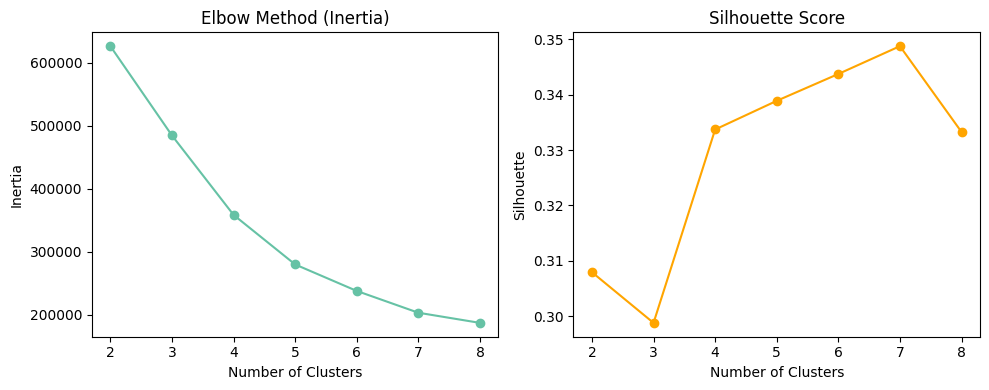


CLUSTER PERFORMANCE SUMMARY WITH ROI INTEGRATION

               Campaign_Count  Conversion_Rate_mean  Conversion_Rate_median  \
Cluster_Label                                                                 
Cluster_1              145155              0.080138                    0.08   
Cluster_2              154845              0.079889                    0.08   

               Conversion_Rate_std  Conversion_Rate_min  Conversion_Rate_max  \
Cluster_Label                                                                  
Cluster_1                 0.040591                 0.01                 0.15   
Cluster_2                 0.040537                 0.01                 0.15   

               Engagement_Score_mean  Engagement_Score_median  \
Cluster_Label                                                   
Cluster_1                   0.325946                 0.329976   
Cluster_2                   0.303103                 0.302416   

               Engagement_Score_std  Engagement_Sc

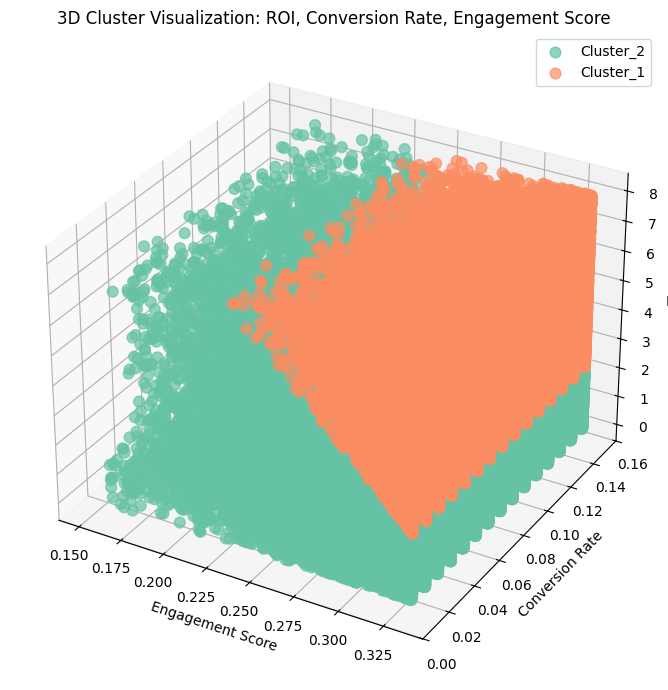

/tmp/ipython-input-1996276239.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


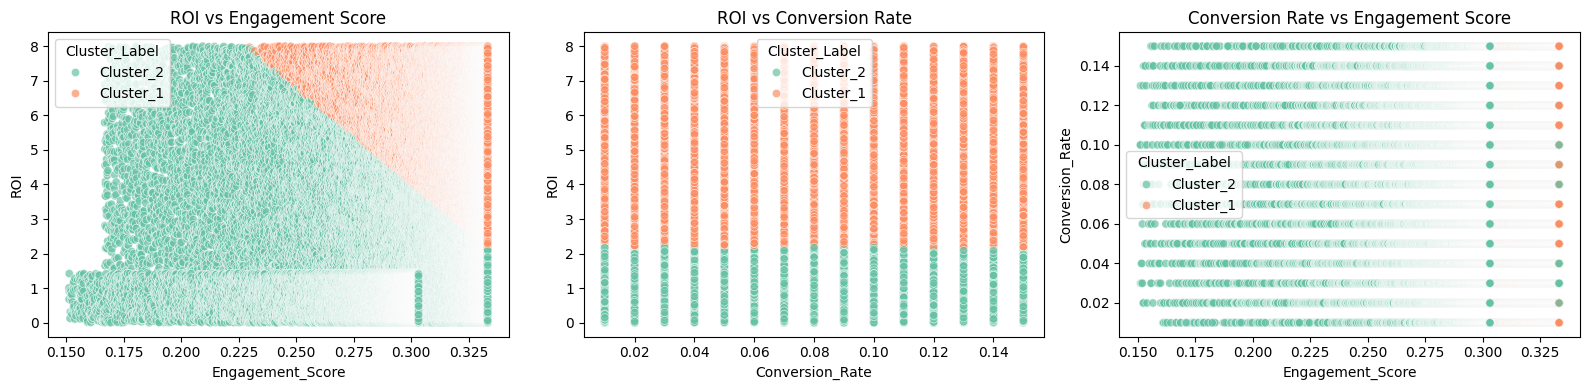

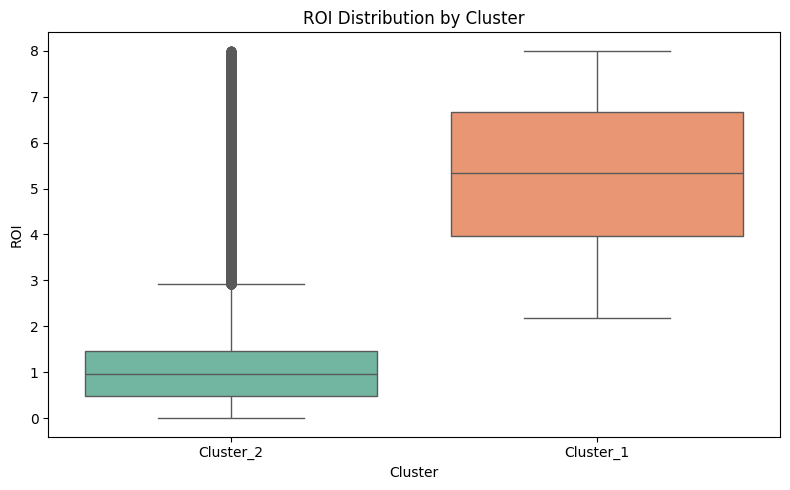


Elite Campaigns Identified: 8043 out of 300000 total campaigns

Top 10 Elite Campaigns (by ROI):
        Campaign_ID Cluster_Label  Conversion_Rate  Engagement_Score   ROI
271598       114610     Cluster_1             0.14          0.332896  8.00
294559       478788     Cluster_1             0.11          0.333251  8.00
228880       187771     Cluster_1             0.12          0.332040  8.00
289630       421107     Cluster_1             0.11          0.333178  8.00
256921       382753     Cluster_1             0.12          0.332639  8.00
203913       684073     Cluster_1             0.12          0.331386  8.00
238125       380367     Cluster_1             0.13          0.332255  8.00
250860       218243     Cluster_1             0.13          0.332523  8.00
201498       786589     Cluster_1             0.13          0.331315  7.99
296885       181903     Cluster_1             0.12          0.333277  7.99


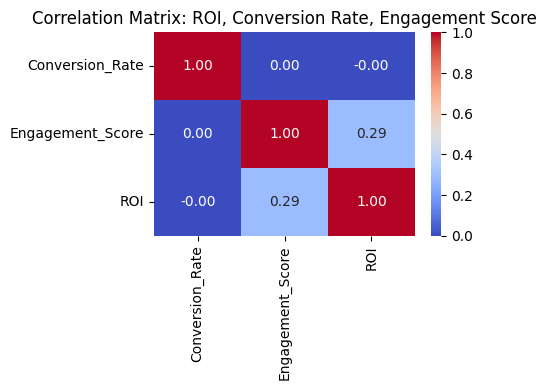


BUSINESS INSIGHTS & RECOMMENDATIONS

Cluster_1: HIGH PERFORMERS
  Avg ROI: 5.300, Conversion: 0.0801, Engagement: 0.33
  Recommendation: Scale these campaigns and use as blueprint for new campaigns

Cluster_2: LOW PERFORMERS
  Avg ROI: 1.188, Conversion: 0.0799, Engagement: 0.30
  Recommendation: Optimize or reallocate budget to higher-performing clusters


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Feature Selection: Add ROI to Clustering Features ---
features = ['Conversion_Rate', 'Engagement_Score', 'ROI']
X_cluster = df[features].copy()

# --- 2. Standardization ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# --- 3. Determine Optimal K (Elbow & Silhouette) ---
inertia = []
silhouette = []
K_range = range(2, 9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette')
plt.tight_layout()
plt.show()

# --- 4. Fit KMeans with Optimal K (choose based on elbow/silhouette, e.g., K=2) ---
OPTIMAL_K = 2
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df['Cluster_Label'] = kmeans.fit_predict(X_scaled)
df['Cluster_Label'] = df['Cluster_Label'].map(lambda x: f'Cluster_{x+1}')

# --- 5. Cluster Characterization (with ROI) ---
summary = df.groupby('Cluster_Label').agg(
    Campaign_Count=('Campaign_ID', 'count'),
    Conversion_Rate_mean=('Conversion_Rate', 'mean'),
    Conversion_Rate_median=('Conversion_Rate', 'median'),
    Conversion_Rate_std=('Conversion_Rate', 'std'),
    Conversion_Rate_min=('Conversion_Rate', 'min'),
    Conversion_Rate_max=('Conversion_Rate', 'max'),
    Engagement_Score_mean=('Engagement_Score', 'mean'),
    Engagement_Score_median=('Engagement_Score', 'median'),
    Engagement_Score_std=('Engagement_Score', 'std'),
    Engagement_Score_min=('Engagement_Score', 'min'),
    Engagement_Score_max=('Engagement_Score', 'max'),
    ROI_mean=('ROI', 'mean'),
    ROI_median=('ROI', 'median'),
    ROI_std=('ROI', 'std'),
    ROI_min=('ROI', 'min'),
    ROI_max=('ROI', 'max')
)
print("\nCLUSTER PERFORMANCE SUMMARY WITH ROI INTEGRATION\n")
print(summary)

# --- 6. 3D Scatter Plot: ROI, Conversion Rate, Engagement Score ---
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
for label, color in zip(df['Cluster_Label'].unique(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
    subset = df[df['Cluster_Label'] == label]
    ax.scatter(subset['Engagement_Score'], subset['Conversion_Rate'], subset['ROI'],
               label=label, alpha=0.7, s=60)
ax.set_xlabel('Engagement Score')
ax.set_ylabel('Conversion Rate')
ax.set_zlabel('ROI')
ax.set_title('3D Cluster Visualization: ROI, Conversion Rate, Engagement Score')
ax.legend()
plt.tight_layout()
plt.show()

# --- 7. 2D Projections ---
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.scatterplot(data=df, x='Engagement_Score', y='ROI', hue='Cluster_Label', alpha=0.7)
plt.title('ROI vs Engagement Score')
plt.subplot(1,3,2)
sns.scatterplot(data=df, x='Conversion_Rate', y='ROI', hue='Cluster_Label', alpha=0.7)
plt.title('ROI vs Conversion Rate')
plt.subplot(1,3,3)
sns.scatterplot(data=df, x='Engagement_Score', y='Conversion_Rate', hue='Cluster_Label', alpha=0.7)
plt.title('Conversion Rate vs Engagement Score')
plt.tight_layout()
plt.show()

# --- 8. ROI Boxplot by Cluster ---
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Cluster_Label', y='ROI', palette='Set2')
plt.title('ROI Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('ROI')
plt.tight_layout()
plt.show()

# --- 9. Elite Campaign Identification (Top 25% in ROI, Conversion Rate, Engagement Score) ---
roi_thresh = df['ROI'].quantile(0.75)
cr_thresh = df['Conversion_Rate'].quantile(0.75)
eng_thresh = df['Engagement_Score'].quantile(0.75)
elite_mask = (df['ROI'] >= roi_thresh) & (df['Conversion_Rate'] >= cr_thresh) & (df['Engagement_Score'] >= eng_thresh)
elite_campaigns = df[elite_mask]
print(f"\nElite Campaigns Identified: {elite_campaigns.shape[0]} out of {df.shape[0]} total campaigns")
print("\nTop 10 Elite Campaigns (by ROI):")
print(elite_campaigns.sort_values('ROI', ascending=False).head(10)[['Campaign_ID', 'Cluster_Label', 'Conversion_Rate', 'Engagement_Score', 'ROI']])

# --- 10. Correlation Matrix ---
corr = df[['Conversion_Rate', 'Engagement_Score', 'ROI']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: ROI, Conversion Rate, Engagement Score')
plt.tight_layout()
plt.show()

# --- 11. Business Insights ---
print("\nBUSINESS INSIGHTS & RECOMMENDATIONS")
for label, row in summary.iterrows():
    if row['ROI_mean'] > df['ROI'].mean():
        print(f"\n{label}: HIGH PERFORMERS\n  Avg ROI: {row['ROI_mean']:.3f}, Conversion: {row['Conversion_Rate_mean']:.4f}, Engagement: {row['Engagement_Score_mean']:.2f}")
        print("  Recommendation: Scale these campaigns and use as blueprint for new campaigns")
    else:
        print(f"\n{label}: LOW PERFORMERS\n  Avg ROI: {row['ROI_mean']:.3f}, Conversion: {row['Conversion_Rate_mean']:.4f}, Engagement: {row['Engagement_Score_mean']:.2f}")
        print("  Recommendation: Optimize or reallocate budget to higher-performing clusters")


**3 cluster approch with elite characterstics segmentration(New Changes)**


--- PHASE 3: UNSUPERVISED ANALYSIS ---
--- Q2: K-Means Clustering for Elite Campaign Blueprint (with ROI) ---


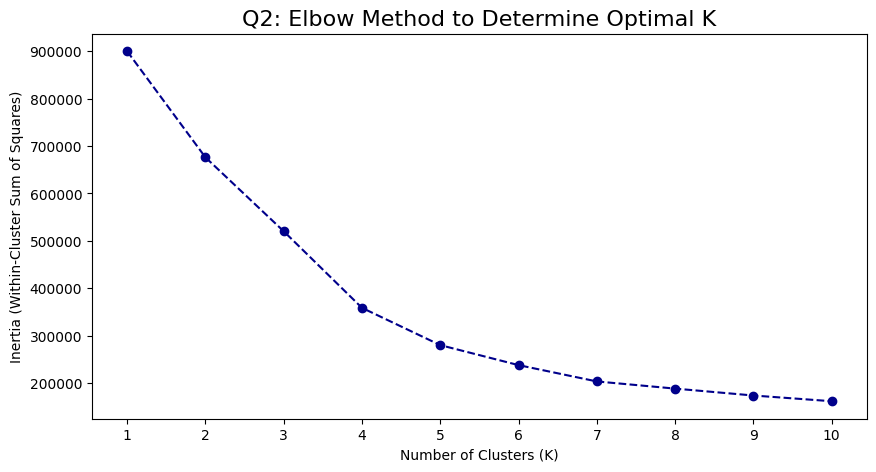


Optimal K selected: 3 (Typically the 'Elbow' point in the graph).

Cluster Performance Averages (with ROI):
                      ROI  Conversion_Rate  Engagement_Score
Cluster_Enhanced                                           
0                 3.1085           0.0449            0.3191
1                 3.4154           0.1153            0.3200
2                 2.2058           0.0802            0.2516

Elite Cluster Identified: Cluster 1
Composite Performance Score: 1.4865

--- Elite Campaign Blueprint (Most Frequent Characteristics) ---
Channel_Used                Twitter
Campaign_Goal       Brand Awareness
Target_Audience            All Ages
Customer_Segment               Home
Location                Los Angeles
Language                    Spanish
Duration_Days                  60.0
Gender                          Men
Age_Group                     18-24


/tmp/ipython-input-3534074446.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


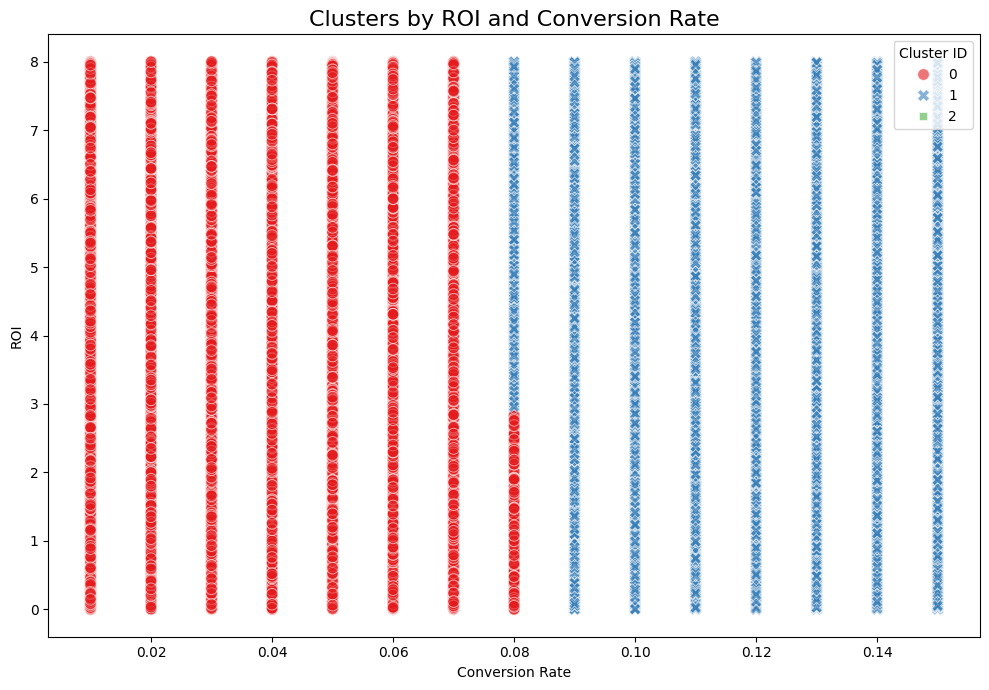

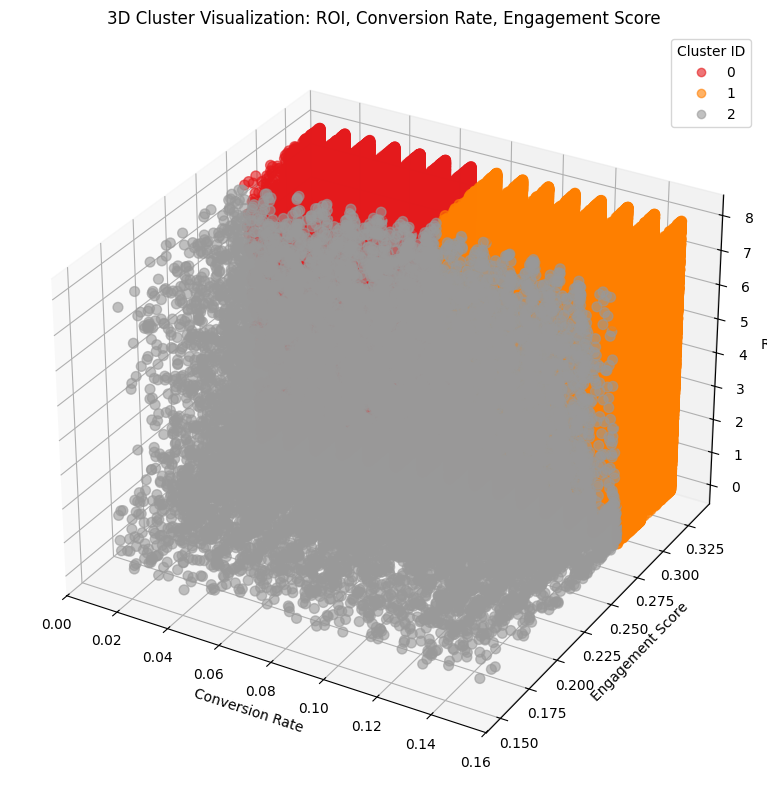


--- Analysis of Channel_Used ---
Chi-square statistic: 10137.6785
P-value: 0.000000 (Significant)
Cramér's V (effect size): 0.1299

Percentage distribution of Channel_Used within each cluster:
Cluster_Enhanced     0     1     2
Channel_Used                      
Facebook          25.3  26.3  16.3
Instagram         25.4  26.2  16.5
Pinterest         24.3  21.1  51.6
Twitter           25.0  26.4  15.6

Elite Cluster 1 vs Overall Population:
              Elite_Cluster_1_%  Overall_%  Difference  Over_Represented
Channel_Used                                                            
Facebook                  26.28      25.05        1.23             False
Instagram                 26.17      25.03        1.14             False
Pinterest                 21.14      25.03       -3.88             False
Twitter                   26.40      24.88        1.52             False
Most over-represented in elite cluster: Twitter (+1.5% vs overall population)

--- Analysis of Campaign_Goal ---
Chi-s

In [ ]:
# --- Q2: Enhanced K-Means Clustering for Elite Campaign Blueprint (with ROI) ---
print("\n" + "="*80)
print("--- PHASE 3: UNSUPERVISED ANALYSIS ---")
print("--- Q2: K-Means Clustering for Elite Campaign Blueprint (with ROI) ---")

# 1. Feature Selection: Now using ROI, Conversion_Rate, Engagement_Score
X_cluster = df[['ROI', 'Conversion_Rate', 'Engagement_Score']].copy()

# 2. Standardization (Scaling)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 3. Determine Optimal K (The Elbow Method)
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='darkblue')
plt.title('Q2: Elbow Method to Determine Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.show()

OPTIMAL_K = 3
print(f"\nOptimal K selected: {OPTIMAL_K} (Typically the 'Elbow' point in the graph).")

# 4. Apply K-Means with Optimal K
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
df['Cluster_Enhanced'] = kmeans_final.fit_predict(X_cluster_scaled)

# 5. Characterize the Clusters (Numerical)
cluster_means = df.groupby('Cluster_Enhanced')[['ROI', 'Conversion_Rate', 'Engagement_Score']].mean()
print("\nCluster Performance Averages (with ROI):\n", cluster_means.round(4))

# 6. Elite Cluster Identification (Composite Score)
performance_weights = {'ROI': 0.4, 'Conversion_Rate': 0.35, 'Engagement_Score': 0.25}
composite_scores = []
for cluster_id in cluster_means.index:
    score = sum(cluster_means.loc[cluster_id, metric] * weight
                for metric, weight in performance_weights.items())
    composite_scores.append(score)
cluster_means['Composite_Score'] = composite_scores
elite_cluster_id = cluster_means['Composite_Score'].argmax()
print(f"\nElite Cluster Identified: Cluster {elite_cluster_id}")
print(f"Composite Performance Score: {cluster_means.loc[elite_cluster_id, 'Composite_Score']:.4f}")

# 7. Elite Campaign Blueprint (Most Frequent Characteristics)
elite_campaigns = df[df['Cluster_Enhanced'] == elite_cluster_id]
elite_blueprint = elite_campaigns.mode(dropna=True).iloc[0]
blueprint_characteristics = elite_blueprint[['Channel_Used', 'Campaign_Goal', 'Target_Audience',
                                            'Customer_Segment', 'Location', 'Language',
                                            'Duration_Days', 'Gender', 'Age_Group']]
print("\n--- Elite Campaign Blueprint (Most Frequent Characteristics) ---")
print(blueprint_characteristics.to_string())

# 8. 2D and 3D Visualizations
import mpl_toolkits.mplot3d.axes3d as p3

# 2D: ROI vs. Conversion Rate, colored by cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Conversion_Rate', y='ROI', hue='Cluster_Enhanced', data=df,
    palette='Set1', style='Cluster_Enhanced', s=70, alpha=0.6
)
plt.title('Clusters by ROI and Conversion Rate', fontsize=16)
plt.xlabel('Conversion Rate')
plt.ylabel('ROI')
plt.legend(title='Cluster ID')
plt.tight_layout()
plt.show()

# 3D: ROI, Conversion Rate, Engagement Score
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df['Conversion_Rate'], df['Engagement_Score'], df['ROI'],
    c=df['Cluster_Enhanced'], cmap='Set1', s=50, alpha=0.6
)
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Engagement Score')
ax.set_zlabel('ROI')
ax.set_title('3D Cluster Visualization: ROI, Conversion Rate, Engagement Score')
plt.legend(*scatter.legend_elements(), title="Cluster ID")
plt.tight_layout()
plt.show()

# 9. Advanced Statistical Analysis (Chi-square, Cramér's V)
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical association"""
    try:
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    except:
        return 0.0

def analyze_categorical_association(categorical_var, cluster_col):
    contingency_table = pd.crosstab(df[categorical_var], df[cluster_col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    cramers = cramers_v(df[categorical_var], df[cluster_col])
    cluster_percentages = pd.crosstab(df[categorical_var], df[cluster_col], normalize='columns') * 100
    return {
        'contingency_table': contingency_table,
        'chi2_stat': chi2,
        'p_value': p_value,
        'cramers_v': cramers,
        'cluster_percentages': cluster_percentages,
        'is_significant': p_value < 0.05
    }

categorical_vars = ['Channel_Used', 'Campaign_Goal', 'Customer_Segment',
                   'Target_Audience', 'Location', 'Language', 'Gender', 'Age_Group']

for var in categorical_vars:
    print(f"\n--- Analysis of {var} ---")
    result = analyze_categorical_association(var, 'Cluster_Enhanced')
    print(f"Chi-square statistic: {result['chi2_stat']:.4f}")
    print(f"P-value: {result['p_value']:.6f} {'(Significant)' if result['is_significant'] else '(Not Significant)'}")
    print(f"Cramér's V (effect size): {result['cramers_v']:.4f}")
    print(f"\nPercentage distribution of {var} within each cluster:")
    print(result['cluster_percentages'].round(1))
    elite_percentages = result['cluster_percentages'][elite_cluster_id]
    overall_percentages = (df[var].value_counts() / len(df) * 100)
    comparison_df = pd.DataFrame({
        f'Elite_Cluster_{elite_cluster_id}_%': elite_percentages,
        'Overall_%': overall_percentages.reindex(elite_percentages.index, fill_value=0),
    })
    comparison_df['Difference'] = comparison_df[f'Elite_Cluster_{elite_cluster_id}_%'] - comparison_df['Overall_%']
    comparison_df['Over_Represented'] = comparison_df['Difference'] > 2
    print(f"\nElite Cluster {elite_cluster_id} vs Overall Population:")
    print(comparison_df.round(2))
    max_diff_idx = comparison_df['Difference'].argmax()
    most_distinctive_char = comparison_df.index[max_diff_idx]
    max_diff_value = comparison_df.iloc[max_diff_idx]['Difference']
    print(f"Most over-represented in elite cluster: {most_distinctive_char} "
          f"(+{max_diff_value:.1f}% vs overall population)")


**Distribution of features -updated**

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3364061076.py:4: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].astype(str).replace('[\$,]', '', regex=True).astype(float)


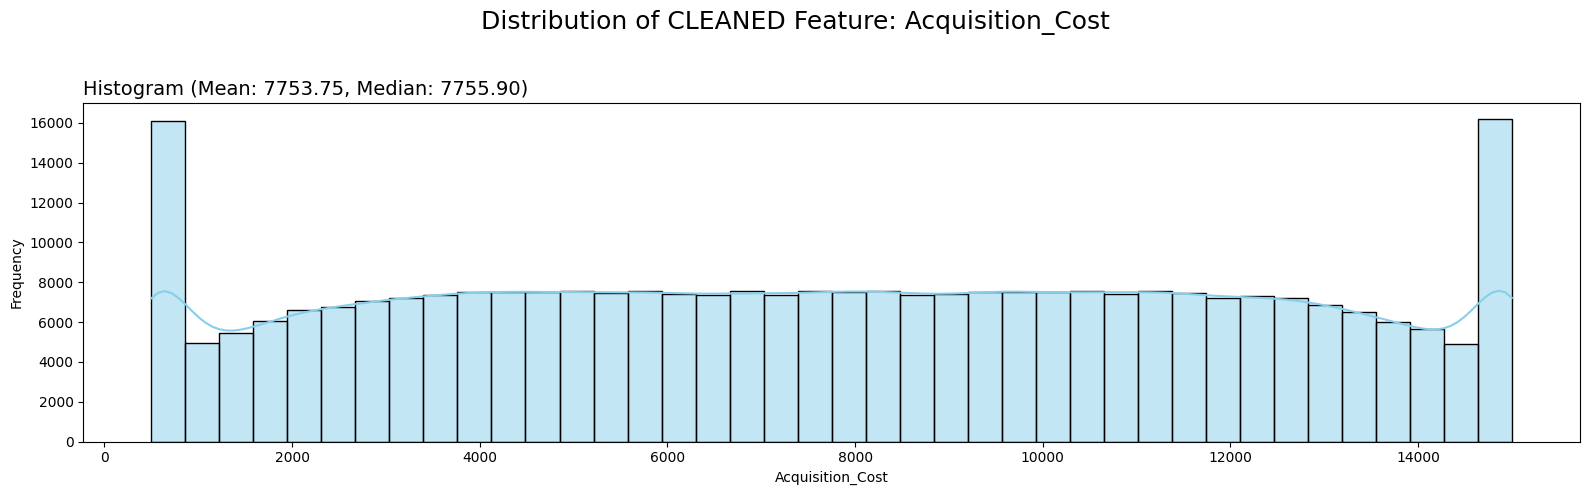

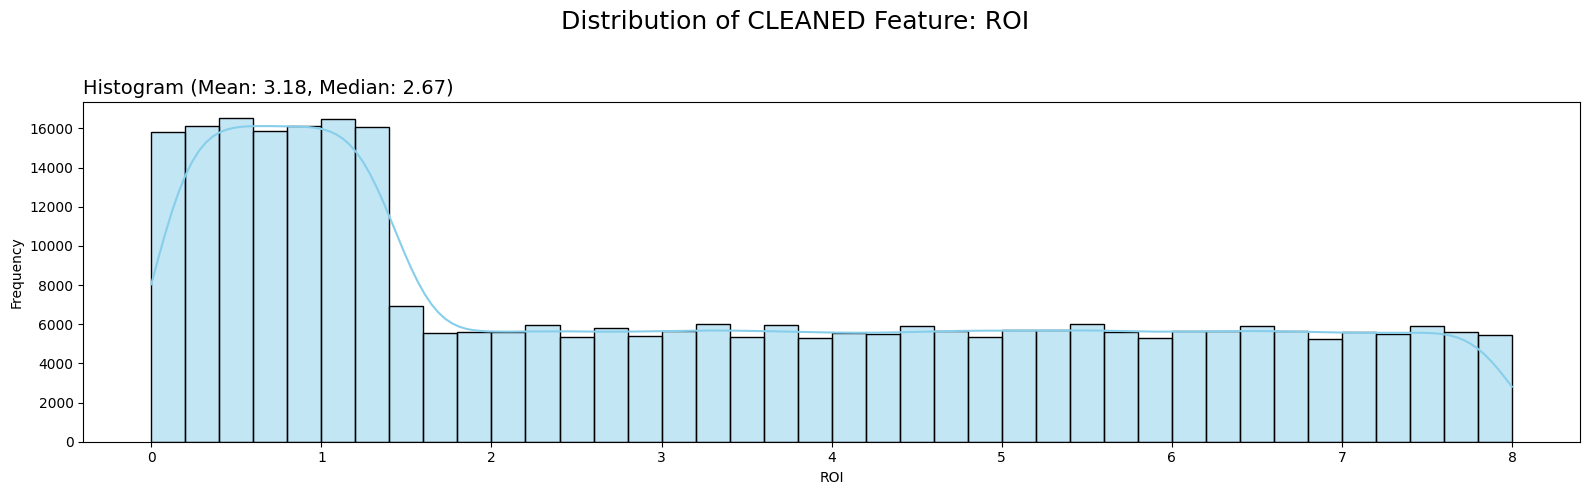

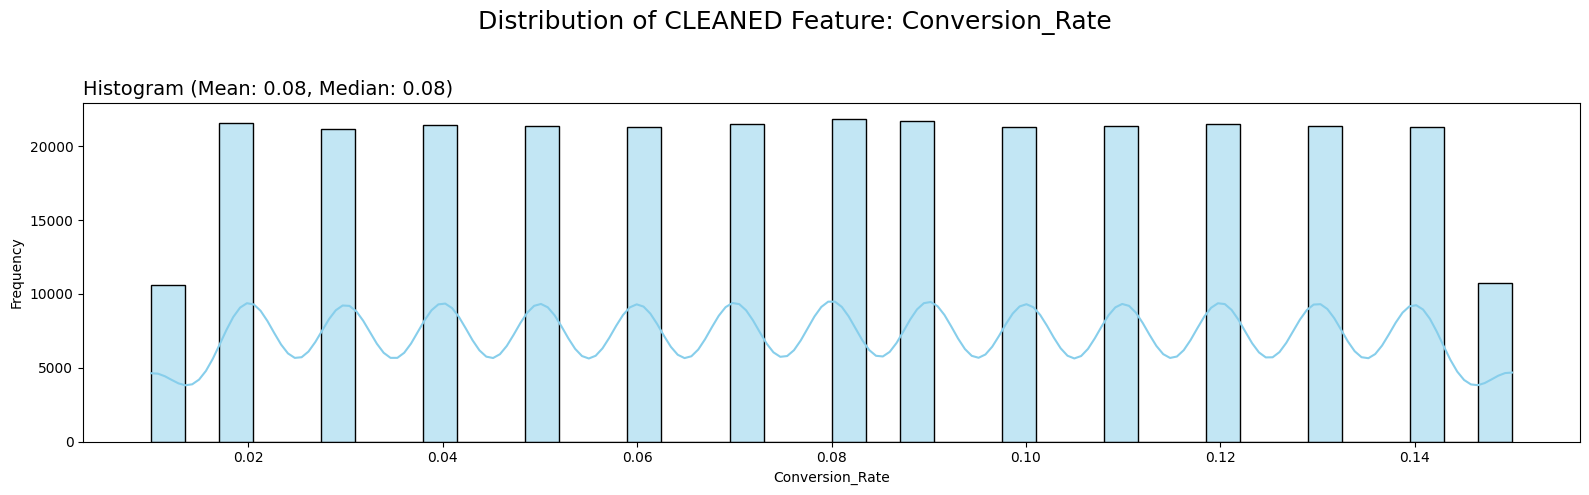

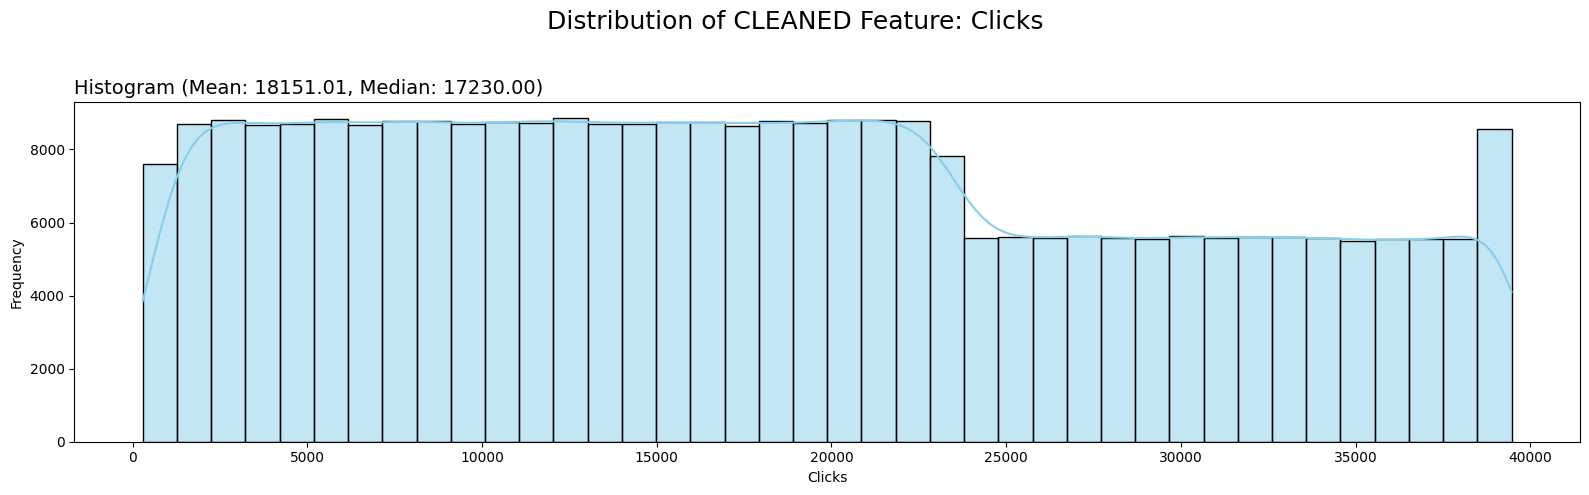

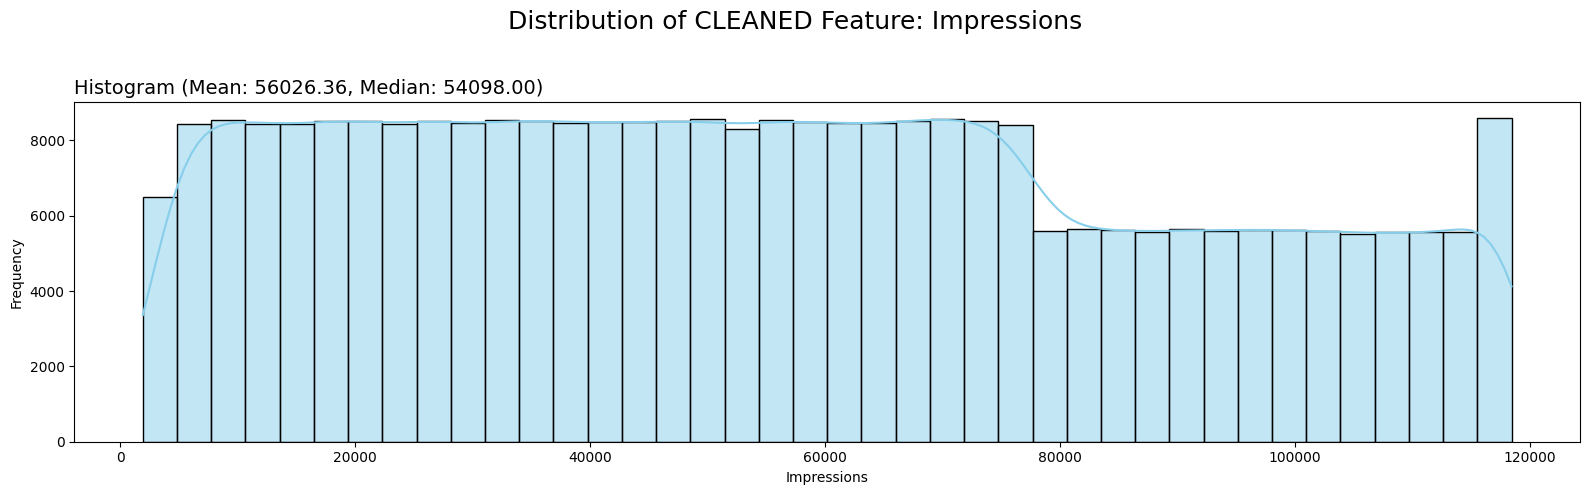

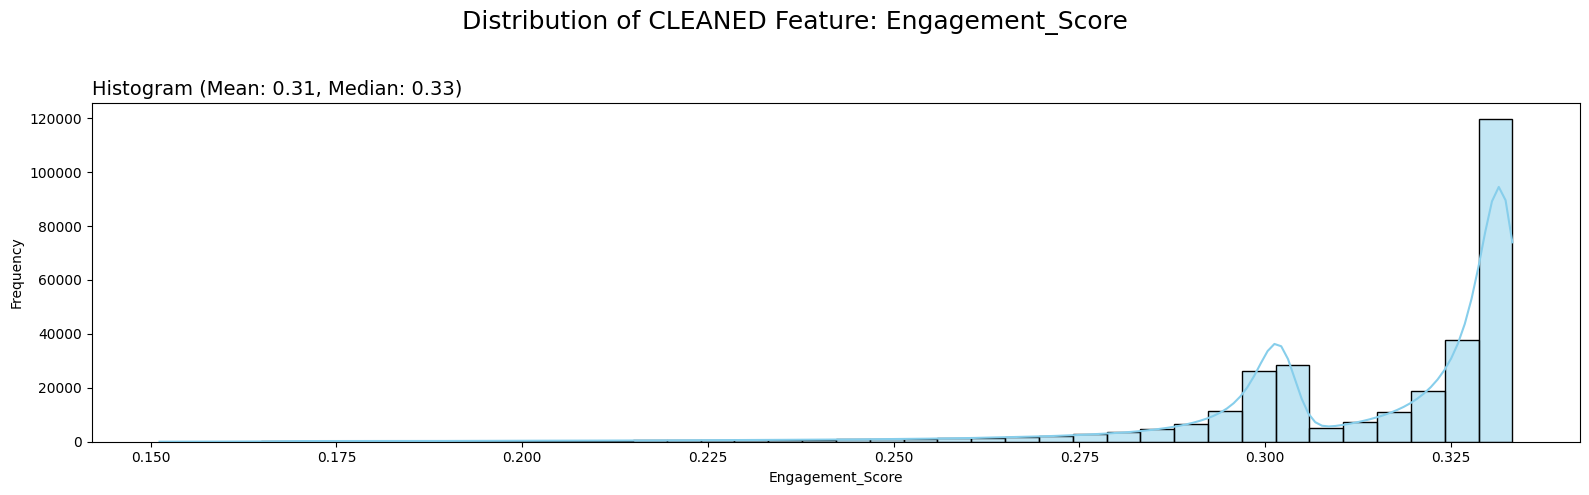

In [ ]:
# Example: If your columns have $ or commas, clean them
for col in ['Acquisition_Cost', 'ROI', 'Conversion_Rate']:
    # Remove $ and commas, then convert to float
    df[col] = df[col].astype(str).replace('[\$,]', '', regex=True).astype(float)

# List of features to plot
features = ['Acquisition_Cost', 'ROI', 'Conversion_Rate','Clicks','Impressions','Engagement_Score']

for feature in features:
    plt.figure(figsize=(16, 5))
    mean = df[feature].mean()
    median = df[feature].median()
    ax = sns.histplot(df[feature], bins=40, kde=True, color='skyblue')
    ax.set_title(f'Histogram (Mean: {mean:.2f}, Median: {median:.2f})', fontsize=14, loc='left')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    plt.suptitle(f'Distribution of CLEANED Feature: {feature}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



**Q4-Old version** **( 'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language','Customer_Segment', 'Segment_Goal_Interaction')**

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
import sys

# --- Configuration & Setup (Mandatory) ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings("ignore", category=UserWarning)
Q4_RESULTS = {}
# NOTE: Using known best parameters from previous runs to skip GridSearchCV
KNOWN_BEST_PARAMS = {
    'XGBoost': {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
    'LR': {'C': 10},
    'RF': {'n_estimators': 100, 'max_depth': 10}
}


# --- 1. Data Loading and Feature Engineering (Mandatory) ---
print("--- 1. Data Loading, Preprocessing, and Splitting ---")
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Web and social/Social_Media_Advertising.csv')
except FileNotFoundError:
    print("FATAL ERROR: Could not find the CSV file. Please verify path.")
    sys.exit(1)

numeric_cols_to_clean = ['Clicks', 'Impressions', 'Acquisition_Cost']
for col in numeric_cols_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)

if 'Duration' in df.columns:
    df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int, errors='ignore').fillna(0)
    df.drop(columns=['Duration'], inplace=True, errors='ignore')
else:
    df['Duration_Days'] = 0.0

if all(col in df.columns for col in ['Customer_Segment', 'Campaign_Goal']):
    df['Segment_Goal_Interaction'] = df['Customer_Segment'].astype(str) + '_' + df['Campaign_Goal'].astype(str)
else:
    df['Segment_Goal_Interaction'] = 'Unknown'

# Split Target_Audience into Gender and Age_Group (re-adding this as it's needed for Age_Group, Gender features)
if 'Target_Audience' in df.columns:
    df[['Gender', 'Age_Group']] = df['Target_Audience'].str.extract(r'(Men|Women)\s+([\d\-]+)')
    df['Gender'].fillna('Unknown', inplace=True)
    df['Age_Group'].fillna('Unknown', inplace=True)
else:
    # Fallback if Target_Audience is not present
    df['Gender'] = 'Unknown'
    df['Age_Group'] = 'Unknown'


PLANNING_FEATURES = [
    'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language',
    'Customer_Segment', 'Segment_Goal_Interaction'
]
PREDICTIVE_FEATURES_Q4 = [f for f in ['Duration_Days'] + PLANNING_FEATURES if f in df.columns]

numeric_features_q4 = [f for f in ['Duration_Days'] if f in PREDICTIVE_FEATURES_Q4]
categorical_features_q4 = [f for f in PLANNING_FEATURES if f in PREDICTIVE_FEATURES_Q4]

df['Conversion_Success'] = (df['Conversion_Rate'] >= 0.10).astype(int) # Changed threshold back to 0.10
X_q4 = df[PREDICTIVE_FEATURES_Q4].copy()
y_q4 = df['Conversion_Success']

preprocessor_q4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_q4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_q4)
    ],
    remainder='passthrough'
)

X_train_q4, X_test_q4, y_train_q4, y_test_q4 = train_test_split(
    X_q4, y_q4, test_size=0.3, random_state=SEED, stratify=y_q4
)

print(f"Features used for Planning Model: {PREDICTIVE_FEATURES_Q4}")
print("================================================================================")
print("--- 2. Direct Model Training (Skipping GridSearch for speed) ---")


# --- HELPER FUNCTION 1: GET FEATURE NAMES AFTER PREPROCESSING ---
def get_feature_names(column_transformer):
    """Retrieves feature names after one-hot encoding."""
    output_features = []
    for name, step, original_cols in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(original_cols)
        elif name == 'cat':
            if hasattr(step, 'get_feature_names_out'):
                output_features.extend(step.get_feature_names_out(original_cols))
            else:
                for i, col in enumerate(original_cols):
                    categories = step.categories_[i]
                    output_features.extend([f"{col}_{cat}" for cat in categories])
    return output_features

# --- HELPER FUNCTION 2: CALCULATE LEARNING CURVE DATA ---
def calculate_learning_curve_data(pipeline, X, y, scoring='roc_auc', cv=3):
    """Calculates training and cross-validation scores across different training set sizes."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=SEED
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    return {
        'train_sizes': train_sizes.tolist(),
        'train_scores_mean': train_scores_mean.tolist(),
        'val_scores_mean': test_scores_mean.tolist()
    }


# --- 2a. Model 1: XGBoost Classifier (Direct Train) ---
xgb_params = KNOWN_BEST_PARAMS['XGBoost']
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', random_state=SEED,
    use_label_encoder=False, **xgb_params
)
best_q4_model_xgb = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', xgb_classifier)
])
best_q4_model_xgb.fit(X_train_q4, y_train_q4)
roc_auc_q4_xgb = roc_auc_score(y_test_q4, best_q4_model_xgb.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['XGBoost (Optimized)'] = {'ROC AUC': roc_auc_q4_xgb, 'Model': best_q4_model_xgb, 'Best Params': xgb_params}
print(f"XGBoost trained directly with params: {xgb_params}. ROC AUC: {roc_auc_q4_xgb:.4f}")

# --- 2b. Model 2: Logistic Regression (Direct Train) ---
lr_params = KNOWN_BEST_PARAMS['LR']
lr_classifier = LogisticRegression(solver='liblinear', random_state=SEED, max_iter=1000, **lr_params)
best_q4_model_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', lr_classifier)
])
best_q4_model_lr.fit(X_train_q4, y_train_q4)
roc_auc_q4_lr = roc_auc_score(y_test_q4, best_q4_model_lr.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['Logistic Regression (Optimized)'] = {'ROC AUC': roc_auc_q4_lr, 'Model': best_q4_model_lr, 'Best Params': lr_params}
print(f"Logistic Regression trained directly with params: {lr_params}. ROC AUC: {roc_auc_q4_lr:.4f}")

# --- 2c. Model 3: Random Forest Classifier (Direct Train) ---
rf_params = KNOWN_BEST_PARAMS['RF']
rf_classifier = RandomForestClassifier(random_state=SEED, **rf_params)
best_q4_model_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', rf_classifier)
])
best_q4_model_rf.fit(X_train_q4, y_train_q4)
roc_auc_q4_rf = roc_auc_score(y_test_q4, best_q4_model_rf.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['Random Forest (Optimized)'] = {'ROC AUC': roc_auc_q4_rf, 'Model': best_q4_model_rf, 'Best Params': rf_params}
print(f"Random Forest trained directly with params: {rf_params}. ROC AUC: {roc_auc_q4_rf:.4f}")


# --- 3. Deep Dive Analysis: Metrics, Curves, Feature Importance, and Learning Curves ---
print("\n================================================================================")
print("--- 3. DETAILED MODEL ANALYSIS (Data for Plots) ---")
feature_names = get_feature_names(preprocessor_q4)

# Create a dictionary to hold all data points needed for plotting
PLOT_DATA = {'ROC': {}, 'PR': {}, 'Learning_Curves': {}}

for model_name, result_data in Q4_RESULTS.items():
    model = result_data['Model']
    y_proba = model.predict_proba(X_test_q4)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    print(f"\n--- Model: {model_name} ---")

    # 3a. Key Metrics
    current_roc_auc = roc_auc_score(y_test_q4, y_proba)
    print(f"• Test Set ROC AUC: {current_roc_auc:.4f}")

    # 3b. Confusion Matrix & Classification Report
    cm = confusion_matrix(y_test_q4, y_pred)
    print("\n• Confusion Matrix (Actual vs. Predicted):")
    print(f"   [[True Negatives ({cm[0, 0]})  False Positives ({cm[0, 1]})]")
    print(f"    [False Negatives ({cm[1, 0]})  True Positives ({cm[1, 1]})]]")
    print("\n• Classification Report:")
    print(classification_report(y_test_q4, y_pred, target_names=['Unsuccessful (0)', 'Successful (1)']))

    # 3c. ROC Curve Data (For Plotting)
    fpr, tpr, _ = roc_curve(y_test_q4, y_proba)
    PLOT_DATA['ROC'][model_name] = {'fpr': fpr.tolist(), 'tpr': tpr.tolist()}
    print(f"• ROC Curve Data Points generated for plotting.")

    # 3d. PR Curve Data (For Plotting)
    precision, recall, _ = precision_recall_curve(y_test_q4, y_proba)
    pr_auc = auc(recall, precision)
    PLOT_DATA['PR'][model_name] = {'precision': precision.tolist(), 'recall': recall.tolist()}
    print(f"• PR AUC Score: {pr_auc:.4f}. PR Curve Data Points generated for plotting.")

    # 3e. Feature Importance / Coefficients (For Plotting/Display)
    final_classifier = model.named_steps['classifier']

    if isinstance(final_classifier, (xgb.XGBClassifier, RandomForestClassifier)):
        # Tree-based model
        importance_scores = final_classifier.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_scores
        }).sort_values(by='Importance', ascending=False)

        print("\n• Top 10 Feature Importances (Tree Models):")
        print(feature_importance_df.head(10).to_markdown(index=False, floatfmt=".5f"))

    elif isinstance(final_classifier, LogisticRegression):
        # Linear model
        coefficients = final_classifier.coef_[0] if final_classifier.coef_.ndim > 1 else final_classifier.coef_
        coefficient_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        coefficient_df['Abs_Coefficient'] = coefficient_df['Coefficient'].abs()
        coefficient_df = coefficient_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])

        print("\n• Top 10 Coefficients (Logistic Regression):")
        print(coefficient_df.head(10).to_markdown(index=False, floatfmt=".5f"))

    # 3f. Learning Curve Data (For Plotting)
    print("\n• Generating Learning Curve Data (ROC AUC)...")
    lc_data = calculate_learning_curve_data(model, X_train_q4, y_train_q4, scoring='roc_auc', cv=3)
    PLOT_DATA['Learning_Curves'][model_name] = lc_data

    lc_df = pd.DataFrame({
        'Train Size': lc_data['train_sizes'],
        'Train Score (Mean)': lc_data['train_scores_mean'],
        'Validation Score (Mean)': lc_data['val_scores_mean']
    })
    print(lc_df.to_markdown(index=False, floatfmt=".4f"))


print("\nALL ANALYSIS DATA GENERATED.")

<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-288476509.py:48: SyntaxWarning: invalid escape sequence '\d'
  df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int, errors='ignore').fillna(0)


--- 1. Data Loading, Preprocessing, and Splitting ---
Features used for Planning Model: ['Duration_Days', 'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language', 'Customer_Segment', 'Segment_Goal_Interaction']
--- 2. Direct Model Training (Skipping GridSearch for speed) ---
XGBoost trained directly with params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}. ROC AUC: 0.5023
Logistic Regression trained directly with params: {'C': 10}. ROC AUC: 0.4980
Random Forest trained directly with params: {'n_estimators': 100, 'max_depth': 10}. ROC AUC: 0.5020

--- 3. DETAILED MODEL ANALYSIS (Data for Plots) ---

--- Model: XGBoost (Optimized) ---
• Test Set ROC AUC: 0.5023

• Confusion Matrix (Actual vs. Predicted):
   [[True Negatives (30339)  False Positives (24404)]
    [False Negatives (19402)  True Positives (15855)]]

• Classification Report:
                  precision    recall  f1-score   support

Unsuccessful (0)       0.61      0.55      0.58     54743
  Successful 

**Q4 with new features-updated** **( 'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language','Customer_Segment', 'Segment_Goal_Interaction','Clicks','Impressions','Engagement_Score', 'Acquisition_Cost', 'ROI','Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression')**

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
import sys

# --- Configuration & Setup (Mandatory) ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings("ignore", category=UserWarning)
Q4_RESULTS = {}
# NOTE: Using known best parameters from previous runs to skip GridSearchCV
KNOWN_BEST_PARAMS = {
    'XGBoost': {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
    'LR': {'C': 10},
    'RF': {'n_estimators': 100, 'max_depth': 10}
}


# --- 1. Data Loading and Feature Engineering (Mandatory) ---
print("--- 1. Data Loading, Preprocessing, and Splitting ---")
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Web and social/Social_Media_Advertising.csv')
except FileNotFoundError:
    print("FATAL ERROR: Could not find the CSV file. Please verify path.")
    sys.exit(1)

numeric_cols_to_clean = ['Clicks', 'Impressions', 'Acquisition_Cost']
for col in numeric_cols_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)

if 'Duration' in df.columns:
    df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int, errors='ignore').fillna(0)
    df.drop(columns=['Duration'], inplace=True, errors='ignore')
else:
    df['Duration_Days'] = 0.0

if all(col in df.columns for col in ['Customer_Segment', 'Campaign_Goal']):
    df['Segment_Goal_Interaction'] = df['Customer_Segment'].astype(str) + '_' + df['Campaign_Goal'].astype(str)
else:
    df['Segment_Goal_Interaction'] = 'Unknown'

# Split Target_Audience into Gender and Age_Group (re-adding this as it's needed for Age_Group, Gender features)
if 'Target_Audience' in df.columns:
    df[['Gender', 'Age_Group']] = df['Target_Audience'].str.extract(r'(Men|Women)\s+([\d\-]+)')
    df['Gender'].fillna('Unknown', inplace=True)
    df['Age_Group'].fillna('Unknown', inplace=True)
else:
    # Fallback if Target_Audience is not present
    df['Gender'] = 'Unknown'
    df['Age_Group'] = 'Unknown'


PLANNING_FEATURES = [
    'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language',
    'Customer_Segment', 'Segment_Goal_Interaction','Clicks','Impressions','Engagement_Score', 'Acquisition_Cost', 'ROI','Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression'
]
PREDICTIVE_FEATURES_Q4 = [f for f in ['Duration_Days'] + PLANNING_FEATURES if f in df.columns]

numeric_features_q4 = [f for f in ['Duration_Days'] if f in PREDICTIVE_FEATURES_Q4]
categorical_features_q4 = [f for f in PLANNING_FEATURES if f in PREDICTIVE_FEATURES_Q4]

df['Conversion_Success'] = (df['Conversion_Rate'] >= 0.10).astype(int) # Changed threshold back to 0.10
X_q4 = df[PREDICTIVE_FEATURES_Q4].copy()
y_q4 = df['Conversion_Success']

preprocessor_q4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_q4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_q4)
    ],
    remainder='passthrough'
)

X_train_q4, X_test_q4, y_train_q4, y_test_q4 = train_test_split(
    X_q4, y_q4, test_size=0.3, random_state=SEED, stratify=y_q4
)

print(f"Features used for Planning Model: {PREDICTIVE_FEATURES_Q4}")
print("================================================================================")
print("--- 2. Direct Model Training (Skipping GridSearch for speed) ---")


# --- HELPER FUNCTION 1: GET FEATURE NAMES AFTER PREPROCESSING ---
def get_feature_names(column_transformer):
    """Retrieves feature names after one-hot encoding."""
    output_features = []
    for name, step, original_cols in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(original_cols)
        elif name == 'cat':
            if hasattr(step, 'get_feature_names_out'):
                output_features.extend(step.get_feature_names_out(original_cols))
            else:
                for i, col in enumerate(original_cols):
                    categories = step.categories_[i]
                    output_features.extend([f"{col}_{cat}" for cat in categories])
    return output_features

# --- HELPER FUNCTION 2: CALCULATE LEARNING CURVE DATA ---
def calculate_learning_curve_data(pipeline, X, y, scoring='roc_auc', cv=3):
    """Calculates training and cross-validation scores across different training set sizes."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=SEED
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    return {
        'train_sizes': train_sizes.tolist(),
        'train_scores_mean': train_scores_mean.tolist(),
        'val_scores_mean': test_scores_mean.tolist()
    }


# --- 2a. Model 1: XGBoost Classifier (Direct Train) ---
xgb_params = KNOWN_BEST_PARAMS['XGBoost']
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', random_state=SEED,
    use_label_encoder=False, **xgb_params
)
best_q4_model_xgb = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', xgb_classifier)
])
best_q4_model_xgb.fit(X_train_q4, y_train_q4)
roc_auc_q4_xgb = roc_auc_score(y_test_q4, best_q4_model_xgb.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['XGBoost (Optimized)'] = {'ROC AUC': roc_auc_q4_xgb, 'Model': best_q4_model_xgb, 'Best Params': xgb_params}
print(f"XGBoost trained directly with params: {xgb_params}. ROC AUC: {roc_auc_q4_xgb:.4f}")

# --- 2b. Model 2: Logistic Regression (Direct Train) ---
lr_params = KNOWN_BEST_PARAMS['LR']
lr_classifier = LogisticRegression(solver='liblinear', random_state=SEED, max_iter=1000, **lr_params)
best_q4_model_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', lr_classifier)
])
best_q4_model_lr.fit(X_train_q4, y_train_q4)
roc_auc_q4_lr = roc_auc_score(y_test_q4, best_q4_model_lr.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['Logistic Regression (Optimized)'] = {'ROC AUC': roc_auc_q4_lr, 'Model': best_q4_model_lr, 'Best Params': lr_params}
print(f"Logistic Regression trained directly with params: {lr_params}. ROC AUC: {roc_auc_q4_lr:.4f}")

# --- 2c. Model 3: Random Forest Classifier (Direct Train) ---
rf_params = KNOWN_BEST_PARAMS['RF']
rf_classifier = RandomForestClassifier(random_state=SEED, **rf_params)
best_q4_model_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', rf_classifier)
])
best_q4_model_rf.fit(X_train_q4, y_train_q4)
roc_auc_q4_rf = roc_auc_score(y_test_q4, best_q4_model_rf.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['Random Forest (Optimized)'] = {'ROC AUC': roc_auc_q4_rf, 'Model': best_q4_model_rf, 'Best Params': rf_params}
print(f"Random Forest trained directly with params: {rf_params}. ROC AUC: {roc_auc_q4_rf:.4f}")


# --- 3. Deep Dive Analysis: Metrics, Curves, Feature Importance, and Learning Curves ---
print("\n================================================================================")
print("--- 3. DETAILED MODEL ANALYSIS (Data for Plots) ---")
feature_names = get_feature_names(preprocessor_q4)

# Create a dictionary to hold all data points needed for plotting
PLOT_DATA = {'ROC': {}, 'PR': {}, 'Learning_Curves': {}}

for model_name, result_data in Q4_RESULTS.items():
    model = result_data['Model']
    y_proba = model.predict_proba(X_test_q4)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    print(f"\n--- Model: {model_name} ---")

    # 3a. Key Metrics
    current_roc_auc = roc_auc_score(y_test_q4, y_proba)
    print(f"• Test Set ROC AUC: {current_roc_auc:.4f}")

    # 3b. Confusion Matrix & Classification Report
    cm = confusion_matrix(y_test_q4, y_pred)
    print("\n• Confusion Matrix (Actual vs. Predicted):")
    print(f"   [[True Negatives ({cm[0, 0]})  False Positives ({cm[0, 1]})]")
    print(f"    [False Negatives ({cm[1, 0]})  True Positives ({cm[1, 1]})]]")
    print("\n• Classification Report:")
    print(classification_report(y_test_q4, y_pred, target_names=['Unsuccessful (0)', 'Successful (1)']))

    # 3c. ROC Curve Data (For Plotting)
    fpr, tpr, _ = roc_curve(y_test_q4, y_proba)
    PLOT_DATA['ROC'][model_name] = {'fpr': fpr.tolist(), 'tpr': tpr.tolist()}
    print(f"• ROC Curve Data Points generated for plotting.")

    # 3d. PR Curve Data (For Plotting)
    precision, recall, _ = precision_recall_curve(y_test_q4, y_proba)
    pr_auc = auc(recall, precision)
    PLOT_DATA['PR'][model_name] = {'precision': precision.tolist(), 'recall': recall.tolist()}
    print(f"• PR AUC Score: {pr_auc:.4f}. PR Curve Data Points generated for plotting.")

    # 3e. Feature Importance / Coefficients (For Plotting/Display)
    final_classifier = model.named_steps['classifier']

    if isinstance(final_classifier, (xgb.XGBClassifier, RandomForestClassifier)):
        # Tree-based model
        importance_scores = final_classifier.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_scores
        }).sort_values(by='Importance', ascending=False)

        print("\n• Top 10 Feature Importances (Tree Models):")
        print(feature_importance_df.head(10).to_markdown(index=False, floatfmt=".5f"))

    elif isinstance(final_classifier, LogisticRegression):
        # Linear model
        coefficients = final_classifier.coef_[0] if final_classifier.coef_.ndim > 1 else final_classifier.coef_
        coefficient_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        coefficient_df['Abs_Coefficient'] = coefficient_df['Coefficient'].abs()
        coefficient_df = coefficient_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])

        print("\n• Top 10 Coefficients (Logistic Regression):")
        print(coefficient_df.head(10).to_markdown(index=False, floatfmt=".5f"))

    # 3f. Learning Curve Data (For Plotting)
    print("\n• Generating Learning Curve Data (ROC AUC)...")
    lc_data = calculate_learning_curve_data(model, X_train_q4, y_train_q4, scoring='roc_auc', cv=3)
    PLOT_DATA['Learning_Curves'][model_name] = lc_data

    lc_df = pd.DataFrame({
        'Train Size': lc_data['train_sizes'],
        'Train Score (Mean)': lc_data['train_scores_mean'],
        'Validation Score (Mean)': lc_data['val_scores_mean']
    })
    print(lc_df.to_markdown(index=False, floatfmt=".4f"))


print("\nALL ANALYSIS DATA GENERATED.")

<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1258130476.py:48: SyntaxWarning: invalid escape sequence '\d'
  df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int, errors='ignore').fillna(0)


--- 1. Data Loading, Preprocessing, and Splitting ---
Features used for Planning Model: ['Duration_Days', 'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language', 'Customer_Segment', 'Segment_Goal_Interaction', 'Clicks', 'Impressions', 'Engagement_Score', 'Acquisition_Cost', 'ROI']
--- 2. Direct Model Training (Skipping GridSearch for speed) ---
XGBoost trained directly with params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}. ROC AUC: 0.4985
Logistic Regression trained directly with params: {'C': 10}. ROC AUC: 0.5030
Random Forest trained directly with params: {'n_estimators': 100, 'max_depth': 10}. ROC AUC: 0.5032

--- 3. DETAILED MODEL ANALYSIS (Data for Plots) ---

--- Model: XGBoost (Optimized) ---
• Test Set ROC AUC: 0.4985

• Confusion Matrix (Actual vs. Predicted):
   [[True Negatives (54727)  False Positives (16)]
    [False Negatives (35246)  True Positives (11)]]

• Classification Report:
                  precision    recall  f1-score   support

Unsuc

**Q4 with features ('Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language','Customer_Segment', 'Segment_Goal_Interaction','Clicks','Impressions','Engagement_Score','Click_Through_Rate', 'Cost_Per_Click','Cost_Per_Impression') -updated **


In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
import sys

# --- Configuration & Setup (Mandatory) ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings("ignore", category=UserWarning)
Q4_RESULTS = {}
# NOTE: Using known best parameters from previous runs to skip GridSearchCV
KNOWN_BEST_PARAMS = {
    'XGBoost': {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
    'LR': {'C': 10},
    'RF': {'n_estimators': 100, 'max_depth': 10}
}


# --- 1. Data Loading and Feature Engineering (Mandatory) ---
print("--- 1. Data Loading, Preprocessing, and Splitting ---")
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Web and social/Social_Media_Advertising.csv')
except FileNotFoundError:
    print("FATAL ERROR: Could not find the CSV file. Please verify path.")
    sys.exit(1)

numeric_cols_to_clean = ['Clicks', 'Impressions', 'Acquisition_Cost']
for col in numeric_cols_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)

if 'Duration' in df.columns:
    df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int, errors='ignore').fillna(0)
    df.drop(columns=['Duration'], inplace=True, errors='ignore')
else:
    df['Duration_Days'] = 0.0

if all(col in df.columns for col in ['Customer_Segment', 'Campaign_Goal']):
    df['Segment_Goal_Interaction'] = df['Customer_Segment'].astype(str) + '_' + df['Campaign_Goal'].astype(str)
else:
    df['Segment_Goal_Interaction'] = 'Unknown'

# Split Target_Audience into Gender and Age_Group (re-adding this as it's needed for Age_Group, Gender features)
if 'Target_Audience' in df.columns:
    df[['Gender', 'Age_Group']] = df['Target_Audience'].str.extract(r'(Men|Women)\s+([\d\-]+)')
    df['Gender'].fillna('Unknown', inplace=True)
    df['Age_Group'].fillna('Unknown', inplace=True)
else:
    # Fallback if Target_Audience is not present
    df['Gender'] = 'Unknown'
    df['Age_Group'] = 'Unknown'


PLANNING_FEATURES = [
    'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language',
    'Customer_Segment', 'Segment_Goal_Interaction','Clicks','Impressions','Engagement_Score','Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression'
]
PREDICTIVE_FEATURES_Q4 = [f for f in ['Duration_Days'] + PLANNING_FEATURES if f in df.columns]

numeric_features_q4 = [f for f in ['Duration_Days'] if f in PREDICTIVE_FEATURES_Q4]
categorical_features_q4 = [f for f in PLANNING_FEATURES if f in PREDICTIVE_FEATURES_Q4]

df['Conversion_Success'] = (df['Conversion_Rate'] >= 0.10).astype(int) # Changed threshold back to 0.10
X_q4 = df[PREDICTIVE_FEATURES_Q4].copy()
y_q4 = df['Conversion_Success']

preprocessor_q4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_q4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_q4)
    ],
    remainder='passthrough'
)

X_train_q4, X_test_q4, y_train_q4, y_test_q4 = train_test_split(
    X_q4, y_q4, test_size=0.3, random_state=SEED, stratify=y_q4
)

print(f"Features used for Planning Model: {PREDICTIVE_FEATURES_Q4}")
print("================================================================================")
print("--- 2. Direct Model Training (Skipping GridSearch for speed) ---")


# --- HELPER FUNCTION 1: GET FEATURE NAMES AFTER PREPROCESSING ---
def get_feature_names(column_transformer):
    """Retrieves feature names after one-hot encoding."""
    output_features = []
    for name, step, original_cols in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(original_cols)
        elif name == 'cat':
            if hasattr(step, 'get_feature_names_out'):
                output_features.extend(step.get_feature_names_out(original_cols))
            else:
                for i, col in enumerate(original_cols):
                    categories = step.categories_[i]
                    output_features.extend([f"{col}_{cat}" for cat in categories])
    return output_features

# --- HELPER FUNCTION 2: CALCULATE LEARNING CURVE DATA ---
def calculate_learning_curve_data(pipeline, X, y, scoring='roc_auc', cv=3):
    """Calculates training and cross-validation scores across different training set sizes."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=SEED
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    return {
        'train_sizes': train_sizes.tolist(),
        'train_scores_mean': train_scores_mean.tolist(),
        'val_scores_mean': test_scores_mean.tolist()
    }


# --- 2a. Model 1: XGBoost Classifier (Direct Train) ---
xgb_params = KNOWN_BEST_PARAMS['XGBoost']
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', random_state=SEED,
    use_label_encoder=False, **xgb_params
)
best_q4_model_xgb = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', xgb_classifier)
])
best_q4_model_xgb.fit(X_train_q4, y_train_q4)
roc_auc_q4_xgb = roc_auc_score(y_test_q4, best_q4_model_xgb.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['XGBoost (Optimized)'] = {'ROC AUC': roc_auc_q4_xgb, 'Model': best_q4_model_xgb, 'Best Params': xgb_params}
print(f"XGBoost trained directly with params: {xgb_params}. ROC AUC: {roc_auc_q4_xgb:.4f}")

# --- 2b. Model 2: Logistic Regression (Direct Train) ---
lr_params = KNOWN_BEST_PARAMS['LR']
lr_classifier = LogisticRegression(solver='liblinear', random_state=SEED, max_iter=1000, **lr_params)
best_q4_model_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', lr_classifier)
])
best_q4_model_lr.fit(X_train_q4, y_train_q4)
roc_auc_q4_lr = roc_auc_score(y_test_q4, best_q4_model_lr.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['Logistic Regression (Optimized)'] = {'ROC AUC': roc_auc_q4_lr, 'Model': best_q4_model_lr, 'Best Params': lr_params}
print(f"Logistic Regression trained directly with params: {lr_params}. ROC AUC: {roc_auc_q4_lr:.4f}")

# --- 2c. Model 3: Random Forest Classifier (Direct Train) ---
rf_params = KNOWN_BEST_PARAMS['RF']
rf_classifier = RandomForestClassifier(random_state=SEED, **rf_params)
best_q4_model_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor_q4),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', rf_classifier)
])
best_q4_model_rf.fit(X_train_q4, y_train_q4)
roc_auc_q4_rf = roc_auc_score(y_test_q4, best_q4_model_rf.predict_proba(X_test_q4)[:, 1])
Q4_RESULTS['Random Forest (Optimized)'] = {'ROC AUC': roc_auc_q4_rf, 'Model': best_q4_model_rf, 'Best Params': rf_params}
print(f"Random Forest trained directly with params: {rf_params}. ROC AUC: {roc_auc_q4_rf:.4f}")


# --- 3. Deep Dive Analysis: Metrics, Curves, Feature Importance, and Learning Curves ---
print("\n================================================================================")
print("--- 3. DETAILED MODEL ANALYSIS (Data for Plots) ---")
feature_names = get_feature_names(preprocessor_q4)

# Create a dictionary to hold all data points needed for plotting
PLOT_DATA = {'ROC': {}, 'PR': {}, 'Learning_Curves': {}}

for model_name, result_data in Q4_RESULTS.items():
    model = result_data['Model']
    y_proba = model.predict_proba(X_test_q4)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    print(f"\n--- Model: {model_name} ---")

    # 3a. Key Metrics
    current_roc_auc = roc_auc_score(y_test_q4, y_proba)
    print(f"• Test Set ROC AUC: {current_roc_auc:.4f}")

    # 3b. Confusion Matrix & Classification Report
    cm = confusion_matrix(y_test_q4, y_pred)
    print("\n• Confusion Matrix (Actual vs. Predicted):")
    print(f"   [[True Negatives ({cm[0, 0]})  False Positives ({cm[0, 1]})]")
    print(f"    [False Negatives ({cm[1, 0]})  True Positives ({cm[1, 1]})]]")
    print("\n• Classification Report:")
    print(classification_report(y_test_q4, y_pred, target_names=['Unsuccessful (0)', 'Successful (1)']))

    # 3c. ROC Curve Data (For Plotting)
    fpr, tpr, _ = roc_curve(y_test_q4, y_proba)
    PLOT_DATA['ROC'][model_name] = {'fpr': fpr.tolist(), 'tpr': tpr.tolist()}
    print(f"• ROC Curve Data Points generated for plotting.")

    # 3d. PR Curve Data (For Plotting)
    precision, recall, _ = precision_recall_curve(y_test_q4, y_proba)
    pr_auc = auc(recall, precision)
    PLOT_DATA['PR'][model_name] = {'precision': precision.tolist(), 'recall': recall.tolist()}
    print(f"• PR AUC Score: {pr_auc:.4f}. PR Curve Data Points generated for plotting.")

    # 3e. Feature Importance / Coefficients (For Plotting/Display)
    final_classifier = model.named_steps['classifier']

    if isinstance(final_classifier, (xgb.XGBClassifier, RandomForestClassifier)):
        # Tree-based model
        importance_scores = final_classifier.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_scores
        }).sort_values(by='Importance', ascending=False)

        print("\n• Top 10 Feature Importances (Tree Models):")
        print(feature_importance_df.head(10).to_markdown(index=False, floatfmt=".5f"))

    elif isinstance(final_classifier, LogisticRegression):
        # Linear model
        coefficients = final_classifier.coef_[0] if final_classifier.coef_.ndim > 1 else final_classifier.coef_
        coefficient_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        coefficient_df['Abs_Coefficient'] = coefficient_df['Coefficient'].abs()
        coefficient_df = coefficient_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])

        print("\n• Top 10 Coefficients (Logistic Regression):")
        print(coefficient_df.head(10).to_markdown(index=False, floatfmt=".5f"))

    # 3f. Learning Curve Data (For Plotting)
    print("\n• Generating Learning Curve Data (ROC AUC)...")
    lc_data = calculate_learning_curve_data(model, X_train_q4, y_train_q4, scoring='roc_auc', cv=3)
    PLOT_DATA['Learning_Curves'][model_name] = lc_data

    lc_df = pd.DataFrame({
        'Train Size': lc_data['train_sizes'],
        'Train Score (Mean)': lc_data['train_scores_mean'],
        'Validation Score (Mean)': lc_data['val_scores_mean']
    })
    print(lc_df.to_markdown(index=False, floatfmt=".4f"))


print("\nALL ANALYSIS DATA GENERATED.")

<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1950615450.py:48: SyntaxWarning: invalid escape sequence '\d'
  df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int, errors='ignore').fillna(0)


--- 1. Data Loading, Preprocessing, and Splitting ---
Features used for Planning Model: ['Duration_Days', 'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language', 'Customer_Segment', 'Segment_Goal_Interaction', 'Clicks', 'Impressions', 'Engagement_Score']
--- 2. Direct Model Training (Skipping GridSearch for speed) ---
XGBoost trained directly with params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}. ROC AUC: 0.4984
Logistic Regression trained directly with params: {'C': 10}. ROC AUC: 0.5023
Random Forest trained directly with params: {'n_estimators': 100, 'max_depth': 10}. ROC AUC: 0.4987

--- 3. DETAILED MODEL ANALYSIS (Data for Plots) ---

--- Model: XGBoost (Optimized) ---
• Test Set ROC AUC: 0.4984

• Confusion Matrix (Actual vs. Predicted):
   [[True Negatives (54739)  False Positives (4)]
    [False Negatives (35254)  True Positives (3)]]

• Classification Report:
                  precision    recall  f1-score   support

Unsuccessful (0)       0.61      1

**q4-Graphs for old Version with Cross validation**

Data preparation complete.
Preprocessor fitted to training data (CRITICAL STEP COMPLETE).
--- 2. Direct Model Training and Analysis Data Collection ---
Trained XGBoost (Optimized). ROC AUC: 0.5023
Trained Logistic Regression (Optimized). ROC AUC: 0.4980
Trained Random Forest (Optimized). ROC AUC: 0.5020
Analysis data collection complete.

--- 4. Generating Visualizations ---


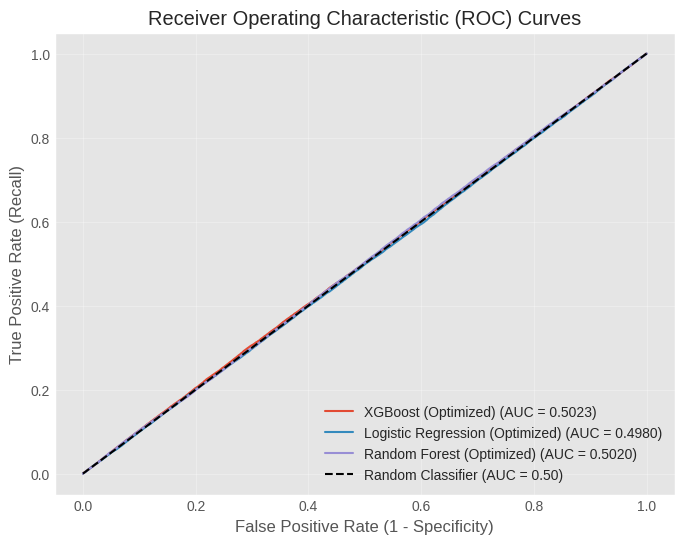

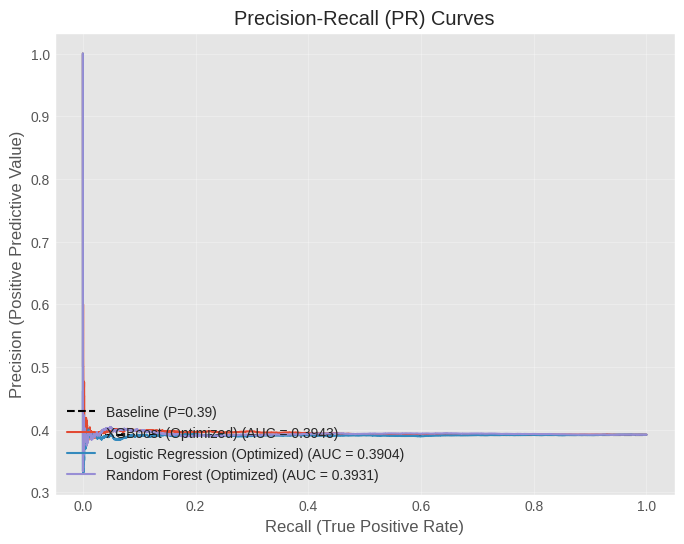

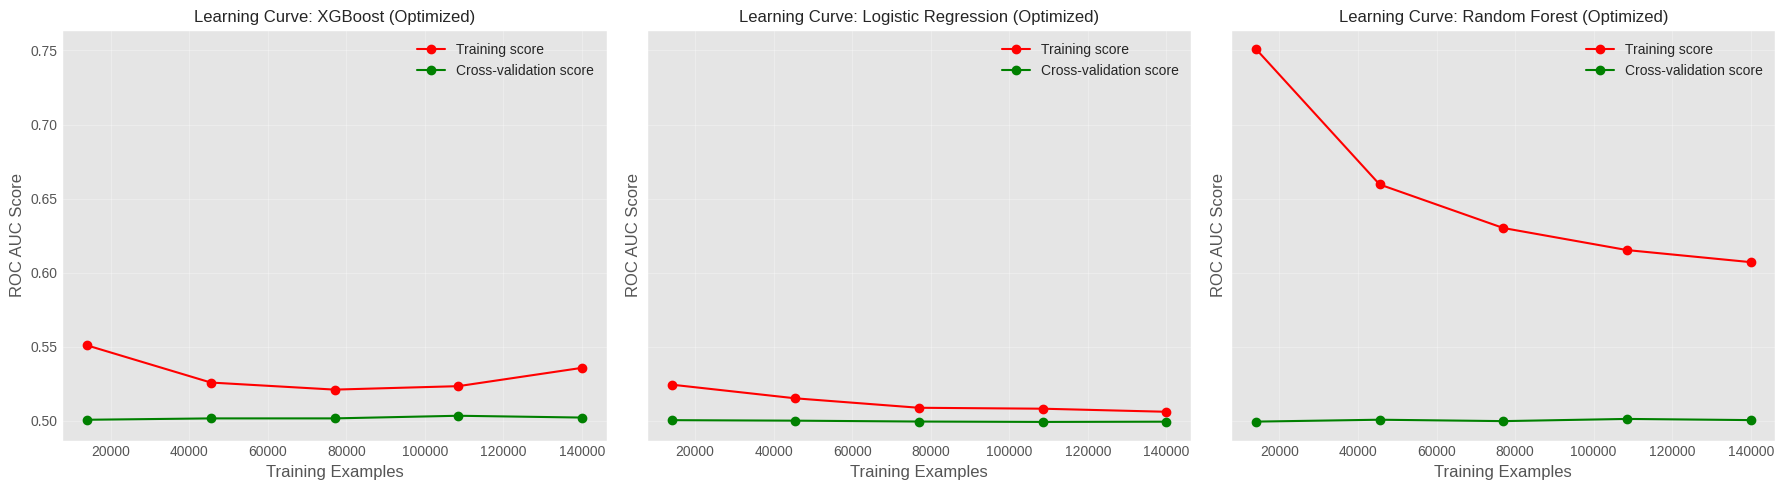

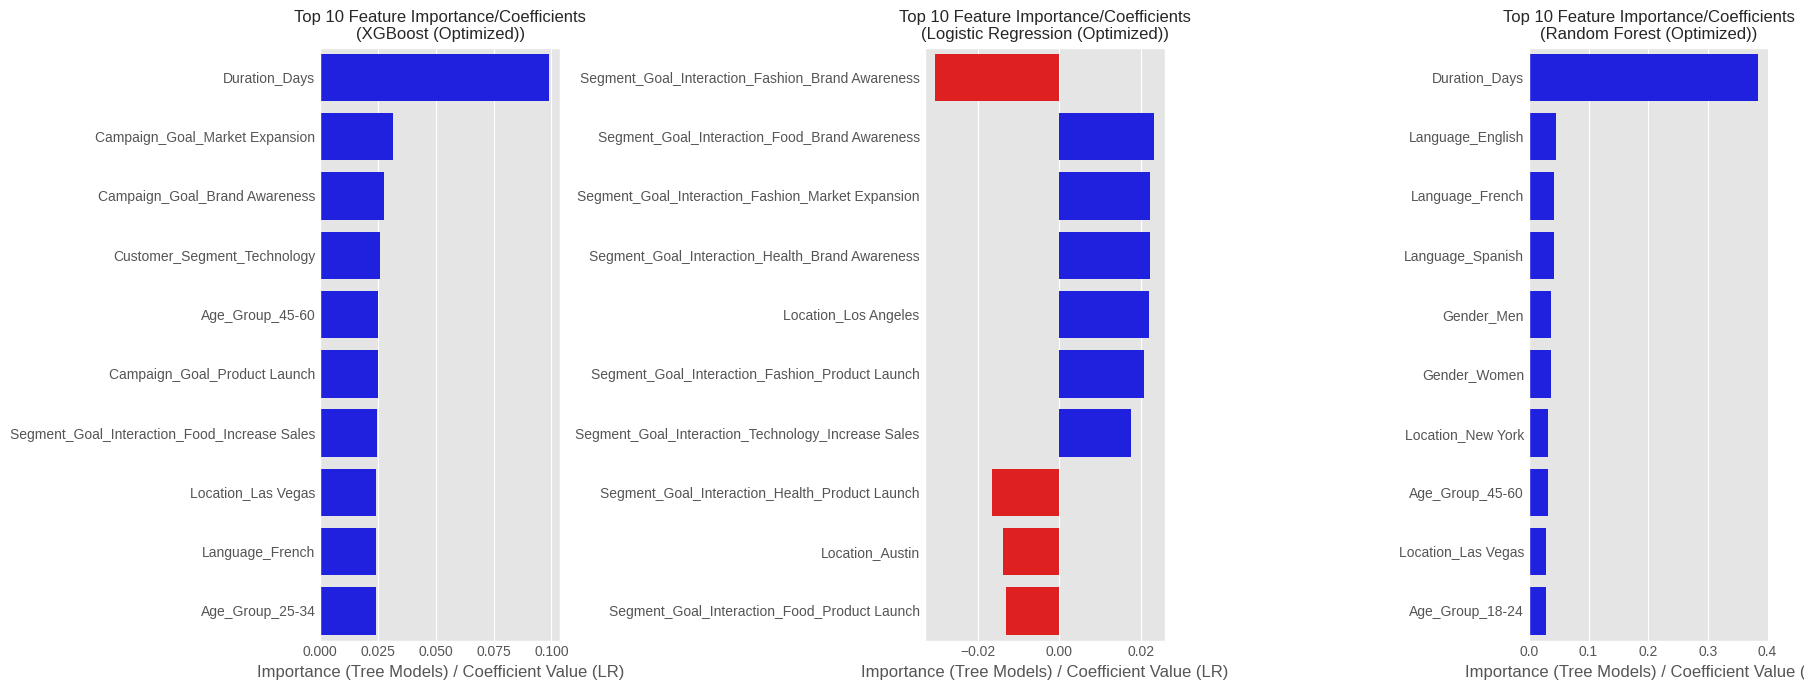

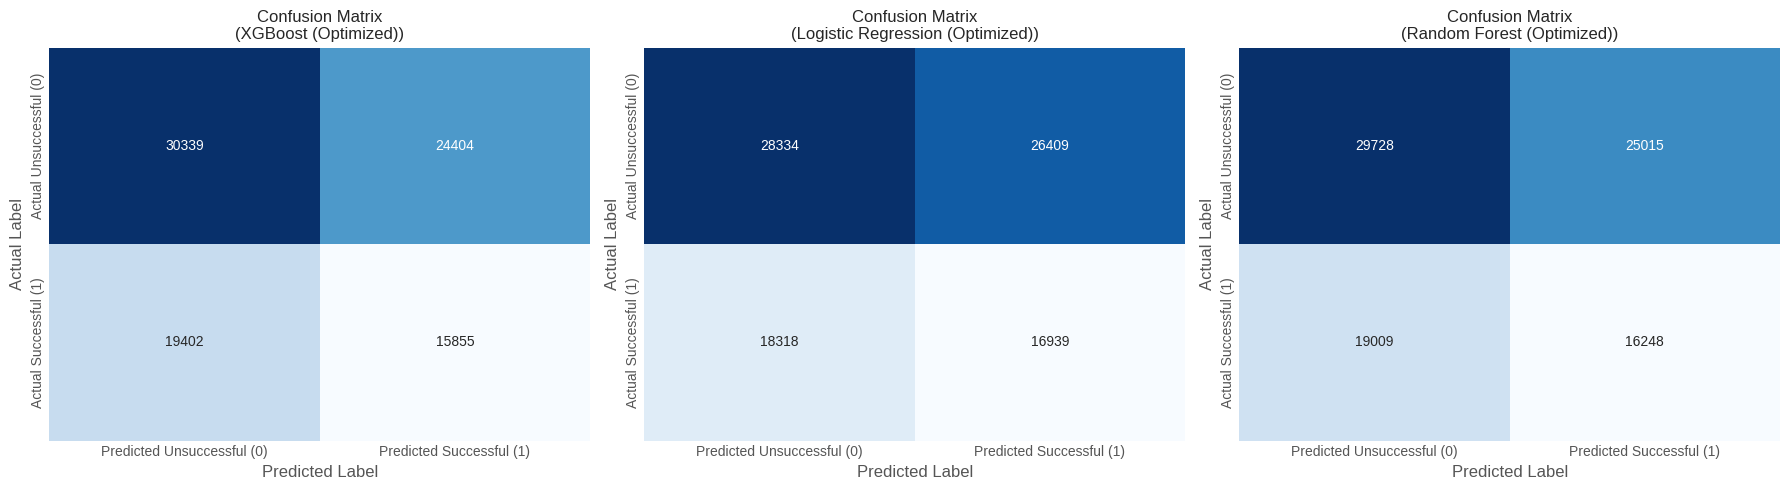


--- All plots have been generated and displayed. ---


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
import sys

# --- Configuration & Setup (Mandatory) ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
# Suppress a specific scikit-learn warning often related to the use of older XGBoost versions
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Global variables required for plotting functions
PLOT_DATA = {'ROC': {}, 'PR': {}, 'Learning_Curves': {}, 'Feature_Importance': {}, 'Confusion_Matrices': {}}
y_test_q4 = None

# Using known best parameters from previous runs
KNOWN_BEST_PARAMS = {
    'XGBoost': {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
    'LR': {'C': 10},
    'RF': {'n_estimators': 100, 'max_depth': 10}
}


# --- UPDATED PLANNING_FEATURES LIST TO MATCH Q4 MODEL TRAINING ---
PLANNING_FEATURES = [
    'Age_Group', 'Gender', 'Campaign_Goal', 'Location', 'Language',
    'Customer_Segment', 'Segment_Goal_Interaction'
]
PREDICTIVE_FEATURES_Q4 = [f for f in ['Duration_Days'] + PLANNING_FEATURES if f in df.columns]

numeric_features_q4 = [f for f in ['Duration_Days'] if f in PREDICTIVE_FEATURES_Q4]
categorical_features_q4 = [f for f in PLANNING_FEATURES if f in PREDICTIVE_FEATURES_Q4]

# --- UPDATED CONVERSION_SUCCESS THRESHOLD TO MATCH Q4 MODEL TRAINING ---
df['Conversion_Success'] = (df['Conversion_Rate'] >= 0.10).astype(int)
X_q4 = df[PREDICTIVE_FEATURES_Q4].copy()
y_q4 = df['Conversion_Success']

preprocessor_q4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_q4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_q4)
    ],
    remainder='passthrough'
)

# Populate the global y_test_q4 variable
X_train_q4, X_test_q4, y_train_q4, y_test_q4 = train_test_split(
    X_q4, y_q4, test_size=0.3, random_state=SEED, stratify=y_q4
)
print("Data preparation complete.")

# *** CRITICAL FIX: Fit the preprocessor BEFORE we try to extract feature names ***
preprocessor_q4.fit(X_train_q4)
print("Preprocessor fitted to training data (CRITICAL STEP COMPLETE).")

# --- HELPER FUNCTIONS ---

def get_feature_names(column_transformer):
    """Retrieves feature names after the ColumnTransformer has been fitted."""
    output_features = []
    # Use .transformers_ (with underscore) since the object has been fitted
    for name, step, original_cols in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(original_cols)
        elif name == 'cat':
            # Use the modern method get_feature_names_out if possible
            if hasattr(step, 'get_feature_names_out'):
                output_features.extend(step.get_feature_names_out(original_cols))
            else:
                # Fallback using categories_ (now safe to use since it's fitted)
                for i, col in enumerate(original_cols):
                    categories = step.categories_[i]
                    output_features.extend([f"{col}_{cat}" for cat in categories])
    return output_features

def calculate_learning_curve_data(pipeline, X, y, scoring='roc_auc', cv=3):
    """Calculates training and cross-validation scores across different training set sizes."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=pipeline,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=SEED
    )
    return {
        'train_sizes': train_sizes.tolist(),
        'train_scores_mean': np.mean(train_scores, axis=1).tolist(),
        'val_scores_mean': np.mean(test_scores, axis=1).tolist()
    }

# --- 2. Direct Model Training and Data Collection (Populating PLOT_DATA) ---
print("--- 2. Direct Model Training and Analysis Data Collection ---")
# Get feature names now that the preprocessor is fitted
feature_names = get_feature_names(preprocessor_q4)

for model_key in KNOWN_BEST_PARAMS:
    params = KNOWN_BEST_PARAMS[model_key]

    if model_key == 'XGBoost':
        classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=SEED, use_label_encoder=False, **params)
        model_name = 'XGBoost (Optimized)'
    elif model_key == 'LR':
        classifier = LogisticRegression(solver='liblinear', random_state=SEED, max_iter=1000, **params)
        model_name = 'Logistic Regression (Optimized)'
    elif model_key == 'RF':
        classifier = RandomForestClassifier(random_state=SEED, **params)
        model_name = 'Random Forest (Optimized)'
    else:
        continue

    # 2a. Train the model using the ALREADY FITTED preprocessor
    # We clone the preprocessor to avoid retraining it, but the ImbPipeline handles it
    # correctly as the first step on unfitted input data too, but we need the fitted version
    # to extract feature names for importance metrics.
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_q4), # Uses the preprocessor defined and fitted above
        ('smote', SMOTE(random_state=SEED)),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train_q4, y_train_q4)

    # 2b. Generate Predictions
    y_proba = pipeline.predict_proba(X_test_q4)[:, 1]
    y_pred = pipeline.predict(X_test_q4)
    roc_auc = roc_auc_score(y_test_q4, y_proba)
    print(f"Trained {model_name}. ROC AUC: {roc_auc:.4f}")

    # 2c. Collect Plotting Data (ROC, PR, Confusion Matrix)
    fpr, tpr, _ = roc_curve(y_test_q4, y_proba)
    precision, recall, _ = precision_recall_curve(y_test_q4, y_proba)

    PLOT_DATA['ROC'][model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    PLOT_DATA['PR'][model_name] = {'precision': precision, 'recall': recall, 'auc': auc(recall, precision)}
    PLOT_DATA['Confusion_Matrices'][model_name] = confusion_matrix(y_test_q4, y_pred)

    # 2d. Collect Feature Importance Data
    final_classifier = pipeline.named_steps['classifier']
    if isinstance(final_classifier, (xgb.XGBClassifier, RandomForestClassifier)):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Value': final_classifier.feature_importances_
        }).sort_values(by='Value', ascending=False)
        PLOT_DATA['Feature_Importance'][model_name] = importance_df
    elif isinstance(final_classifier, LogisticRegression):
        coefficients = final_classifier.coef_[0] if final_classifier.coef_.ndim > 1 else final_classifier.coef_
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Value': coefficients
        })
        importance_df['Abs_Value'] = importance_df['Value'].abs()
        importance_df = importance_df.sort_values(by='Abs_Value', ascending=False).drop(columns=['Abs_Value'])
        PLOT_DATA['Feature_Importance'][model_name] = importance_df

    # 2e. Collect Learning Curve Data
    # Note: Learning curve function will re-fit the pipeline internally multiple times
    PLOT_DATA['Learning_Curves'][model_name] = calculate_learning_curve_data(pipeline, X_train_q4, y_train_q4, scoring='roc_auc', cv=3)

print("Analysis data collection complete.")

# --- 3. PLOTTING FUNCTIONS ---

def plot_roc_curves(roc_data):
    """Plots the Receiver Operating Characteristic (ROC) curve for all models."""
    plt.figure(figsize=(8, 6))
    for model_name, data in roc_data.items():
        fpr = np.array(data['fpr'])
        tpr = np.array(data['tpr'])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {data["auc"]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

def plot_pr_curves(pr_data, y_test_data):
    """Plots the Precision-Recall (PR) curve for all models."""
    plt.figure(figsize=(8, 6))
    # Baseline for PR curve is the percentage of positive class
    baseline = np.sum(y_test_data) / len(y_test_data)
    plt.plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline (P={baseline:.2f})')

    for model_name, data in pr_data.items():
        recall = np.array(data['recall'])
        precision = np.array(data['precision'])
        plt.plot(recall, precision, label=f'{model_name} (AUC = {data["auc"]:.4f})')

    plt.xlabel('Recall (True Positive Rate)')
    plt.ylabel('Precision (Positive Predictive Value)')
    plt.title('Precision-Recall (PR) Curves')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()

def plot_learning_curves(lc_data):
    """Plots the Learning Curves for all models."""
    n_models = len(lc_data)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, data) in zip(axes, lc_data.items()):
        train_sizes = np.array(data['train_sizes'])
        train_scores = np.array(data['train_scores_mean'])
        val_scores = np.array(data['val_scores_mean'])

        ax.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, val_scores, 'o-', color="g", label="Cross-validation score")

        ax.set_title(f'Learning Curve: {model_name}', fontsize=12)
        ax.set_xlabel("Training Examples")
        ax.set_ylabel("ROC AUC Score")
        ax.grid(alpha=0.3)
        ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

def plot_feature_importance(importance_data):
    """Plots the top 10 feature importances/coefficients for all models."""
    n_models = len(importance_data)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 7))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, df_imp) in zip(axes, importance_data.items()):
        df_plot = df_imp.head(10).copy()

        # Determine the color based on the feature importance sign (for LR)
        colors = ['red' if val < 0 else 'blue' for val in df_plot['Value']]

        sns.barplot(
            x='Value',
            y='Feature',
            data=df_plot,
            ax=ax,
            palette=colors if model_name.startswith('Logistic') else ['blue'] * len(df_plot)
        )

        ax.set_title(f'Top 10 Feature Importance/Coefficients\n({model_name})', fontsize=12)
        ax.set_xlabel('Importance (Tree Models) / Coefficient Value (LR)')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(cm_data):
    """Plots Confusion Matrix heatmaps for all models."""
    n_models = len(cm_data)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, cm) in zip(axes, cm_data.items()):
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=['Predicted Unsuccessful (0)', 'Predicted Successful (1)'],
            yticklabels=['Actual Unsuccessful (0)', 'Actual Successful (1)'],
            ax=ax
        )
        ax.set_title(f'Confusion Matrix\n({model_name})', fontsize=12)
        ax.set_ylabel('Actual Label')
        ax.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

# --- 4. EXECUTE PLOTS ---
print("\n--- 4. Generating Visualizations ---")
plt.style.use('ggplot')

# These functions now rely on the PLOT_DATA being fully populated in Step 2,
# which depends on the successful preprocessor fit.
plot_roc_curves(PLOT_DATA['ROC'])
plot_pr_curves(PLOT_DATA['PR'], y_test_q4)
plot_learning_curves(PLOT_DATA['Learning_Curves'])
plot_feature_importance(PLOT_DATA['Feature_Importance'])
plot_confusion_matrices(PLOT_DATA['Confusion_Matrices'])

print("\n--- All plots have been generated and displayed. ---")

**Q5- old version ('Duration_Days','Channel_Used','Campaign_Goal','Customer_Segment','Location','Age_Group','Gender','Language','Conversion_Rate')**


--- Training and Evaluating Multiple Models ---

          MULTI-MODEL PERFORMANCE SUMMARY
| Model                       |   R-squared (Actual Cost) | RMSE (Actual Cost)   |
|:----------------------------|--------------------------:|:---------------------|
| Gradient Boosting Regressor |                    0.9302 | $1,134.95            |
| Ridge Regression            |                    0.7765 | $2,031.46            |
| Linear Regression           |                    0.7764 | $2,031.49            |

✅ Best Model Selected: **Gradient Boosting Regressor** (R^2: 0.9302)

--- Generating Individual Feature Importance Plots ---


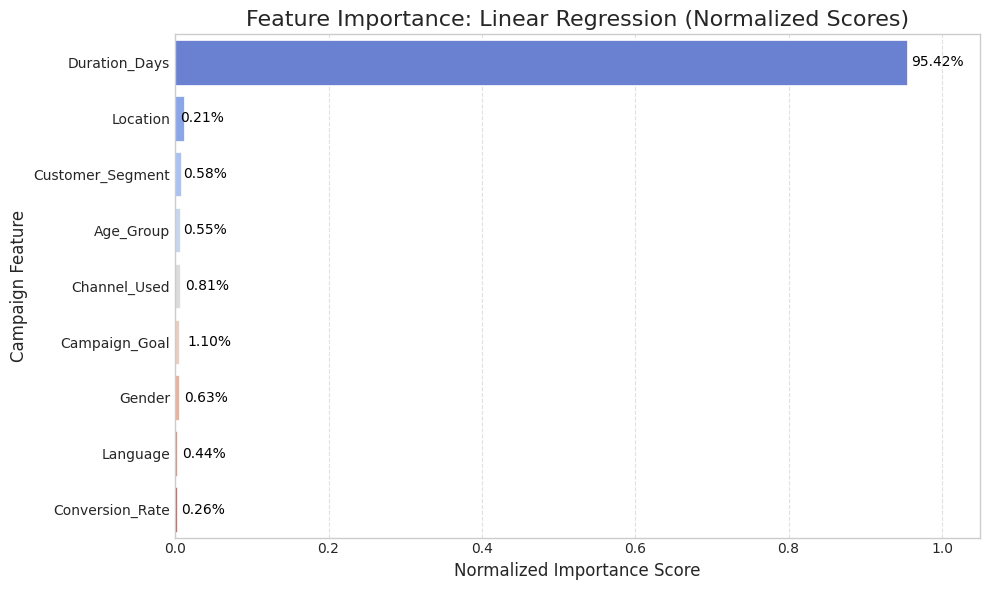

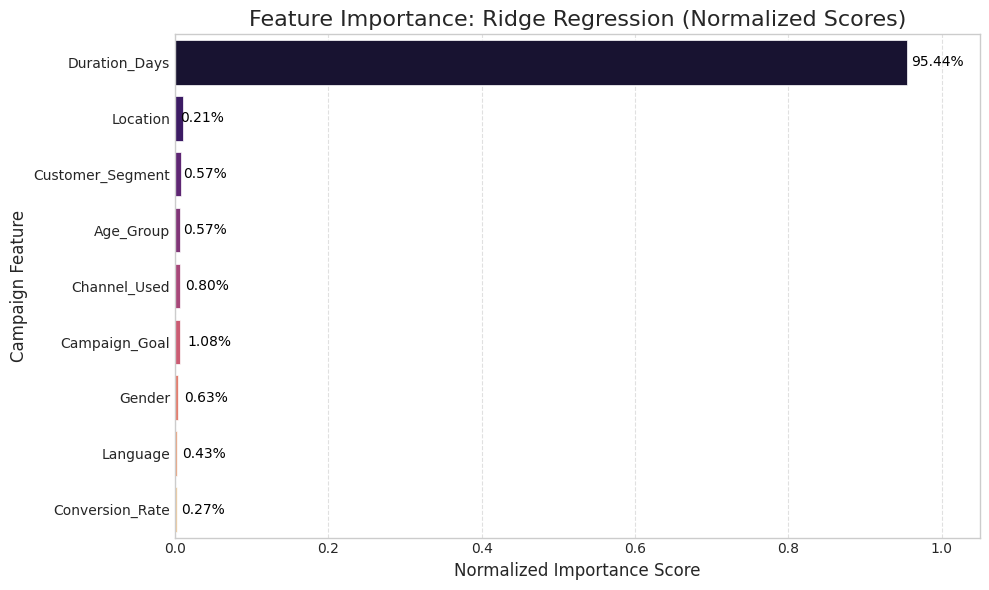

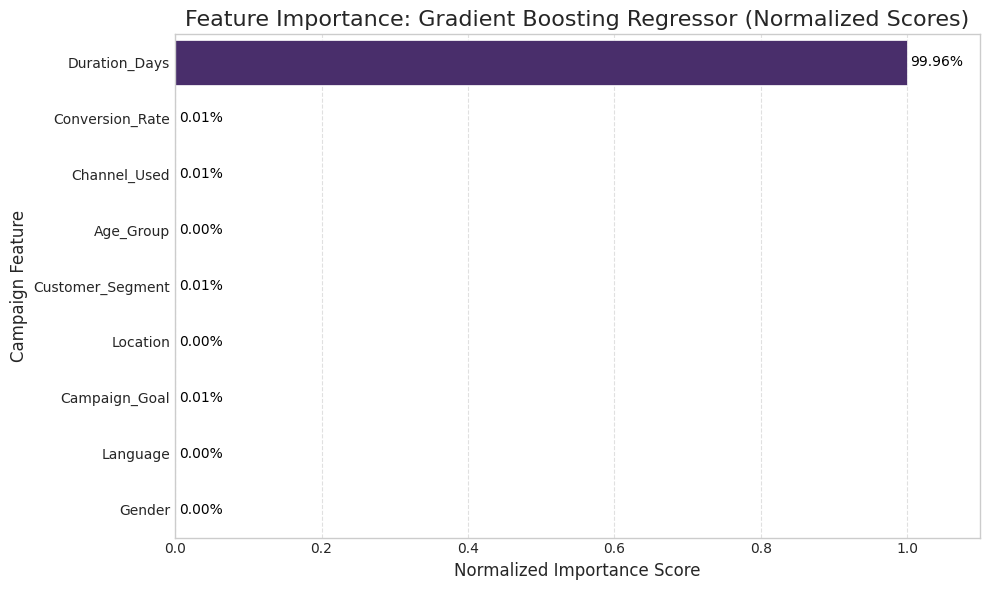


--- Generating Actual vs. Predicted Plot for Gradient Boosting Regressor ---


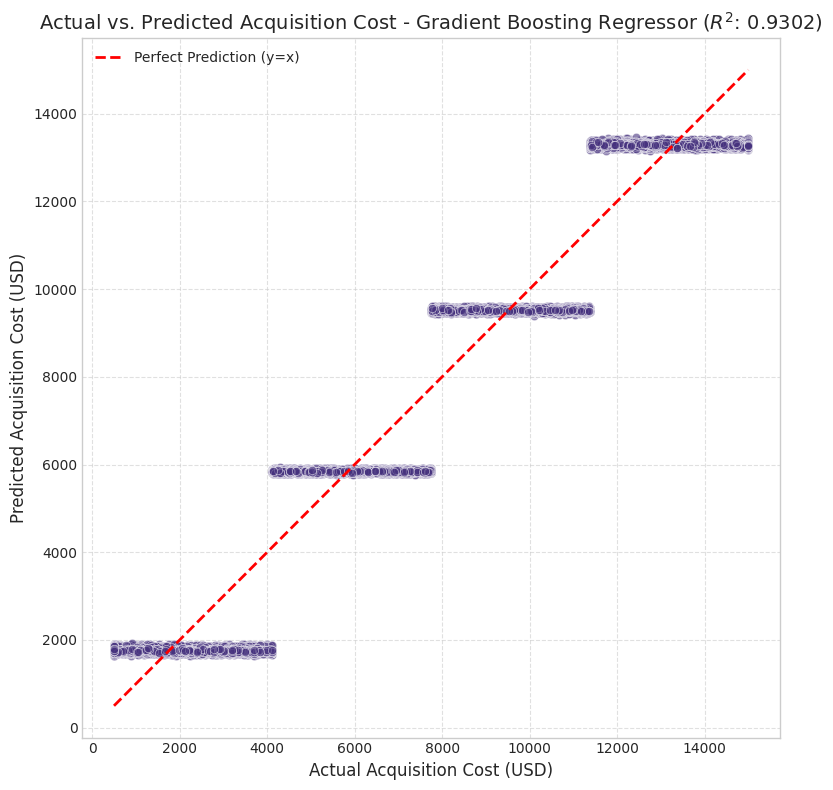


--- Generating Learning Curve for Gradient Boosting Regressor ---


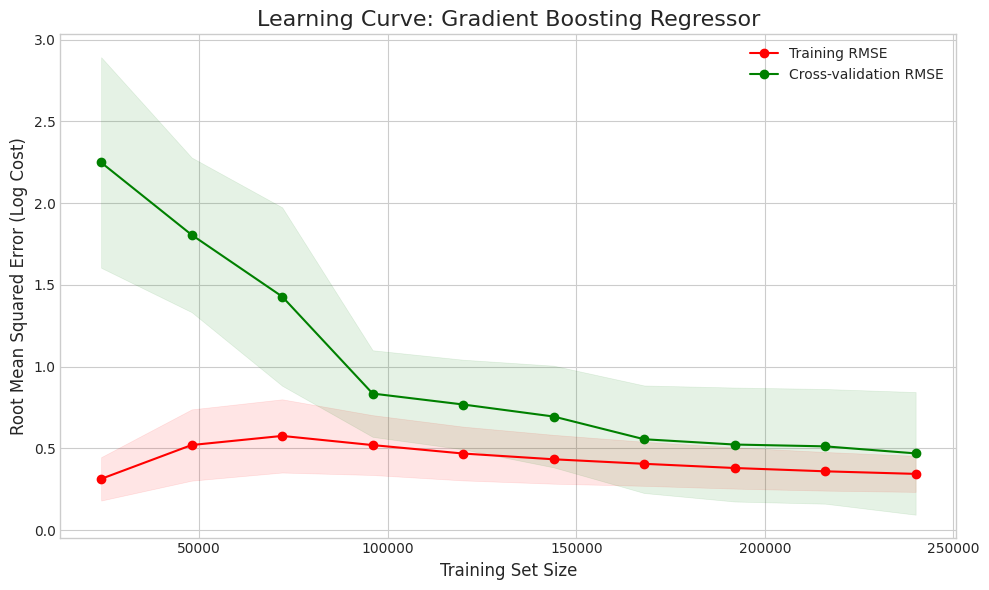

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- 2. Q5 Setup: Predicting Acquisition Cost ---
# Target: Acquisition_Cost (Log-transformed)
y_q5 = np.log1p(df['Acquisition_Cost'].replace([np.inf, -np.inf], np.nan).fillna(0))

PREDICTIVE_FEATURES = [
    'Duration_Days',
    'Channel_Used',
    'Campaign_Goal',
    'Customer_Segment',
    'Location',
    'Age_Group',
    'Gender',
    'Language',
    'Conversion_Rate'
]
X_q5 = df[[f for f in PREDICTIVE_FEATURES if f in df.columns]].copy()

# Preprocessing definitions
categorical_features = [f for f in X_q5.select_dtypes(include=['object']).columns]
numeric_features_q5 = [f for f in X_q5.select_dtypes(include=['float64', 'int64']).columns]

preprocessor_q5 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_q5),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_q5, y_q5, test_size=0.3, random_state=SEED
)

# --- 3. Model Definition and Training Loop ---

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=SEED),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)
}

results = []
best_r2 = -np.inf
best_model_name = None
pipelines = {}

print("\n--- Training and Evaluating Multiple Models ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_q5),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)

    # Predict and transform back from log space
    y_test_pred_log = pipeline.predict(X_test)
    y_pred_actual = np.expm1(y_test_pred_log)
    y_test_actual = np.expm1(y_test)

    R2_test = r2_score(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

    results.append({
        'Model': name,
        'R-squared (Actual Cost)': R2_test,
        'RMSE (Actual Cost)': rmse
    })

    pipelines[name] = pipeline

    if R2_test > best_r2:
        best_r2 = R2_test
        best_model_name = name
        best_pipeline = pipeline

# Display Comparison Table
results_df = pd.DataFrame(results).sort_values(by='R-squared (Actual Cost)', ascending=False).reset_index(drop=True)
results_df['R-squared (Actual Cost)'] = results_df['R-squared (Actual Cost)'].map('{:.4f}'.format)
results_df['RMSE (Actual Cost)'] = results_df['RMSE (Actual Cost)'].map('${:,.2f}'.format)

print("\n=================================================")
print("          MULTI-MODEL PERFORMANCE SUMMARY")
print("=================================================")
print(results_df.to_markdown(index=False))
print(f"\n✅ Best Model Selected: **{best_model_name}** (R^2: {best_r2:.4f})")
print("=================================================")

# --- 4. Function to Extract and Aggregate Feature Importance ---

def extract_and_aggregate_importance(pipeline, model_name, original_features, numeric_features):
    """Extracts importance (coefficients or feature_importances_) and aggregates by original feature."""
    regressor = pipeline.named_steps['regressor']

    # 1. Get coefficients/importances and feature names
    if 'Linear' in model_name or 'Ridge' in model_name:
        raw_values = regressor.coef_
        is_linear = True
    else: # Gradient Boosting
        raw_values = regressor.feature_importances_
        is_linear = False

    feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()

    importance_df = pd.DataFrame({
        'Feature_Encoded': feature_names_out,
        'Raw_Value': raw_values
    })

    # Use absolute value for importance comparison
    importance_df['Absolute_Value'] = np.abs(importance_df['Raw_Value'])

    # 2. Aggregate by original feature
    aggregated_importance = []

    # Handle Numeric Features (StandardScaler prefix is 'num__')
    for feature in numeric_features:
        name_prefix = f'num__{feature}'
        relevant_rows = importance_df[importance_df['Feature_Encoded'].str.startswith(name_prefix)]
        total_abs_importance = relevant_rows['Absolute_Value'].sum()
        aggregated_importance.append({'Original_Feature': feature, 'Absolute_Importance': total_abs_importance})

    # Handle Categorical Features (OneHotEncoder prefix is 'cat__')
    for feature in original_features:
        name_prefix = f'cat__{feature}_' # OHE adds an underscore
        relevant_rows = importance_df[importance_df['Feature_Encoded'].str.startswith(name_prefix)]
        total_abs_importance = relevant_rows['Absolute_Value'].sum()
        aggregated_importance.append({'Original_Feature': feature, 'Absolute_Importance': total_abs_importance})

    aggregated_df = pd.DataFrame(aggregated_importance)
    aggregated_df = aggregated_df[aggregated_df['Absolute_Importance'] > 0]

    # Normalize the aggregated results
    total_sum = aggregated_df['Absolute_Importance'].sum()
    aggregated_df['Importance_Normalized'] = (aggregated_df['Absolute_Importance'] / total_sum)
    aggregated_df['Model'] = model_name

    return aggregated_df

# --- 5. Individual Feature Importance Plots ---

print("\n--- Generating Individual Feature Importance Plots ---")

plot_palettes = {
    'Linear Regression': 'coolwarm',
    'Ridge Regression': 'magma',
    'Gradient Boosting Regressor': 'viridis'
}

for name, pipeline in pipelines.items():
    importance_df = extract_and_aggregate_importance(
        pipeline,
        name,
        categorical_features,
        numeric_features_q5
    )

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Importance_Normalized',
        y='Original_Feature',
        data=importance_df.sort_values(by='Importance_Normalized', ascending=False),
        palette=plot_palettes.get(name, 'rocket')
    )

    plt.title(f'Feature Importance: {name} (Normalized Scores)', fontsize=16)
    plt.xlabel('Normalized Importance Score', fontsize=12)
    plt.ylabel('Campaign Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Add annotations (numerical values) to the bars
    for i, row in importance_df.sort_values(by='Importance_Normalized', ascending=False).iterrows():
        score_text = f"{row['Importance_Normalized']:.2%}"
        ax.text(
            row['Importance_Normalized'] + 0.005, # x position (slightly offset)
            ax.get_yticks()[i],
            score_text,
            color='black',
            va='center',
            fontsize=10
        )

    plt.xlim(0, importance_df['Importance_Normalized'].max() * 1.1)
    plt.tight_layout()
    plt.show()


# --- 6. Actual vs. Predicted Plot for BEST Model ---
print(f"\n--- Generating Actual vs. Predicted Plot for {best_model_name} ---")

y_pred_best_log = best_pipeline.predict(X_test)
y_pred_best_actual = np.expm1(y_pred_best_log)
y_test_actual = np.expm1(y_test)

plt.figure(figsize=(8, 8))

# Scatter plot of Actual vs. Predicted values
plt.scatter(y_test_actual, y_pred_best_actual, alpha=0.6, color=sns.color_palette('viridis')[0], edgecolors='w', linewidth=0.5)

# Plot the perfect prediction line (y=x)
min_val = min(y_test_actual.min(), y_pred_best_actual.min())
max_val = max(y_test_actual.max(), y_pred_best_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction (y=x)')

r2_val = r2_score(y_test_actual, y_pred_best_actual)
plt.title(f'Actual vs. Predicted Acquisition Cost - {best_model_name} ($R^2$: {r2_val:.4f})', fontsize=14)
plt.xlabel('Actual Acquisition Cost (USD)', fontsize=12)
plt.ylabel('Predicted Acquisition Cost (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Learning Curve for BEST Model ---
print(f"\n--- Generating Learning Curve for {best_model_name} ---")

# We use the raw, non-split data (X_q5, y_q5) and the best model pipeline
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline,
    X_q5,
    y_q5,
    cv=5,
    scoring='neg_mean_squared_error', # Use MSE for log-transformed data
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=SEED
)

# Convert MSE to RMSE (and negate it since learning_curve returns negative MSE)
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

# Calculate mean and standard deviation for plotting
train_scores_mean = np.mean(train_rmse, axis=1)
train_scores_std = np.std(train_rmse, axis=1)
test_scores_mean = np.mean(test_rmse, axis=1)
test_scores_std = np.std(test_rmse, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation RMSE")

plt.title(f'Learning Curve: {best_model_name}', fontsize=16)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Root Mean Squared Error (Log Cost)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

**Q5 with added features('Duration_Days','Channel_Used','Campaign_Goal','Customer_Segment','Location','Age_Group','Gender','Language','Conversion_Rate','ROI','Clicks','Impressions','Engagement_Score','Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression')-updated**


--- Training and Evaluating Multiple Models ---

          MULTI-MODEL PERFORMANCE SUMMARY
| Model                       |   R-squared (Actual Cost) | RMSE (Actual Cost)   |
|:----------------------------|--------------------------:|:---------------------|
| Gradient Boosting Regressor |                    0.9982 | $180.56              |
| Ridge Regression            |                    0.6501 | $2,541.40            |
| Linear Regression           |                    0.6468 | $2,553.48            |

✅ Best Model Selected: **Gradient Boosting Regressor** (R^2: 0.9982)

--- Generating Individual Feature Importance Plots ---


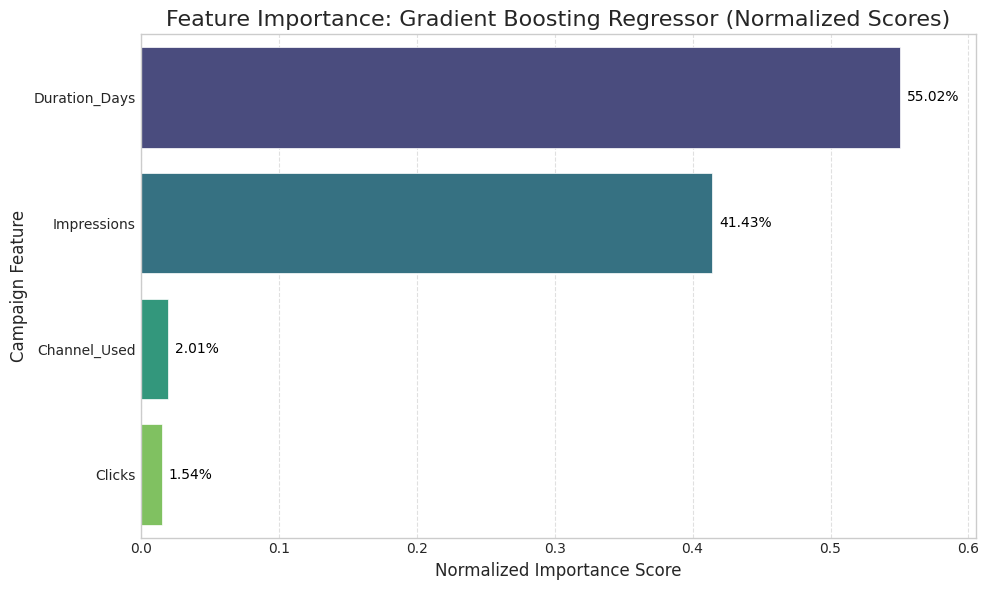


--- Generating Actual vs. Predicted Plot for Gradient Boosting Regressor ---


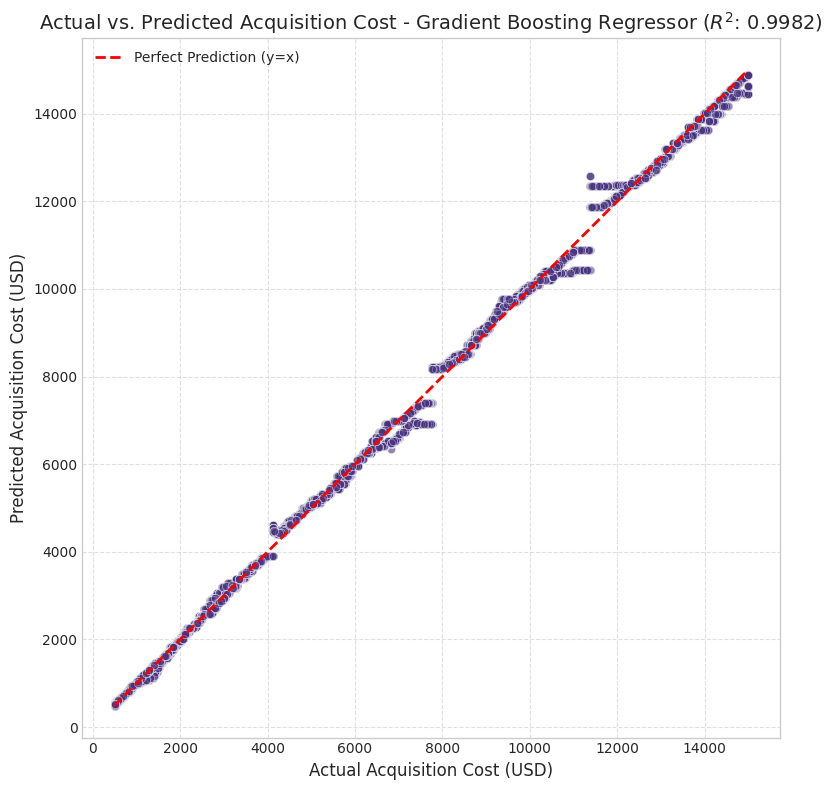


--- Generating Learning Curve for Gradient Boosting Regressor ---


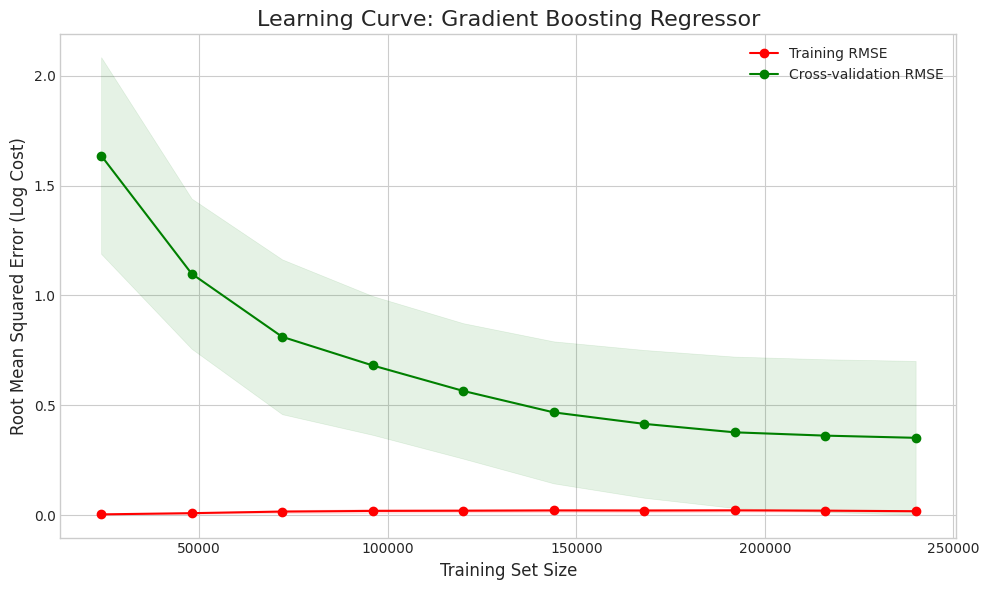

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# --- 2. Q5 Setup: Predicting Acquisition Cost ---
# Target: Acquisition_Cost (Log-transformed)
y_q5 = np.log1p(df['Acquisition_Cost'].replace([np.inf, -np.inf], np.nan).fillna(0))

PREDICTIVE_FEATURES = [
    'Duration_Days',
    'Channel_Used',
    'Campaign_Goal',
    'Customer_Segment',
    'Location',
    'Age_Group',
    'Gender',
    'Language',
    'Conversion_Rate',
    'ROI',
    'Clicks',
    'Impressions',
    'Engagement_Score','Click_Through_Rate', 'Cost_Per_Click', 'Cost_Per_Impression'
]
X_q5 = df[[f for f in PREDICTIVE_FEATURES if f in df.columns]].copy()

# Preprocessing definitions
categorical_features = [f for f in X_q5.select_dtypes(include=['object']).columns]
numeric_features_q5 = [f for f in X_q5.select_dtypes(include=['float64', 'int64']).columns]

preprocessor_q5 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_q5),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_q5, y_q5, test_size=0.3, random_state=SEED
)

# --- 3. Model Definition and Training Loop ---

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=SEED),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)
}

results = []
best_r2 = -np.inf
best_model_name = None
pipelines = {}

print("\n--- Training and Evaluating Multiple Models ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_q5),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)

    # Predict and transform back from log space
    y_test_pred_log = pipeline.predict(X_test)
    y_pred_actual = np.expm1(y_test_pred_log)
    y_test_actual = np.expm1(y_test)

    R2_test = r2_score(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

    results.append({
        'Model': name,
        'R-squared (Actual Cost)': R2_test,
        'RMSE (Actual Cost)': rmse
    })

    pipelines[name] = pipeline

    if R2_test > best_r2:
        best_r2 = R2_test
        best_model_name = name
        best_pipeline = pipeline

# Display Comparison Table
results_df = pd.DataFrame(results).sort_values(by='R-squared (Actual Cost)', ascending=False).reset_index(drop=True)
results_df['R-squared (Actual Cost)'] = results_df['R-squared (Actual Cost)'].map('{:.4f}'.format)
results_df['RMSE (Actual Cost)'] = results_df['RMSE (Actual Cost)'].map('${:,.2f}'.format)

print("\n=================================================")
print("          MULTI-MODEL PERFORMANCE SUMMARY")
print("=================================================")
print(results_df.to_markdown(index=False))
print(f"\n✅ Best Model Selected: **{best_model_name}** (R^2: {best_r2:.4f})")
print("=================================================")

# --- 4. Function to Extract and Aggregate Feature Importance ---

def extract_and_aggregate_importance(pipeline, model_name, original_features, numeric_features):
    """Extracts importance (coefficients or feature_importances_) and aggregates by original feature."""
    regressor = pipeline.named_steps['regressor']

    # 1. Get coefficients/importances and feature names
    if 'Linear' in model_name or 'Ridge' in model_name:
        raw_values = regressor.coef_
        is_linear = True
    else: # Gradient Boosting
        raw_values = regressor.feature_importances_
        is_linear = False

    feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()

    importance_df = pd.DataFrame({
        'Feature_Encoded': feature_names_out,
        'Raw_Value': raw_values
    })

    # Use absolute value for importance comparison
    importance_df['Absolute_Value'] = np.abs(importance_df['Raw_Value'])

    # 2. Aggregate by original feature
    aggregated_importance = []

    # Handle Numeric Features (StandardScaler prefix is 'num__')
    for feature in numeric_features:
        name_prefix = f'num__{feature}'
        relevant_rows = importance_df[importance_df['Feature_Encoded'].str.startswith(name_prefix)]
        total_abs_importance = relevant_rows['Absolute_Value'].sum()
        aggregated_importance.append({'Original_Feature': feature, 'Absolute_Importance': total_abs_importance})

    # Handle Categorical Features (OneHotEncoder prefix is 'cat__')
    for feature in original_features:
        name_prefix = f'cat__{feature}_' # OHE adds an underscore
        relevant_rows = importance_df[importance_df['Feature_Encoded'].str.startswith(name_prefix)]
        total_abs_importance = relevant_rows['Absolute_Value'].sum()
        aggregated_importance.append({'Original_Feature': feature, 'Absolute_Importance': total_abs_importance})

    aggregated_df = pd.DataFrame(aggregated_importance)
    aggregated_df = aggregated_df[aggregated_df['Absolute_Importance'] > 0]

    # Normalize the aggregated results
    total_sum = aggregated_df['Absolute_Importance'].sum()
    aggregated_df['Importance_Normalized'] = (aggregated_df['Absolute_Importance'] / total_sum)
    aggregated_df['Model'] = model_name

    return aggregated_df

# --- 5. Individual Feature Importance Plots ---

print("\n--- Generating Individual Feature Importance Plots ---")

plot_palettes = {
    'Linear Regression': 'coolwarm',
    'Ridge Regression': 'magma',
    'Gradient Boosting Regressor': 'viridis'
}

for name, pipeline in pipelines.items():
    importance_df = extract_and_aggregate_importance(
        pipeline,
        name,
        categorical_features,
        numeric_features_q5
    )

# Sort the DataFrame for plotting and annotation
sorted_importance = importance_df.sort_values(by='Importance_Normalized', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Importance_Normalized',
    y='Original_Feature',
    data=sorted_importance,
    palette=plot_palettes.get(name, 'rocket')
)

plt.title(f'Feature Importance: {name} (Normalized Scores)', fontsize=16)
plt.xlabel('Normalized Importance Score', fontsize=12)
plt.ylabel('Campaign Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# FIXED: Use enumerate for correct y-tick positioning
for i, row in sorted_importance.iterrows():
    score_text = f"{row['Importance_Normalized']:.2%}"
    ax.text(
        row['Importance_Normalized'] + 0.005,  # x position (slightly offset)
        i,                                     # y position (bar index)
        score_text,
        color='black',
        va='center',
        fontsize=10
    )

plt.xlim(0, sorted_importance['Importance_Normalized'].max() * 1.1)
plt.tight_layout()
plt.show()


# --- 6. Actual vs. Predicted Plot for BEST Model ---
print(f"\n--- Generating Actual vs. Predicted Plot for {best_model_name} ---")

y_pred_best_log = best_pipeline.predict(X_test)
y_pred_best_actual = np.expm1(y_pred_best_log)
y_test_actual = np.expm1(y_test)

plt.figure(figsize=(8, 8))

# Scatter plot of Actual vs. Predicted values
plt.scatter(y_test_actual, y_pred_best_actual, alpha=0.6, color=sns.color_palette('viridis')[0], edgecolors='w', linewidth=0.5)

# Plot the perfect prediction line (y=x)
min_val = min(y_test_actual.min(), y_pred_best_actual.min())
max_val = max(y_test_actual.max(), y_pred_best_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction (y=x)')

r2_val = r2_score(y_test_actual, y_pred_best_actual)
plt.title(f'Actual vs. Predicted Acquisition Cost - {best_model_name} ($R^2$: {r2_val:.4f})', fontsize=14)
plt.xlabel('Actual Acquisition Cost (USD)', fontsize=12)
plt.ylabel('Predicted Acquisition Cost (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Learning Curve for BEST Model ---
print(f"\n--- Generating Learning Curve for {best_model_name} ---")

# We use the raw, non-split data (X_q5, y_q5) and the best model pipeline
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline,
    X_q5,
    y_q5,
    cv=5,
    scoring='neg_mean_squared_error', # Use MSE for log-transformed data
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=SEED
)

# Convert MSE to RMSE (and negate it since learning_curve returns negative MSE)
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

# Calculate mean and standard deviation for plotting
train_scores_mean = np.mean(train_rmse, axis=1)
train_scores_std = np.std(train_rmse, axis=1)
test_scores_mean = np.mean(test_rmse, axis=1)
test_scores_std = np.std(test_rmse, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation RMSE")

plt.title(f'Learning Curve: {best_model_name}', fontsize=16)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Root Mean Squared Error (Log Cost)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

**RFECV- ROI Prediction**

SUCCESS: Data loaded for Q4 ROI RFECV Analysis.

--- Data Preprocessing ---

--- Running RFECV (Recursive Feature Elimination with CV) ---
Optimal number of features found: 1
R^2 score at optimal feature count (CV mean): 0.4050

--- Top Features Selected by RFECV ---
['cat__Channel_Used_Pinterest']

--- Final Model Evaluation (Using RFECV Selected Features) ---
Model: Gradient Boosting Regressor (GBR)
--------------------------------------------------
Optimal Features Selected: 1
R-squared (R2) Score (Log-Transformed Data): 0.4005
Mean Squared Error (MSE, Inverse-Transformed ROI): 4.32
Root Mean Squared Error (RMSE, Inverse-Transformed ROI): 2.08
--------------------------------------------------


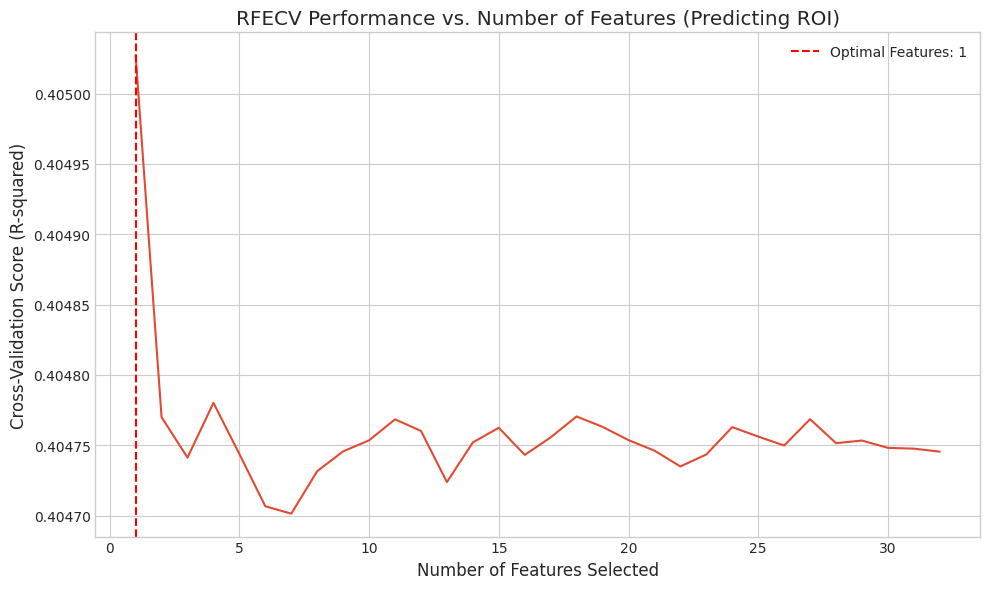


RFECV analysis for Q4 complete. The plot shows the stability of the model's performance.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error

# --- Configuration & Data Loading ---
SEED = 42
FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Web and social/Social_Media_Advertising.csv'

try:
    df = pd.read_csv(FILE_PATH)
    print("SUCCESS: Data loaded for Q4 ROI RFECV Analysis.")
except FileNotFoundError:
    raise FileNotFoundError(f"FATAL ERROR: Could not find the CSV file at {FILE_PATH}.")

# --- Data Cleaning and Feature Engineering ---
print("\n--- Data Preprocessing ---")

# 1. Clean numeric columns (remove $, %, and convert to float)
numeric_cols_to_clean = ['Acquisition_Cost', 'Conversion_Rate', 'ROI']
for col in numeric_cols_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'[$,%]', '', regex=True).str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(float)

# 2. Extract Duration_Days
if 'Duration' in df.columns:
    df['Duration_Days'] = df['Duration'].astype(str).str.extract('(\\d+)').astype(int, errors='ignore').fillna(0)
    df.drop(columns=['Duration'], inplace=True, errors='ignore')
else:
    df['Duration_Days'] = 0.0

# 3. Split Target_Audience into Gender and Age_Group
df[['Gender', 'Age_Group_Ext']] = df['Target_Audience'].str.split(expand=True).iloc[:, [0, 1]].fillna('Unknown')
df['Age_Group'] = df['Age_Group_Ext']
df.drop(columns=['Age_Group_Ext', 'Target_Audience'], inplace=True, errors='ignore')

# --- Q4 Setup: Predicting ROI ---
# Target: ROI (Log-transformed)
# Use np.log1p for log(1 + x) to handle ROI values close to zero gracefully
# and to address its skewed distribution.
y = np.log1p(df['ROI'].replace([np.inf, -np.inf], np.nan).fillna(0))

# Features: Use all relevant campaign parameters and performance metrics
PREDICTIVE_FEATURES = [
    'Acquisition_Cost', 'Conversion_Rate', 'Duration_Days',
    'Channel_Used', 'Campaign_Goal', 'Customer_Segment',
    'Location', 'Age_Group', 'Gender', 'Language'
]
X = df[[f for f in PREDICTIVE_FEATURES if f in df.columns]].copy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# --- Preprocessing Pipeline Definition ---
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- Step 1: Feature Transformation for RFECV ---
# RFECV needs feature names, so we fit the preprocessor separately first.
X_train_processed = preprocessor.fit_transform(X_train)
feature_names_out = preprocessor.get_feature_names_out()

# Convert to DataFrame for easier inspection and RFECV compatibility
# FIX: Removed .toarray() as preprocessor often returns a dense numpy.ndarray
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names_out)


# --- Step 2: RFECV Selection Process ---
print("\n--- Running RFECV (Recursive Feature Elimination with CV) ---")
estimator = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)

# Initialize RFECV
rfecv = RFECV(
    estimator=estimator,
    step=1,                 # Number of features to remove at each step
    cv=5,                   # 5-fold cross-validation
    scoring='r2',           # Metric to optimize
    verbose=0,              # Set to 1 or 2 to see step-by-step progress
    n_jobs=-1
)

# Fit RFECV
rfecv.fit(X_train_df, y_train)

print(f"Optimal number of features found: {rfecv.n_features_}")
# Note: rfecv.grid_scores_ is deprecated in newer scikit-learn versions, but we keep it for now.
# We index the score array to get the R^2 for the optimal number of features.
optimal_score = rfecv.cv_results_['mean_test_score'][rfecv.n_features_ - 1]
print(f"R^2 score at optimal feature count (CV mean): {optimal_score:.4f}")

# Get selected feature names
selected_features_mask = rfecv.support_
selected_features = X_train_df.columns[selected_features_mask].tolist()

print("\n--- Top Features Selected by RFECV ---")
# Limit the display of selected features to a reasonable number if too many
if len(selected_features) > 15:
    print(f"Showing the first 15 of {len(selected_features)} selected features...")
    print(selected_features[:15])
else:
    print(selected_features)


# --- Step 3: Train Final GBR Model with Selected Features ---

# Full pipeline definition (simplified for this context, using pre-selected features)
# We apply the transformation to the test set and filter the resulting columns
X_train_final = X_train_df[selected_features]
X_test_processed = preprocessor.transform(X_test)
# FIX: Removed .toarray() here as well
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names_out)
X_test_final = X_test_df[selected_features]

# Train the final model
final_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)
final_gbr.fit(X_train_final, y_train)

# --- Step 4: Comprehensive Evaluation ---
y_pred = final_gbr.predict(X_test_final)

# Since we log-transformed the target (y), we must inverse transform predictions for interpretable error metrics
# Inverse transformation: exp(y) - 1
y_test_inv = np.expm1(y_test)
y_pred_inv = np.expm1(y_pred)

r2 = r2_score(y_test, y_pred) # Use log-transformed for R2 (model fit)
mse_inv = mean_squared_error(y_test_inv, y_pred_inv)
rmse_inv = np.sqrt(mse_inv)

print("\n--- Final Model Evaluation (Using RFECV Selected Features) ---")
print(f"Model: Gradient Boosting Regressor (GBR)")
print("-" * 50)
print(f"Optimal Features Selected: {len(selected_features)}")
print(f"R-squared (R2) Score (Log-Transformed Data): {r2:.4f}")
print(f"Mean Squared Error (MSE, Inverse-Transformed ROI): {mse_inv:.2f}")
print(f"Root Mean Squared Error (RMSE, Inverse-Transformed ROI): {rmse_inv:.2f}")
print("-" * 50)

# --- Step 5: RFECV Visualization ---
plt.figure(figsize=(10, 6))
plt.title('RFECV Performance vs. Number of Features (Predicting ROI)')
plt.xlabel("Number of Features Selected")
plt.ylabel(f"Cross-Validation Score (R-squared)")
# Use cv_results_ for stability across scikit-learn versions
score_array = rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(score_array) + 1), score_array)
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--',
            label=f'Optimal Features: {rfecv.n_features_}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRFECV analysis for Q4 complete. The plot shows the stability of the model's performance.")